**Initialization**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

In [ ]:
# THIS IS THE NEW CORRECT NOTEBOOK
import os
import logging
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision import models
from torchvision import datasets

from PIL import Image
from tqdm import tqdm

import zipfile

from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np

from random import randint

import shutil

import time

from IPython.display import display

In [ ]:
#The folowing parameters are the same as in the paper
DEVICE = 'cuda' # 'cuda' or 'cpu'
BATCH_SIZE = 64
LR = 3e-4
WEIGHT_DECAY = 0.05
MOMENTUM = 0.9

NUM_EPOCHS = 40

LAMBDA1 =  1     # weight of the PreTex task on the final loss
LAMBDA2 = 0.1    # weight of the loss of the target data contributing to the pretext loss

LOG_FREQUENCY = 20

ELAPSED_DA_EPOCHS = 0 # number of epochs of the restored DA checkpoint (useful for correctly restoring the num of epochs)
ELAPSED_SO_EPOCHS = 0 # number of epochs of the restored SO checkpoint (useful for correctly restoring the num of epochs)
DA_RESTORED = False   # Flags the retoration of a checkpoint --> allows retrieving list of lists of losses to which keep concatenatenating values for plotting
SO_RESTORED = False   # Flags the retoration of a checkpoint --> allows retrieving list of lists of losses to which keep concatenatenating values for plotting
V_RESTORED = False   # Flags the retoration of a checkpoint --> allows retrieving list of lists of losses to which keep concatenatenating values for plotting

EARLY_STOP_VAL = 10
NUM_BATCHES_LIMITED = 100 #(DEPRECATED since we do not use partial tests anymore)

SECOND_VARIATION = False  # <==== PERFORM VARIATION SELECTION HERE <==== (variation1:False ; variation2:True)

In [ ]:
# Hyperparameters sets      (DOMAIN ADAPTATION)
# (LR, Lambda1, Lambda2)
s1 = (6e-4, 1, 0.1, 1)      # copy owned by MATTEO
s2 = (3e-4, 1, 0.1, 2)      # copy owned by JORDAN (values of the paper)
s3 = (3e-4, 2, 0.1, 3)      # copy owned by MATTEO
"""s4 = (6e-4, 1.5, 0.3, 4) # copy owned by JORDAN, keeps getting worse
s5 = (3e-5, 2, 0.3, 5)      # copy owned by DODO, very bad
s6 = (3e-5, 1.5, 0.3, 6)    # copy owned by DODO, still bad"""
s4 = (6e-4, 1, 0.3, 4)      # copy owned by JORDAN, substitute
s5 = (1e-4, 1, 0.05, 5)     # copy owned by DODO, first substitute
s6 = (1e-4, 0.75, 0.1, 6)   # copy owned by DODO, second substitute

"""s0 = (1e-4, 1.15, 0.05, 0) # this set was tested only once, later excluded
WEIGHT_DECAY = 0.01
BATCH_SIZE = 80"""

# Hyperparameters sets      (SOURCE ONLY)
#(Batch Size, LR, weight decay)
s7 = (64, 3e-4, 0.05, 7)        # copy owned by MATTEO (values of the paper)
s8 = (128, 3e-4, 0.05, 8)       # copy owned by JORDAN
s9 = (64, 6e-4, 0.05, 9)        # copy owned by MATTEO
s10 = (128, 6e-4, 0.005, 10)    # copy owned by JORDAN
s11 = (64, 3e-5, 0.005, 11)     # copy owned by DODO
s12 = (128, 3e-5, 0.005, 12)    # copy owned by DODO

# Hyperparameters sets      (VARIATION)
#(LR, Lambda1, Lambda2)
s13 = (3e-4, 1, 0.1, 13)         # (values of the paper)
s14 = (3e-4, 0.5, 0.1, 14)       # lower lambda1
s15 = (3e-4, 1.5, 0.1, 15)       # higher lambda1

selected_set = s7     # <=== PERFORM SELECTION HERE <===

if selected_set[3]<=6:
  LR = selected_set[0]
  LAMBDA1 = selected_set[1]
  LAMBDA2 = selected_set[2]
  print("Code set up for: DOMAIN ADAPTATION")
elif selected_set[3]<=12:
  BATCH_SIZE = selected_set[0]
  LR = selected_set[1]
  WEIGHT_DECAY = selected_set[2]
  print("Code set up for: SOURCE ONLY BASELINE")
else:
  LR = selected_set[0]
  LAMBDA1 = selected_set[1]
  LAMBDA2 = selected_set[2]
  print("Code set up for: VARIATION")

prefix = str(selected_set[3])

Code set up for: SOURCE ONLY BASELINE


**Mount dataset from Google Drive and unzip it**

The drive is supposed to contain a folder called "datasets" that should contain ROD.zip and synROD.zip

(It is also supposed to store the checkpoints)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# USE ONLY TO UNMOUNT DRIVE (useful when I/O errors occur)
from google.colab import drive
drive.flush_and_unmount()

Unzipping the dataset

In [ ]:
# known integration error among colab and drive: https://research.google.com/colaboratory/faq.html#drive-timeout.
# No clear solution. Some suggest there might be a limit on how many times we can access files on drive every day.

with zipfile.ZipFile("./drive/My Drive/datasets/synROD.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset_unzipped/")

with zipfile.ZipFile("./drive/My Drive/datasets/ROD.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset_unzipped/")

print("DONE!")

DONE!


**ALTERNATIVE**, **for when IO Errors occur**

Alternative that can be tested when errors occur (substitutes both the mount and unzip blocks above)

In [ ]:
print("ROD")
# download from drive
!gdown https://drive.google.com/uc?id=1s4D9vy5uTrgHpuwvgcBabRQbGXa3XXJK&export=download
# unzip
with zipfile.ZipFile("/content/ROD.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset_unzipped/")
# remove the zip, due to disk limitations
!rm -f ROD.zip

print("synROD")
# download from drive
!gdown https://drive.google.com/uc?id=1N8H_yqbrVl7DFdMqheHhfu4waT71YL-E&export=download
# unzip
with zipfile.ZipFile("/content/synROD.zip", 'r') as zip_ref:
    zip_ref.extractall("./dataset_unzipped/")
# remove the zip
!rm -f synROD.zip

**Import external code from GitHub repo**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./MLDL_RGBD_project'):
  !git clone https://github.com/MatteGarba/MLDL_RGBD_project.git
  #!mv 'MLDL_RGBD_project' 

from MLDL_RGBD_project.models import PreText, PreText_variation, MainTask, FeatureExtractor

Cloning into 'MLDL_RGBD_project'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 176 (delta 91), reused 21 (delta 8), pack-reused 0
Receiving objects: 100% (176/176), 44.85 KiB | 850.00 KiB/s, done.
Resolving deltas: 100% (91/91), done.


**Reshaping, checking and fixing the datasets**

Performs data preprocessing as described in the report, but basically reshapes the dataset making it suitable for ImageFolder, removes decoupled images and discards 4 underrepresented classes

In [ ]:
from MLDL_RGBD_project.dataset_handler import Dataset_handler

d = Dataset_handler()

print("Reshaping the datasets")
d.reshape()

print() 

print("Checking synROD:")
d.check('/content/dataset_rgb_synROD','/content/dataset_depth_synROD')
d.fix('/content/dataset_rgb_synROD','/content/dataset_depth_synROD')

print()

print("Checking ROD:")
d.check('/content/dataset_rgb_ROD','/content/dataset_depth_ROD')
d.fix('/content/dataset_rgb_ROD','/content/dataset_depth_ROD')

**Preparing the dataset**

Apply the splits:

In [ ]:
def restrict_imagefolder(imagefolder, removed_pictures, is_rgb=True):
  """
  Remove the images that do not belong to the considered split from the attributes of ImageFolder. 
  """
  # build a set to check if a path should be excluded or not
  with open(removed_pictures, 'r') as f:
    removed_paths = set()
    if is_rgb:
      modality='rgb'
    else:
      modality='depth'
    for line in f.readlines():
      starting_path = (line.split(' '))[0]                                  # 'apple/rgb/apple_1_05_00002009.png'
      pieces = starting_path.split('/')
      final_path = f"/content/dataset_{modality}_synROD/{pieces[0]}/{pieces[2]}"   # '/content/dataset_rgb_synROD/apple/apple_1_05_00002009.png
      removed_paths.add(final_path)

  # remove all samples from imagefolder that appear in the set, and also the targets attribute
  filtered_indices = [i for i, sample in enumerate(imagefolder.samples) if sample[0] not in removed_paths]
  filtered_samples = [imagefolder.samples[i] for i in filtered_indices]
  filtered_targets = [imagefolder.targets[i] for i in filtered_indices]
  
  # use the filtered lists as attributes for ImageFolder
  imagefolder.samples = filtered_samples
  imagefolder.targets = filtered_targets
  imagefolder.imgs = imagefolder.samples
  return imagefolder   
    

Continue towards dataloaders preparation by means of:


1.   Define transforms (ad-hoc class)
2.   Create ImageFolders (eventually restricted)

continues...


In [ ]:
from MLDL_RGBD_project.rgb_depth_pairs import DualDataset, DualRandomHFlip, DualRandomCrop, dual, DualCompose

# Define transforms for the datasets
test_transform = DualCompose([dual(transforms.Resize(256), is_dual = False),      # Resizes short size of the PIL image to 256
                    dual(transforms.CenterCrop(224), is_dual = False),  # Crops a central square patch of the image
                                                                 # 224 because torchvision's ResNet18 needs a 224x224 input!
                    dual(transforms.ToTensor(), is_dual = False),      # Turn PIL Image to torch.Tensor
                    dual(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), is_dual = False) # Normalizes tensor with mean and standard deviation
])
my_transforms = DualCompose([dual(transforms.Resize(256), is_dual=False),
                    dual(DualRandomCrop(224), is_dual=True),
                    dual(DualRandomHFlip(p=0.5), is_dual=True),
                    dual(transforms.ToTensor(), is_dual=False),
                    dual(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), is_dual=False)
])

# create ImageFolders
data_folder = "/content/dataset_rgb_synROD"
data_synRODrgb = datasets.ImageFolder(root = data_folder)
data_synRODrgb = restrict_imagefolder(data_synRODrgb, '/content/dataset_unzipped/synROD/synARID_50k-split_rgb_test1.txt', is_rgb=True)  # remove the testing ones

test_synRODrgb = datasets.ImageFolder(root = data_folder)
test_synRODrgb = restrict_imagefolder(test_synRODrgb, '/content/dataset_unzipped/synROD/synARID_50k-split_rgb_train1.txt', is_rgb=True) # remove the training part

data_folder = "/content/dataset_depth_synROD"
data_synRODdepth = datasets.ImageFolder(root = data_folder)
data_synRODdepth = restrict_imagefolder(data_synRODdepth, '/content/dataset_unzipped/synROD/synARID_50k-split_depth_test1.txt', is_rgb=False)  # remove the testing ones

test_synRODdepth = datasets.ImageFolder(root = data_folder)
test_synRODdepth = restrict_imagefolder(test_synRODdepth, '/content/dataset_unzipped/synROD/synARID_50k-split_depth_train1.txt', is_rgb=False) # remove the training part

data_folder = "/content/dataset_rgb_ROD"
data_RODrgb = datasets.ImageFolder(root = data_folder)

data_folder = "/content/dataset_depth_ROD"
data_RODdepth = datasets.ImageFolder(root = data_folder)


...here we go:
3.   Allocate dataset object DualDataset (cool class :-) )
4.   Define the base (not transformed dataloaders)

(sorry for the UGLY typo "dataloarder", it was too widespreaded to correct it)

In [ ]:
#Source for training
source_data = DualDataset(data_synRODrgb, data_synRODdepth, False, dual_transforms=my_transforms)
source_dataloarder = torch.utils.data.DataLoader(source_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

#Target for training
train_target_data = DualDataset(data_RODrgb, data_RODdepth, False, dual_transforms=my_transforms)
train_target_dataloarder = torch.utils.data.DataLoader(train_target_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

#Target for test
test_target_data = DualDataset(data_RODrgb, data_RODdepth, False, dual_transforms=test_transform)
test_target_dataloarder = torch.utils.data.DataLoader(test_target_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = False)

"""
#Source for test (deprecated)
source_test_data = DualDataset(test_synRODrgb, test_synRODdepth, flag_rotate=False, dual_transforms=my_transforms)
source_test_dataloarder = torch.utils.data.DataLoader(source_test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last = False)
"""

In [ ]:
# These are defined as functions because the desired transformation (rotate/permute)
# is embedded in the dual dataset definition, thus it's required to re-define
# them at each epoch in order to constantly change the relative rotations/permutations

def get_rotated_dataLoader(data_synRODrgb, data_synRODdepth, data_RODrgb, data_RODdepth):
  #Rotated Datasets 
  source_rotated_data = DualDataset(data_synRODrgb, data_synRODdepth, True, dual_transforms=my_transforms)
  target_rotated_data = DualDataset(data_RODrgb, data_RODdepth, True, dual_transforms=my_transforms)
  #Rotated Dataloader
  source_rotated_dataloarder = torch.utils.data.DataLoader(source_rotated_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
  target_rotated_dataloarder = torch.utils.data.DataLoader(target_rotated_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
  return source_rotated_dataloarder,target_rotated_dataloarder

def get_permuted_dataLoader(data_synRODrgb, data_synRODdepth, data_RODrgb, data_RODdepth, v2=False):
  #Permuted Datasets 
  source_permuted_data = DualDataset(data_synRODrgb, data_synRODdepth, False, dual_transforms=my_transforms, flag_permute=True, variation2=v2)
  target_permuted_data = DualDataset(data_RODrgb, data_RODdepth, False, dual_transforms=my_transforms, flag_permute=True, variation2=v2)
  #Permuted Dataloader
  source_permuted_dataloarder = torch.utils.data.DataLoader(source_permuted_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
  target_permuted_dataloarder = torch.utils.data.DataLoader(target_permuted_data, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)
  return source_permuted_dataloarder,target_permuted_dataloarder

**Validation and Test function**

Called at the end of each epoch to run a test phase. It can be used for a partial test (portion of Target) or for a complete test depending on the "test_phase" flag. In the end is always used for complete tests due to a big difference in the results making them uncomparable.

In [ ]:
def validation_test(extractor, maintask, dataloader, criterion, test_phase):
  # i perform the model evaluation after each epoch
  running_corrects = 0
  loss_val = 0.0
  extractor.eval()
  maintask.eval()
  batch_n = 0

  with torch.no_grad():
    for (rgb, depth), labels in tqdm(dataloader):
      batch_n += 1
      rgb = rgb.to(DEVICE)
      depth = depth.to(DEVICE)
      labels = labels.to(DEVICE)
      #make predictions
      features = extractor.forward(rgb, depth)
      outputs = maintask.forward(features)
      #get the validation loss for each batch
      loss_val += criterion(outputs, labels).item()*len(rgb)
      # Get predictions
      _, preds = torch.max(outputs.data, 1) 

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
      # stop at batch number 100 if test_phase = True
      if batch_n == NUM_BATCHES_LIMITED and test_phase == False:
        break

  if test_phase == False:
    length = NUM_BATCHES_LIMITED*BATCH_SIZE
  else:
    length = len(dataloader.dataset)
  
  return float(loss_val)/ float(length), float(running_corrects)/ float(length)

**----- SOURCE-ONLY BASELINE -----**

Define the base models

In [ ]:
# Model components
Extractor1 = FeatureExtractor().to(DEVICE)
mainTask1 = MainTask().to(DEVICE)

Prepare training

In [ ]:
# Optimizers
extractor1_opt = optim.SGD(Extractor1.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
mainTask1_opt = optim.SGD(mainTask1.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)

**Define checkpoint methods**

The checkpoint life:


*   When saving: saved on colab and copied in drive
*   When loading: copied in colab from drive and read



In [ ]:
"""
so_checkpoint = {'Extractor': Extractor,
                'mainTask': mainTask,
          'Extractor_state_dict': Extractor.state_dict(),
          'mainTask_state_dict': mainTask.state_dict(),
                'extractor_opt': extractor_opt,
                'mainTask_opt': mainTask_opt,
          'Extractor_optimizer' : extractor_opt.state_dict(),
          'mainTask_optimizer' : mainTask_opt.state_dict(),
                'epoch': epoch,
                'lossesLists': lossesLists,
                'val_accuracy' : val_accuracy,
                'additional_data': additional_data,
                'main_checkpoints': main_checkpoints}
"""

DRIVEPATH = "/content/drive/My Drive/"
LOCALPATH = "/content/checkpoints/"
SO_CHECKPOINT = "so_checkpoint.pth"

# Function loading a checkpoint
def load_so_checkpoint(prefix=""):

  if not os.path.isdir("/content/checkpoints"):           # create local destination if doesn't exist
    !mkdir /content/checkpoints
  
  if os.path.exists(DRIVEPATH+str(prefix)+SO_CHECKPOINT) and os.path.isfile(DRIVEPATH+str(prefix)+SO_CHECKPOINT): # if checkpoint file existst and is a file
    shutil.copyfile(DRIVEPATH+str(prefix)+SO_CHECKPOINT, LOCALPATH+str(prefix)+SO_CHECKPOINT)                     # copy it locally
  else:
    sys.exit(-1)
  
  checkpoint = torch.load(LOCALPATH+str(prefix)+SO_CHECKPOINT)                                                    # load it from local copy

  Extractor = checkpoint['Extractor']
  mainTask = checkpoint['mainTask']
  extractor_opt = checkpoint['extractor_opt']
  mainTask_opt = checkpoint['mainTask_opt']

  Extractor.load_state_dict(checkpoint['Extractor_state_dict'])
  mainTask.load_state_dict(checkpoint['mainTask_state_dict'])
  extractor_opt.load_state_dict(checkpoint['Extractor_optimizer'])
  mainTask_opt.load_state_dict(checkpoint['mainTask_optimizer'])

  print(f"Restored checkpoint at epoch: {checkpoint['epoch']}")

  return Extractor, mainTask, extractor_opt, mainTask_opt,\
         checkpoint['epoch'], checkpoint['lossesLists'], checkpoint['val_accuracy'],\
         checkpoint['additional_data'], checkpoint['main_checkpoints']


def save_so_checkpoint(checkpoint, prefix=""):

  if not os.path.isdir("/content/checkpoints"):     # create local source folder
    !mkdir /content/checkpoints                 
    
  torch.save(checkpoint, LOCALPATH+str(prefix)+SO_CHECKPOINT)

  if os.path.exists(DRIVEPATH):                                                               # if drive is mounted
    shutil.copyfile(LOCALPATH+str(prefix)+SO_CHECKPOINT, DRIVEPATH+str(prefix)+SO_CHECKPOINT) # copy checkpoint file from local to drive
    print("Checkpoint saved")
  else:
    sys.exit(-1)



Load a checkpoint

WARNING: overwrites *Define the base models* and *Prepare training*

In [ ]:
# this is use for the back up
# WARNING: run this block only if you want to load the saved parameters (OVERWRITES PREVIOUS CELLS)
Extractor1, mainTask1, extractor1_opt, mainTask1_opt, ELAPSED_SO_EPOCHS, lossesLists,\
                                            val_accuracy, additional_data, main_checkpoints = load_so_checkpoint(prefix=prefix)
SO_RESTORED = True

Train

In [ ]:
# Losses
mainTask1_criterion = nn.CrossEntropyLoss() # criterion Lm

In [ ]:
start_time = time.time()
 
cudnn.benchmark                                    # Calling this optimizes runtime
 
if SO_RESTORED:                                    # if a checkpoint was loaded
  Src_mainLoss = lossesLists[0]                       # restore the previous losses lists
  epochs_no_improve = additional_data[0]
  min_val_loss = additional_data[1]
  best_epoch = additional_data[2]
  # val_accuracy is already restored
  # main_checkpoints is already restored
else:                                              # otherwise use some new ones
  Src_mainLoss = []
  val_accuracy = []
  epochs_no_improve = 0
  min_val_loss = np.Inf
  best_epoch = 0
  main_checkpoints = []
 
 
n_epochs_stop = EARLY_STOP_VAL
flag_stop = False
epoch = ELAPSED_SO_EPOCHS + 1
 
while epoch <= NUM_EPOCHS:
  if flag_stop == True:
    break
  print('Starting epoch {}/{}'.format(epoch , NUM_EPOCHS))
 
  torch.cuda.empty_cache()
  Extractor1.train(True)                                 # set in training mode
  mainTask1.train(True)                                  # set in training mode
 
  cumsum_mainloss = 0
  current_step = 0
 
  # Work on Source dataset only
  for S in source_dataloarder:
 
    # Forward pass - Source:
    (S_rgb_image, S_depth_image), S_label = S                 # load Source batch
 
    S_rgb_batch = S_rgb_image.to(DEVICE)                      # bring data over device
    S_depth_batch = S_depth_image.to(DEVICE)                  # bring data over device
    S_label = S_label.to(DEVICE)                              # bring label over device
 
    S_features = Extractor1.forward(S_rgb_batch, S_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask1.forward(S_features)                 # main task forward pass
    S_main_loss = mainTask1_criterion(outPuts_main, S_label)       # compute main loss
    cumsum_mainloss += S_main_loss.item()*len(S_rgb_image)        # loss for all the images in S_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE --> Step {}, Loss {}'.format(current_step, S_main_loss.item()))
 
 
    # final steps
    Extractor1.zero_grad()             # Zero-ing the gradients
    mainTask1.zero_grad()              # Zero-ing the gradients
 
    S_main_loss.backward()             # backward pass: computes gradients for the net
 
    extractor1_opt.step()              # update weights for extractor
    mainTask1_opt.step()               # update the weights of the only maintask
 
    current_step += 1
  
 
  #list of losses for the source dataset over the main classifier for later visualization
  Src_mainLoss.append(cumsum_mainloss / float(len(source_dataloarder.dataset)))
 
 
  # each 5 epochs do a complete validation/test phase on the target dataset
  #otherwise do it on 100 batches only for all the other epochs
  """big_test = False
  if epoch != 0 and epoch % 5 == 0:
    big_test = True"""
  # Not entirely representative of the actual performance in quick validations. Let's do a complete one each epoch
  big_test = True
 
  loss , acc = validation_test(Extractor1, mainTask1, test_target_dataloarder, mainTask1_criterion, test_phase = big_test)
  val_accuracy.append(acc)
  print(f"VALIDATION ACCURACY: {acc}")
 
 
  # early stopping criterion
  if loss < min_val_loss:       # if there was an improvement in the loss --> reset counter
    epochs_no_improve = 0
    min_val_loss = loss
    best_epoch = epoch
  else:                       # Otherwise increment count of epochs with no improvement
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve >= n_epochs_stop:
      print(f'\nEarly stopping! at epoch {epoch}.\n The best epoch is epoch {best_epoch}')
      flag_stop = True
 
 
  # save the model at each epoch end
  lossesLists = [Src_mainLoss] # list of losses lists
  additional_data = [epochs_no_improve, min_val_loss, best_epoch]            # list of important params to save
  
  checkpoint = {'Extractor': Extractor1,
                'mainTask': mainTask1,
          'Extractor_state_dict': Extractor1.state_dict(),
          'mainTask_state_dict': mainTask1.state_dict(),
                'extractor_opt': extractor1_opt,
                'mainTask_opt': mainTask1_opt,
          'Extractor_optimizer' : extractor1_opt.state_dict(),
          'mainTask_optimizer' : mainTask1_opt.state_dict(),
                'epoch': epoch,
                'lossesLists': lossesLists,
                'val_accuracy' : val_accuracy,
                'additional_data': additional_data,
                'main_checkpoints': main_checkpoints}
 
  if epoch != 0 and epoch % 5 == 0:
    # each 5 epochs save the checkpoint in the main checkpoints list
    main_checkpoint = dict()  # create an independent copy
    for k in checkpoint:
      if k != 'main_checkpoints': # clear this for memory purposes
        main_checkpoint[k] = checkpoint[k]
      else:
        main_checkpoint[k] = None

    checkpoint['main_checkpoints'].append(main_checkpoint)
 
  save_so_checkpoint(checkpoint, prefix=prefix)
  
  # save the checkpoint
  
  exec_time = time.time() - start_time
  mins = int(exec_time // 60)
  secs = int(exec_time % 60)
  print(f"--- Elapsed time from trainig start (eventual checkpoint restoration excluded): {mins} minutes and {secs} seconds ---")
  epoch +=1
  # --- epoch end ---

Test

In [ ]:
loss, accuracy = validation_test(Extractor1, mainTask1, test_target_dataloader, mainTask1_criterion, True)
print('The test loss is {:.2f}, and accuracy {:.2f}'.format{loss, accuracy})

**----- DOMAIN-ADAPTATION -----**

**Define the base models**

In [ ]:
Extractor = FeatureExtractor().to(DEVICE)
mainTask = MainTask().to(DEVICE)
preText = PreText().to(DEVICE)

**Prepare training**

In [ ]:
# Optimizer
extractor_opt = optim.SGD(Extractor.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
mainTask_opt = optim.SGD(mainTask.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
preText_opt = optim.SGD(preText.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)

**Define checkpoint methods**

The checkpoint life:


*   When saving: saved on colab and copied in drive
*   When loading: copied in colab from drive and read



In [ ]:
"""
da_checkpoint = {'Extractor': Extractor,
                'mainTask': mainTask,
                'preText': preText,
          'Extractor_state_dict': Extractor.state_dict(),
          'mainTask_state_dict': mainTask.state_dict(),
          'preText_state_dict': preText.state_dict(),
                'extractor_opt': extractor_opt,
                'mainTask_opt': mainTask_opt,
                'preText_opt': preText_opt,
          'Extractor_optimizer' : extractor_opt.state_dict(),
          'mainTask_optimizer' : mainTask_opt.state_dict(),
          'preText_optimizer' : preText_opt.state_dict(),
                'epoch': epoch,
                'lossesLists': lossesLists,
                'val_accuracy' : val_accuracy,
                'additional_data': additional_data,
                'main_checkpoints': main_checkpoints}
"""

DRIVEPATH = "/content/drive/My Drive/"
LOCALPATH = "/content/checkpoints/"
DA_CHECKPOINT = "da_checkpoint.pth"

# Function loading a checkpoint
def load_da_checkpoint(prefix=""):

  if not os.path.isdir("/content/checkpoints"): # create destination
    !mkdir /content/checkpoints
  
  if os.path.exists(DRIVEPATH+str(prefix)+DA_CHECKPOINT) and os.path.isfile(DRIVEPATH+str(prefix)+DA_CHECKPOINT): # if f existst and is a file
    shutil.copyfile(DRIVEPATH+str(prefix)+DA_CHECKPOINT, LOCALPATH+str(prefix)+DA_CHECKPOINT)                     # copy it locally
  else:
    raise RuntimeError("Cannot find the checkpoint file. Have you loaded the drive with the dataset? Have you chosen the right hyperparameter set?")
  
  checkpoint = torch.load(LOCALPATH+str(prefix)+DA_CHECKPOINT)                                        # load it from local copy

  Extractor = checkpoint['Extractor']
  mainTask = checkpoint['mainTask']
  preText = checkpoint['preText']
  extractor_opt = checkpoint['extractor_opt']
  mainTask_opt = checkpoint['mainTask_opt']
  preText_opt = checkpoint['preText_opt']

  Extractor.load_state_dict(checkpoint['Extractor_state_dict'])
  mainTask.load_state_dict(checkpoint['mainTask_state_dict'])
  preText.load_state_dict(checkpoint['preText_state_dict'])
  extractor_opt.load_state_dict(checkpoint['Extractor_optimizer'])
  mainTask_opt.load_state_dict(checkpoint['mainTask_optimizer'])
  preText_opt.load_state_dict(checkpoint['preText_optimizer'])

  print(f"Restored checkpoint at epoch: {checkpoint['epoch']}")

  return Extractor, mainTask, preText, extractor_opt, mainTask_opt, preText_opt,\
         checkpoint['epoch'], checkpoint['lossesLists'], checkpoint['val_accuracy'], checkpoint['additional_data'], checkpoint['main_checkpoints']


def save_da_checkpoint(checkpoint, prefix=""):

  if not os.path.isdir("/content/checkpoints"): # create source
    !mkdir /content/checkpoints                 
    
  torch.save(checkpoint, LOCALPATH+str(prefix)+DA_CHECKPOINT)

  if os.path.exists(DRIVEPATH): # if f existst and is a file
    shutil.copyfile(LOCALPATH+str(prefix)+DA_CHECKPOINT, DRIVEPATH+str(prefix)+DA_CHECKPOINT) # copy it locally
    print("Checkpoint saved")
  else:
    raise RuntimeError("Cannot find the checkpoint file. Have you loaded the drive with the dataset? Have you chosen the right hyperparameter set?")


Load a checkpoint:

WARNING: overwrites *Define the base models* and *Prepare training*

In [ ]:
# this is use for the back up
# WARNING: run this block only if you want to load the saved parameters (OVERWRITES PREVIOUS CELLS)
Extractor, mainTask, preText, extractor_opt, mainTask_opt, preText_opt, ELAPSED_DA_EPOCHS, lossesLists,\
                                            val_accuracy, additional_data, main_checkpoints = load_da_checkpoint(prefix=prefix)
DA_RESTORED = True

**Domain adaptation - Training procedure**

In [ ]:
# Losses
mainTask_criterion = nn.CrossEntropyLoss() # criterion Lm
src_preText_criterion = nn.CrossEntropyLoss()  # criterion Lp
tgt_preText_criterion = nn.CrossEntropyLoss()  # criterion Lp
# 
# Entropy loss for the target on main task
def tgt_main_criterion(logits):
    p_softmax = F.softmax(logits, dim=1)
    mask = p_softmax.ge(0.000001)  # greater or equal to, used for numerical stability
    mask_out = torch.masked_select(p_softmax, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(p_softmax.size(0))

In [ ]:
start_time = time.time()
 
cudnn.benchmark                                    # Calling this optimizes runtime
 
if DA_RESTORED:                                    # if a checkpoint was loaded
  Src_mainLoss = lossesLists[0]                       # restore the previous losses lists
  tgt_mainLoss = lossesLists[1]
  Src_rotateLoss = lossesLists[2]
  tgt_rotateLoss = lossesLists[3]
  epochs_no_improve = additional_data[0]
  min_val_loss = additional_data[1]
  best_epoch = additional_data[2]
  # val_accuracy is already restored
  # main_checkpoints is already restored
else:                                              # otherwise use some new ones
  Src_mainLoss = []
  tgt_mainLoss = []
  Src_rotateLoss = []
  tgt_rotateLoss = []
  val_accuracy = []
  epochs_no_improve = 0
  min_val_loss = np.Inf
  best_epoch = 0
  main_checkpoints = []
 
 
n_epochs_stop = EARLY_STOP_VAL
flag_stop = False
epoch = ELAPSED_DA_EPOCHS + 1
 
while epoch <= NUM_EPOCHS:
  if flag_stop == True:
    break
  print('Starting epoch {}/{}'.format(epoch , NUM_EPOCHS))
 
  # Data loaders:
  source_rotated_dataloader,target_rotated_dataloader = get_rotated_dataLoader(data_synRODrgb,\
                                                    data_synRODdepth, data_RODrgb, data_RODdepth)
  
  torch.cuda.empty_cache()
  Extractor.train(True)                                 # set in training mode
  mainTask.train(True)                                  # set in training mode
  preText.train(True)                                   # set in training mode
 
  cumsum_mainloss = 0
  cumsum_T_mainloss = 0
  cumsum_Trloss = 0
  cumsum_Srloss = 0
  current_step = 0
 
  # Work on 3 batches in parallel
  for S, T, Sr, Tr in zip(source_dataloarder, train_target_dataloarder, source_rotated_dataloader, target_rotated_dataloader):
  
 
 
    # Forward pass - Source:
    (S_rgb_image, S_depth_image), S_label = S                 # load Source batch
 
    S_rgb_batch = S_rgb_image.to(DEVICE)                      # bring data over device
    S_depth_batch = S_depth_image.to(DEVICE)                  # bring data over device
    S_label = S_label.to(DEVICE)                              # bring label over device
 
    S_features = Extractor.forward(S_rgb_batch, S_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask.forward(S_features)                 # main task forward pass
    S_main_loss = mainTask_criterion(outPuts_main, S_label)       # compute main loss
    cumsum_mainloss += S_main_loss.item()*len(S_rgb_image)        # loss for all the images in S_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE --> Step {}, Loss {}'.format(current_step, S_main_loss.item()))
 
 
 
    # Forward pass - Target:
    (T_rgb_image, T_depth_image), T_label = T                 # load Source batch
 
    T_rgb_batch = T_rgb_image.to(DEVICE)                      # bring data over device
    T_depth_batch = T_depth_image.to(DEVICE)                  # bring data over device
                                                              # DON'T use the labels
 
    T_features = Extractor.forward(T_rgb_batch, T_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask.forward(T_features)                 # main task forward pass
    T_main_loss = tgt_main_criterion(outPuts_main)              # compute main loss of Target on MainTask
    cumsum_T_mainloss += T_main_loss.item()*len(T_rgb_image)           # loss for all the images in T_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('TARGET --> Step {}, Loss {}'.format(current_step, T_main_loss.item()))
 
 
 
    # Forward pass - Source rotated
    (Sr_rgb_image, Sr_depth_image), Sr_label = Sr               # load Source rotated batch
 
    Sr_rgb_batch = Sr_rgb_image.to(DEVICE)                      # bring data over device
    Sr_depth_batch = Sr_depth_image.to(DEVICE)                  # bring data over device
    Sr_label = Sr_label.to(DEVICE)                              # bring label over device
 
    Sr_features = Extractor.forward(Sr_rgb_batch, Sr_depth_batch)  # Forward pass (feature extractor)
    out_preText = preText.forward(Sr_features)                     # preText task forward pass
    Sr_loss = src_preText_criterion(out_preText, Sr_label)         # compute aux loss 
    cumsum_Srloss += Sr_loss.item()*len(Sr_rgb_image)              # loss for all the images in Sr_rgb_image
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE ROT --> Step {}, Loss {}'.format(current_step, Sr_loss.item()))
 
 
 
    # Forward pass - Target rotated
    (Tr_rgb_image, Tr_depth_image), Tr_label = Tr               # load Source rotated batch
 
    Tr_rgb_batch = Tr_rgb_image.to(DEVICE)                      # bring data over device
    Tr_depth_batch = Tr_depth_image.to(DEVICE)                  # bring data over device
    Tr_label = Tr_label.to(DEVICE)                              # bring the label to device 
 
    Tr_features = Extractor.forward(Tr_rgb_batch, Tr_depth_batch)  # Forward pass (feature extractor)
    out_preText = preText.forward(Tr_features)                     # preText task forward pass
    Tr_loss = tgt_preText_criterion(out_preText, Tr_label)                   # compute aux loss (entropy loss)
    cumsum_Trloss += Tr_loss.item()*len(Tr_rgb_image)              # loss for all the images in Tr_rgb_image
 
    if current_step % LOG_FREQUENCY == 0:
      print('TARGET ROT --> Step {}, Loss {}'.format(current_step, Tr_loss.item()))
 
 
    # computing final loss
    final_loss = S_main_loss + LAMBDA1 * (Sr_loss +  Tr_loss) + LAMBDA2 * T_main_loss
 
    if current_step % LOG_FREQUENCY == 0:
      print('TOTAL LOSS --> Step {}, Loss {}'.format(current_step, final_loss.item()))
      print()
 
    # final steps
    Extractor.zero_grad()             # Zero-ing the gradients
    mainTask.zero_grad()              # Zero-ing the gradients
    preText.zero_grad()               # Zero-ing the gradients
 
    final_loss.backward()             # backward pass: computes gradients for the net
 
    preText_opt.step()                # update weights for pretext
    extractor_opt.step()              # update weights for extractor
    mainTask_opt.step()               # update the weights of the only maintask
 
    current_step += 1
  
 
  #list of losses for the source dataset over the main classifier for later visualization
  Src_mainLoss.append(cumsum_mainloss / float(len(source_dataloarder.dataset))) 
  tgt_mainLoss.append(cumsum_T_mainloss / float(len(train_target_dataloarder.dataset))) 
  Src_rotateLoss.append(cumsum_Srloss / float(len( source_rotated_dataloader.dataset)))
  tgt_rotateLoss.append(cumsum_Trloss / float(len(target_rotated_dataloader.dataset)))
 
 
  # each 5 epochs do a complete validation/test phase on the target dataset
  #otherwise do it on 100 batches only for all the other epochs
  """big_test = False
  if epoch != 0 and epoch % 5 == 0:
    big_test = True"""
  # Not entirely representative of the actual performance in quick validations. Let's do a complete one each epoch
  big_test = True
 
  loss , acc = validation_test(Extractor, mainTask, test_target_dataloarder, mainTask_criterion, test_phase = big_test)
  val_accuracy.append(acc)
  print(f"\nVALIDATION ACCURACY: {acc}")
  print(f"VALIDATION Loss: {loss}")
 
 
  # early stopping criterion
  if loss < min_val_loss:       # if there was an improvement in the loss --> reset counter
    epochs_no_improve = 0
    min_val_loss = loss
    best_epoch = epoch
  else:                       # Otherwise increment count of epochs with no improvement
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve >= n_epochs_stop:
      print(f'\nEarly stopping! at epoch {epoch}.\n The best epoch is epoch {best_epoch}')
      flag_stop = True
 
 
  # save the model at each epoch end
  lossesLists = [Src_mainLoss, tgt_mainLoss, Src_rotateLoss, tgt_rotateLoss] # list of losses lists
  additional_data = [epochs_no_improve, min_val_loss, best_epoch]            # list of important params to save
  
  checkpoint = {'Extractor': Extractor,
                'mainTask': mainTask,
                'preText': preText,
          'Extractor_state_dict': Extractor.state_dict(),
          'mainTask_state_dict': mainTask.state_dict(),
          'preText_state_dict': preText.state_dict(),
                'extractor_opt': extractor_opt,
                'mainTask_opt': mainTask_opt,
                'preText_opt': preText_opt,
          'Extractor_optimizer' : extractor_opt.state_dict(),
          'mainTask_optimizer' : mainTask_opt.state_dict(),
          'preText_optimizer' : preText_opt.state_dict(),
                'epoch': epoch,
                'lossesLists': lossesLists,
                'val_accuracy' : val_accuracy,
                'additional_data': additional_data,
                'main_checkpoints': main_checkpoints}
 
  if epoch != 0 and epoch % 5 == 0:
    # each 5 epochs save the checkpoint in the main checkpoints list
    main_checkpoint = dict()  # create an independent copy
    for k in checkpoint:
      if k != 'main_checkpoints': # clear this for memory purposes
        main_checkpoint[k] = checkpoint[k]
      else:
        main_checkpoint[k] = None

    checkpoint['main_checkpoints'].append(main_checkpoint)
 
  save_da_checkpoint(checkpoint, prefix=prefix)
  
  # save the checkpoint
  
  exec_time = time.time() - start_time
  mins = int(exec_time // 60)
  secs = int(exec_time % 60)
  print(f"--- Elapsed time from trainig start (eventual checkpoint restoration excluded): {mins} minutes and {secs} seconds ---\n")
  epoch +=1
  # --- epoch end ---

Test

In [ ]:
loss, accuracy = validation_test(Extractor, mainTask, test_target_dataloarder, mainTask_criterion, test_phase = True)
print('The test loss is {:.2f}, and accuracy {:.2f}'.format(loss, accuracy))

**Analyse results**

In [ ]:
def simple_plot(x, y, title=None, x_label=None, y_label=None):
  fig, ax = plt.subplots(figsize=(10,8))

  ax.plot(x, y, c='red')

  if title is not None:
    plt.title(title)

  if x_label is not None:
    plt.xlabel(x_label)

  if y_label is not None:
    plt.ylabel(y_label)

  plt.ylim(0, 1) # remove this if it's not an accuracy
  plt.show()

import numpy as np


def big_plot(curves, title, ylabel=None):
  fig, ax = plt.subplots(figsize=(12,10))

  x_max = 0

  for c in curves:
    ax.plot(c['x'], c['y'], c=c['color'], label=c['label'])

    if len(c['x']) > x_max:
      x_max = len(c['x']) #fixed

  x_ticks = range(1, x_max+1)
  plt.xticks(x_ticks)

  

  ax.grid(True)

  plt.title(title)

  plt.xlabel("Epoch")

  if ylabel is None:
    plt.ylim(0, 1)
    y_ticks = np.arange(0, 1.1, 0.1)
    plt.yticks(y_ticks)
    plt.ylabel("Accuracy")
  else:
    plt.ylabel(ylabel)

  plt.legend(loc="lower right")
  ax.legend()
  plt.show()


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Restored checkpoint at epoch: 12
Restored checkpoint at epoch: 15
Restored checkpoint at epoch: 13
Restored checkpoint at epoch: 11
Restored checkpoint at epoch: 23
Restored checkpoint at epoch: 18


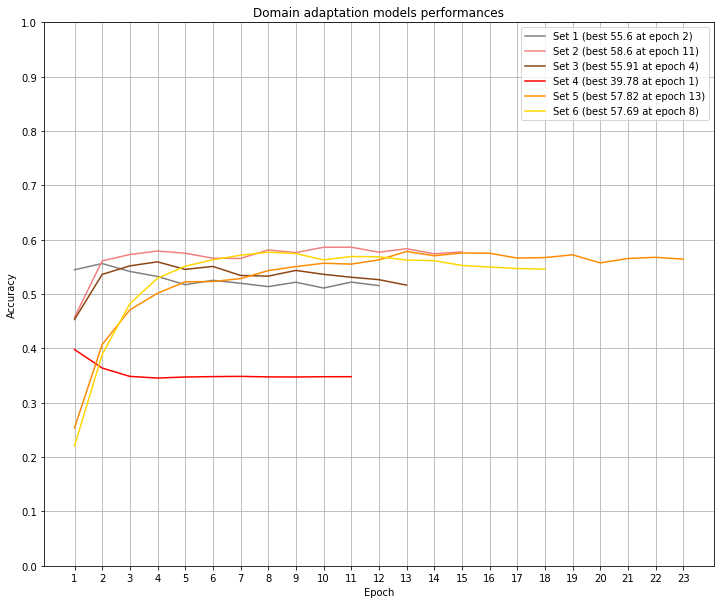

In [ ]:
# Domain Adaptation results

models_to_plot = [1, 2, 3, 4, 5, 6]


colorlist = ['black', 'gray', 'lightcoral', 
'saddlebrown', 'red', 'darkorange', 
'gold', 'olivedrab', 'lime', 
'turquoise', 'dodgerblue', 'darkslateblue',
'blueviolet', 'violet', 'yellow']

curves = []

for i in models_to_plot: 
  
  prefix = str(i)

  _, _, _, _, _, _, _, _, val_accuracy, _, main_checkpoints = load_da_checkpoint(prefix)

  best_acc = max(val_accuracy)
  best_epoch = val_accuracy.index(best_acc)+1

  label = f"Set {i} (best {(best_acc // 0.0001)/100} at epoch {best_epoch})"

  screenshot = {'x': range(1, len(val_accuracy)+1), 'y': val_accuracy, 
                'label': label, 'color': colorlist[i]}

  curves.append(screenshot)


big_plot(curves, "Domain adaptation models performances")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Restored checkpoint at epoch: 14
Restored checkpoint at epoch: 17
Restored checkpoint at epoch: 12
Restored checkpoint at epoch: 9
Restored checkpoint at epoch: 40
Restored checkpoint at epoch: 40


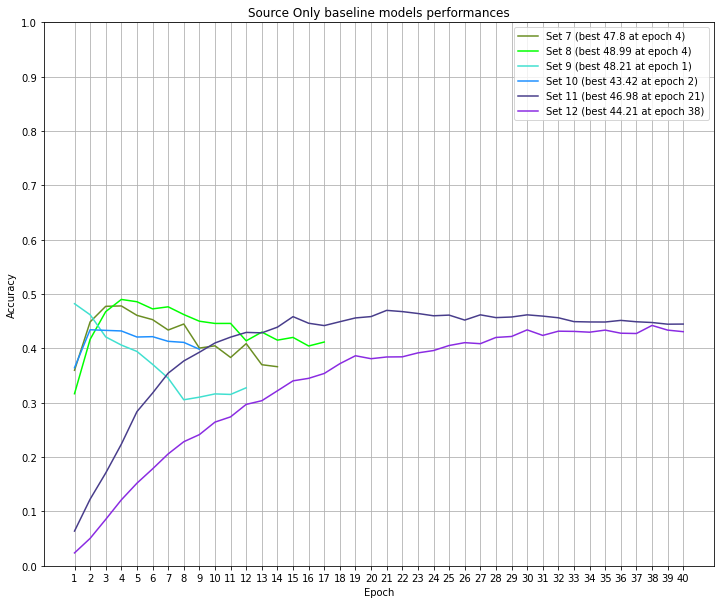

In [ ]:
# Source only baseline results

models_to_plot = [7, 8, 9, 10, 11, 12]


colorlist = ['black', 'gray', 'lightcoral', 
'saddlebrown', 'red', 'darkorange', 
'gold', 'olivedrab', 'lime', 
'turquoise', 'dodgerblue', 'darkslateblue',
'blueviolet', 'violet', 'yellow']

curves = []

for i in models_to_plot: 

  prefix = str(i)
  _, _, _, _, _, _, val_accuracy, _, main_checkpoints = load_so_checkpoint(prefix=prefix)

  best_acc = max(val_accuracy)
  best_epoch = val_accuracy.index(best_acc)+1

  label = f"Set {i} (best {(best_acc // 0.0001)/100} at epoch {best_epoch})"

  screenshot = {'x': range(1, len(val_accuracy)+1), 'y': val_accuracy, 
                'label': label, 'color': colorlist[i]}

  curves.append(screenshot)

  #print(f"Checkpoint {prefix} accuracies:")
  #simple_plot(range(1, len(val_accuracy)+1), val_accuracy, f"Accuracy of hyperparameters set {prefix} (best {best_acc} at epoch {best_epoch})", "Epoch", "Accuracy")
  #print()

big_plot(curves, "Source Only baseline models performances")

In [ ]:
from MLDL_RGBD_project.FeatureVisualization import FeatureVisualization

In [ ]:
visualizer = FeatureVisualization()
stratific = source_dataloarder.dataset.get_stratification()
src_rgb_samples, src_depth_samples = source_dataloarder.dataset.sample_images(stratific, n_samples=250)
tgt_rgb_samples, tgt_depth_samples = test_target_dataloarder.dataset.sample_images(stratific, n_samples=250)

In [ ]:
# Extract source-only best model
_, _, _, _, _, _, _, _, so_checkpoints = load_so_checkpoint(prefix="8")
checkpoint = so_checkpoints[0]
so_extractor = checkpoint['Extractor']
so_classifier = checkpoint['mainTask']
# Extract source features
plottable_so_source = visualizer.features_2d(src_rgb_samples, src_depth_samples, so_extractor, so_classifier)
# Extract target features
plottable_so_target = visualizer.features_2d(tgt_rgb_samples, tgt_depth_samples, so_extractor, so_classifier)

# Domain Adaptation best model
_, _, _, _, _, _, _, _, _, _, da_checkpoints = load_da_checkpoint(prefix="2")
checkpoint = da_checkpoints[0]
da_extractor = checkpoint['Extractor']
da_classifier = checkpoint['mainTask']
# Extract source features
plottable_da_source = visualizer.features_2d(src_rgb_samples, src_depth_samples, da_extractor, da_classifier)
# Extract target features
plottable_da_target = visualizer.features_2d(tgt_rgb_samples, tgt_depth_samples, da_extractor, da_classifier)


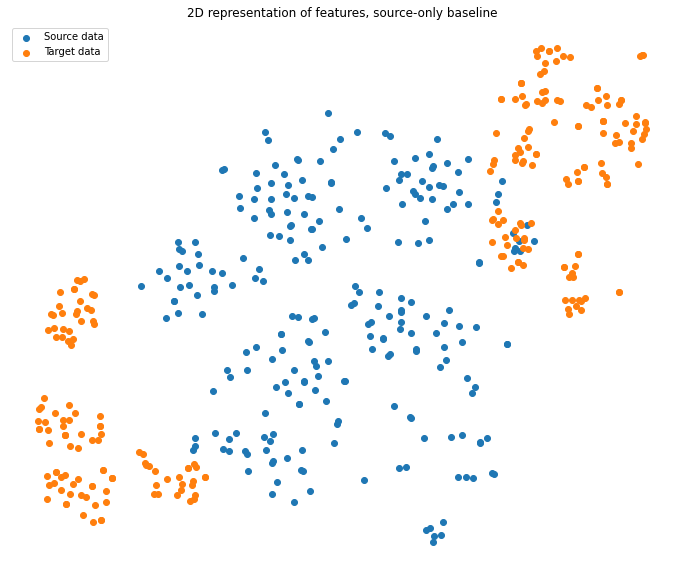

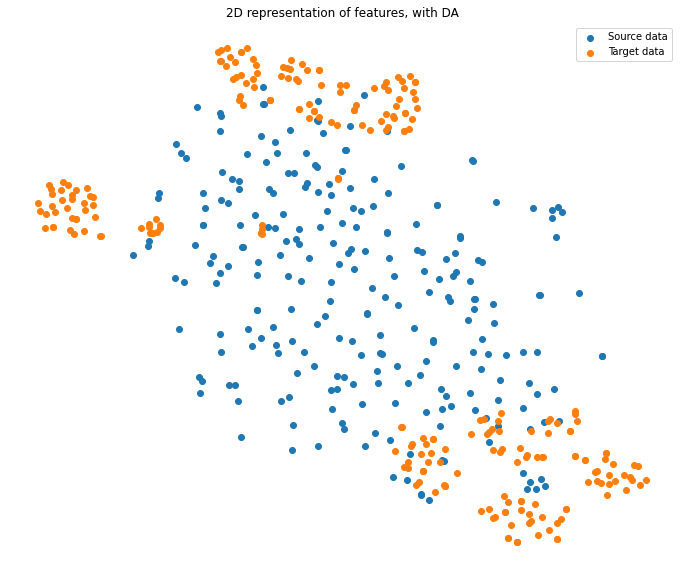

In [ ]:
# Plot the results

# Source-only
fig, ax = plt.subplots(figsize=(12,10))
plt.axis('off')
plt.title("2D representation of features, source-only baseline")
ax.scatter(plottable_so_source[:,0], plottable_so_source[:,1], label="Source data")
ax.scatter(plottable_so_target[:,0], plottable_so_target[:,1], label="Target data")
ax.legend()
plt.show()

# DA
fig, ax = plt.subplots(figsize=(12,10))
plt.axis('off')
plt.title("2D representation of features, with DA")
ax.scatter(plottable_da_source[:,0], plottable_da_source[:,1], label="Source data")
ax.scatter(plottable_da_target[:,0], plottable_da_target[:,1], label="Target data")
ax.legend()
plt.show()

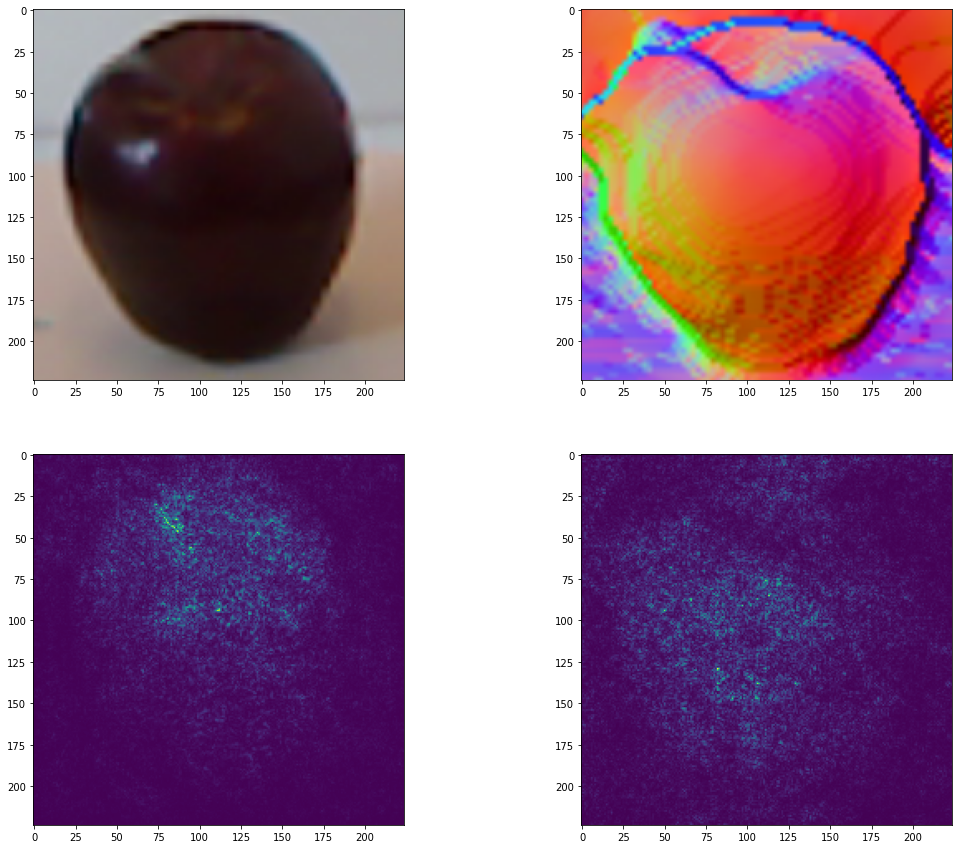

In [ ]:
(rgb_batch, depth_batch), _ = iter(test_target_dataloarder).next()

visualizer.saliency_maps(rgb_batch[0].to(DEVICE), depth_batch[0].to(DEVICE), da_extractor, da_classifier)

**--- VARIATION ---**


**Variation implementation**

Setup:

In [ ]:
# select which variation to apply:
second_variation = SECOND_VARIATION
# False --> do the first experiment: guess if it's the same permut for both images
# True --> do the second experiment: guess which permut was applied to both

if second_variation == False:
  num_cl = 1
  print("Model set up for first variation")
else:
  num_cl = 6
  prefix = str(prefix) + "bis"
  print("Model set up for second variation")

Model set up for first variation


In [ ]:
Extractor = FeatureExtractor().to(DEVICE)
mainTask = MainTask().to(DEVICE)
preText = PreText_variation(num_classes=num_cl).to(DEVICE)

extractor_opt = optim.SGD(Extractor.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
mainTask_opt = optim.SGD(mainTask.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
preText_opt = optim.SGD(preText.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


**Define checkpoint methods**

In [ ]:
"""
v_checkpoint = {'Extractor': Extractor,
                'mainTask': mainTask,
                'preText': preText,
          'Extractor_state_dict': Extractor.state_dict(),
          'mainTask_state_dict': mainTask.state_dict(),
          'preText_state_dict': preText.state_dict(),
                'extractor_opt': extractor_opt,
                'mainTask_opt': mainTask_opt,
                'preText_opt': preText_opt,
          'Extractor_optimizer' : extractor_opt.state_dict(),
          'mainTask_optimizer' : mainTask_opt.state_dict(),
          'preText_optimizer' : preText_opt.state_dict(),
                'epoch': epoch,
                'lossesLists': lossesLists,
                'val_accuracy' : val_accuracy,
                'additional_data': additional_data,
                'main_checkpoints': main_checkpoints}
"""

DRIVEPATH = "/content/drive/My Drive/"
LOCALPATH = "/content/checkpoints/"
V_CHECKPOINT = "v_checkpoint.pth"

# Function loading a checkpoint
def load_v_checkpoint(prefix=""):

  if not os.path.isdir("/content/checkpoints"): # create destination
    !mkdir /content/checkpoints
  
  if os.path.exists(DRIVEPATH+str(prefix)+V_CHECKPOINT) and os.path.isfile(DRIVEPATH+str(prefix)+V_CHECKPOINT): # if f existst and is a file
    shutil.copyfile(DRIVEPATH+str(prefix)+V_CHECKPOINT, LOCALPATH+str(prefix)+V_CHECKPOINT)                     # copy it locally
  else:
    sys.exit(-1)
  
  checkpoint = torch.load(LOCALPATH+str(prefix)+V_CHECKPOINT)                                        # load it from local copy

  Extractor = checkpoint['Extractor']
  mainTask = checkpoint['mainTask']
  preText = checkpoint['preText']
  extractor_opt = checkpoint['extractor_opt']
  mainTask_opt = checkpoint['mainTask_opt']
  preText_opt = checkpoint['preText_opt']

  Extractor.load_state_dict(checkpoint['Extractor_state_dict'])
  mainTask.load_state_dict(checkpoint['mainTask_state_dict'])
  preText.load_state_dict(checkpoint['preText_state_dict'])
  extractor_opt.load_state_dict(checkpoint['Extractor_optimizer'])
  mainTask_opt.load_state_dict(checkpoint['mainTask_optimizer'])
  preText_opt.load_state_dict(checkpoint['preText_optimizer'])

  print(f"Restored checkpoint at epoch: {checkpoint['epoch']}")

  return Extractor, mainTask, preText, extractor_opt, mainTask_opt, preText_opt,\
         checkpoint['epoch'], checkpoint['lossesLists'], checkpoint['val_accuracy'], checkpoint['additional_data'], checkpoint['main_checkpoints']


def save_v_checkpoint(checkpoint, prefix=""):

  if not os.path.isdir("/content/checkpoints"): # create source
    !mkdir /content/checkpoints                 
    
  torch.save(checkpoint, LOCALPATH+str(prefix)+V_CHECKPOINT)

  if os.path.exists(DRIVEPATH): # if f existst and is a file
    shutil.copyfile(LOCALPATH+str(prefix)+V_CHECKPOINT, DRIVEPATH+str(prefix)+V_CHECKPOINT) # copy it locally
    print("Checkpoint saved")
  else:
    sys.exit(-1)



Load a checkpoint

In [ ]:
# this is use for the back up
# WARNING: run this block only if you want to load the saved parameters (OVERWRITES PREVIOUS CELLS)
Extractor, mainTask, preText, extractor_opt, mainTask_opt, preText_opt, ELAPSED_DA_EPOCHS, lossesLists,\
                                            val_accuracy, additional_data, main_checkpoints = load_v_checkpoint(prefix=prefix)
V_RESTORED = True

Restored checkpoint at epoch: 8


Train:

In [ ]:
# Losses
mainTask_criterion = nn.CrossEntropyLoss() # criterion Lm
if second_variation == False:
  preText_criterion = nn.BCEWithLogitsLoss()  # criterion Lp
else:
  preText_criterion = nn.CrossEntropyLoss()  # criterion Lp

# 
# Entropy loss for the target on main task
def tgt_main_criterion(logits):
    p_softmax = F.softmax(logits, dim=1)
    mask = p_softmax.ge(0.000001)  # greater or equal to, used for numerical stability
    mask_out = torch.masked_select(p_softmax, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(p_softmax.size(0))

In [ ]:
import PIL
from PIL import Image
start_time = time.time()
 
cudnn.benchmark                                    # Calling this optimizes runtime
 
if V_RESTORED:                                    # if a checkpoint was loaded
  Src_mainLoss = lossesLists[0]                       # restore the previous losses lists
  tgt_mainLoss = lossesLists[1]
  Src_rotateLoss = lossesLists[2]
  tgt_rotateLoss = lossesLists[3]
  epochs_no_improve = additional_data[0]
  min_val_loss = additional_data[1]
  best_epoch = additional_data[2]
  # val_accuracy is already restored
  # main_checkpoints is already restored
else:                                              # otherwise use some new ones
  Src_mainLoss = []
  tgt_mainLoss = []
  Src_rotateLoss = []
  tgt_rotateLoss = []
  val_accuracy = []
  epochs_no_improve = 0
  min_val_loss = np.Inf
  best_epoch = 0
  main_checkpoints = []
 
 
n_epochs_stop = EARLY_STOP_VAL
flag_stop = False
epoch = ELAPSED_DA_EPOCHS + 1

while epoch <= NUM_EPOCHS:
  if flag_stop == True:
    break
  print('Starting epoch {}/{}'.format(epoch , NUM_EPOCHS))
 
  # Data loaders:
  source_rotated_dataloader,target_rotated_dataloader = get_permuted_dataLoader(data_synRODrgb,\
                                                    data_synRODdepth, data_RODrgb, data_RODdepth, second_variation)
  
  torch.cuda.empty_cache()
  Extractor.train(True)                                 # set in training mode
  mainTask.train(True)                                  # set in training mode
  preText.train(True)                                   # set in training mode
 
  cumsum_mainloss = 0
  cumsum_T_mainloss = 0
  cumsum_Trloss = 0
  cumsum_Srloss = 0
  current_step = 0
 
  # Work on 3 batches in parallel
  for S, T, Sr, Tr in zip(source_dataloarder, train_target_dataloarder, source_rotated_dataloader, target_rotated_dataloader):
 
    # Forward pass - Source:
    (S_rgb_image, S_depth_image), S_label = S                 # load Source batch
 
    S_rgb_batch = S_rgb_image.to(DEVICE)                      # bring data over device
    S_depth_batch = S_depth_image.to(DEVICE)                  # bring data over device
    S_label = S_label.to(DEVICE)                              # bring label over device
 
    S_features = Extractor.forward(S_rgb_batch, S_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask.forward(S_features)                 # main task forward pass
    S_main_loss = mainTask_criterion(outPuts_main, S_label)       # compute main loss
    cumsum_mainloss += S_main_loss.item()*len(S_rgb_image)        # loss for all the images in S_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE --> Step {}, Loss {}'.format(current_step, S_main_loss.item()))
 
 
 
    # Forward pass - Target:
    (T_rgb_image, T_depth_image), T_label = T                 # load Source batch
 
    T_rgb_batch = T_rgb_image.to(DEVICE)                      # bring data over device
    T_depth_batch = T_depth_image.to(DEVICE)                  # bring data over device
                                                              # DON'T use the labels
 
    T_features = Extractor.forward(T_rgb_batch, T_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask.forward(T_features)                 # main task forward pass
    T_main_loss = tgt_main_criterion(outPuts_main)              # compute main loss of Target on MainTask
    cumsum_T_mainloss += T_main_loss.item()*len(T_rgb_image)           # loss for all the images in T_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('TARGET --> Step {}, Loss {}'.format(current_step, T_main_loss.item()))
 
 
 
    # Forward pass - Source permutated
    (Sr_rgb_image, Sr_depth_image), Sr_label = Sr               # load Source rotated batch

    Sr_rgb_batch = Sr_rgb_image.to(DEVICE)                      # bring data over device
    Sr_depth_batch = Sr_depth_image.to(DEVICE)                  # bring data over device
    Sr_label = Sr_label.to(DEVICE)                              # bring label over device
 
    Sr_features = Extractor.forward(Sr_rgb_batch, Sr_depth_batch)  # Forward pass (feature extractor)
    out_preText = preText.forward(Sr_features)                     # preText task forward pass

    if second_variation == False:
      out_preText = out_preText[:, 0]                                # reshape it from [64,1] to [64] for BCELoss
      #Sr_loss = preText_criterion(out_preText, Sr_label)         # compute aux loss 
      Sr_loss = preText_criterion(torch.tensor(out_preText, dtype=torch.float32), torch.tensor(Sr_label, dtype=torch.float32))
      #Sr_loss = preText_criterion(torch.tensor(torch.argmax(out_preText, axis=1), dtype=torch.float32), torch.tensor(Sr_label, dtype=torch.float32))
    else:
      Sr_loss = preText_criterion(out_preText, Sr_label)

    cumsum_Srloss += Sr_loss.item()*len(Sr_rgb_image)              # loss for all the images in Sr_rgb_image
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE PERM --> Step {}, Loss {}'.format(current_step, Sr_loss.item()))
 
 
 
    # Forward pass - Target rotated
    (Tr_rgb_image, Tr_depth_image), Tr_label = Tr               # load Source rotated batch
 
    Tr_rgb_batch = Tr_rgb_image.to(DEVICE)                      # bring data over device
    Tr_depth_batch = Tr_depth_image.to(DEVICE)                  # bring data over device
    Tr_label = Tr_label.to(DEVICE)                              # bring the label to device 
 
    Tr_features = Extractor.forward(Tr_rgb_batch, Tr_depth_batch)  # Forward pass (feature extractor)
    out_preText = preText.forward(Tr_features)                     # preText task forward pass

    if second_variation == False:
      out_preText = out_preText[:, 0]                                # reshape it from [64,1] to [64] for BCELoss
      Tr_loss = preText_criterion(torch.tensor(out_preText, dtype=torch.float32), torch.tensor(Tr_label, dtype=torch.float32))
      #Tr_loss = preText_criterion(out_preText.argmax(axis=1), Tr_label)                   # compute aux loss (entropy loss)
    #Tr_loss = preText_criterion(torch.tensor(torch.argmax(out_preText, axis=1), dtype=torch.float32), torch.tensor(Tr_label, dtype=torch.float32))
    else:
      Tr_loss = preText_criterion(out_preText, Tr_label)

    cumsum_Trloss += Tr_loss.item()*len(Tr_rgb_image)              # loss for all the images in Tr_rgb_image
 
    if current_step % LOG_FREQUENCY == 0:
      print('TARGET PERM --> Step {}, Loss {}'.format(current_step, Tr_loss.item()))
 
 
    # computing final loss
    final_loss = S_main_loss + LAMBDA1 * (Sr_loss +  Tr_loss) + LAMBDA2 * T_main_loss
 
    if current_step % LOG_FREQUENCY == 0:
      print('TOTAL LOSS --> Step {}, Loss {}'.format(current_step, final_loss.item()))
      print()
 
    # final steps
    Extractor.zero_grad()             # Zero-ing the gradients
    mainTask.zero_grad()              # Zero-ing the gradients
    preText.zero_grad()               # Zero-ing the gradients
 
    final_loss.backward()             # backward pass: computes gradients for the net
 
    preText_opt.step()                # update weights for pretext
    extractor_opt.step()              # update weights for extractor
    mainTask_opt.step()               # update the weights of the only maintask
 
    current_step += 1
  
 
  #list of losses for the source dataset over the main classifier for later visualization
  Src_mainLoss.append(cumsum_mainloss / float(len(source_dataloarder.dataset))) 
  tgt_mainLoss.append(cumsum_T_mainloss / float(len(train_target_dataloarder.dataset))) 
  Src_rotateLoss.append(cumsum_Srloss / float(len( source_rotated_dataloader.dataset)))
  tgt_rotateLoss.append(cumsum_Trloss / float(len(target_rotated_dataloader.dataset)))
 
 
  # each 5 epochs do a complete validation/test phase on the target dataset
  #otherwise do it on 100 batches only for all the other epochs
  """big_test = False
  if epoch != 0 and epoch % 5 == 0:
    big_test = True"""
  # Not entirely representative of the actual performance in quick validations. Let's do a complete one each epoch
  big_test = True
 
  loss , acc = validation_test(Extractor, mainTask, test_target_dataloarder, mainTask_criterion, test_phase = big_test)
  val_accuracy.append(acc)
  print(f"\nVALIDATION ACCURACY: {acc}")
  print(f"VALIDATION Loss: {loss}")
 
 
  # early stopping criterion
  if loss < min_val_loss:       # if there was an improvement in the loss --> reset counter
    epochs_no_improve = 0
    min_val_loss = loss
    best_epoch = epoch
  else:                       # Otherwise increment count of epochs with no improvement
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve >= n_epochs_stop:
      print(f'\nEarly stopping! at epoch {epoch}.\n The best epoch is epoch {best_epoch}')
      flag_stop = True
 
 
  # save the model at each epoch end
  lossesLists = [Src_mainLoss, tgt_mainLoss, Src_rotateLoss, tgt_rotateLoss] # list of losses lists
  additional_data = [epochs_no_improve, min_val_loss, best_epoch]            # list of important params to save
  
  checkpoint = {'Extractor': Extractor,
                'mainTask': mainTask,
                'preText': preText,
          'Extractor_state_dict': Extractor.state_dict(),
          'mainTask_state_dict': mainTask.state_dict(),
          'preText_state_dict': preText.state_dict(),
                'extractor_opt': extractor_opt,
                'mainTask_opt': mainTask_opt,
                'preText_opt': preText_opt,
          'Extractor_optimizer' : extractor_opt.state_dict(),
          'mainTask_optimizer' : mainTask_opt.state_dict(),
          'preText_optimizer' : preText_opt.state_dict(),
                'epoch': epoch,
                'lossesLists': lossesLists,
                'val_accuracy' : val_accuracy,
                'additional_data': additional_data,
                'main_checkpoints': main_checkpoints}
 
  if epoch != 0 and epoch % 5 == 0:
    # each 5 epochs save the checkpoint in the main checkpoints list
    main_checkpoint = dict()  # create an independent copy
    for k in checkpoint:
      if k != 'main_checkpoints': # clear this for memory purposes
        main_checkpoint[k] = checkpoint[k]
      else:
        main_checkpoint[k] = None

    checkpoint['main_checkpoints'].append(main_checkpoint)
 
  save_v_checkpoint(checkpoint, prefix=prefix)
  
  # save the checkpoint
  
  exec_time = time.time() - start_time
  mins = int(exec_time // 60)
  secs = int(exec_time % 60)
  print(f"--- Elapsed time from trainig start (eventual checkpoint restoration excluded): {mins} minutes and {secs} seconds ---\n")
  epoch +=1
  # --- epoch end ---

Results

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Restored checkpoint at epoch: 13


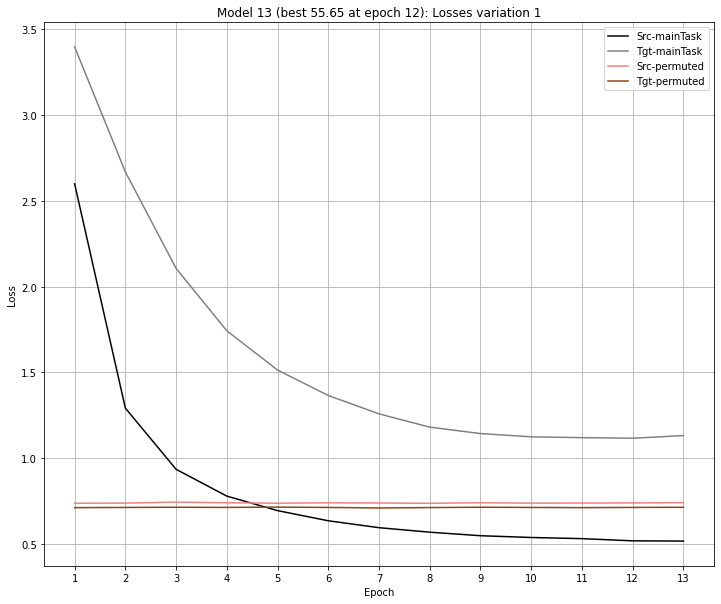

Restored checkpoint at epoch: 13


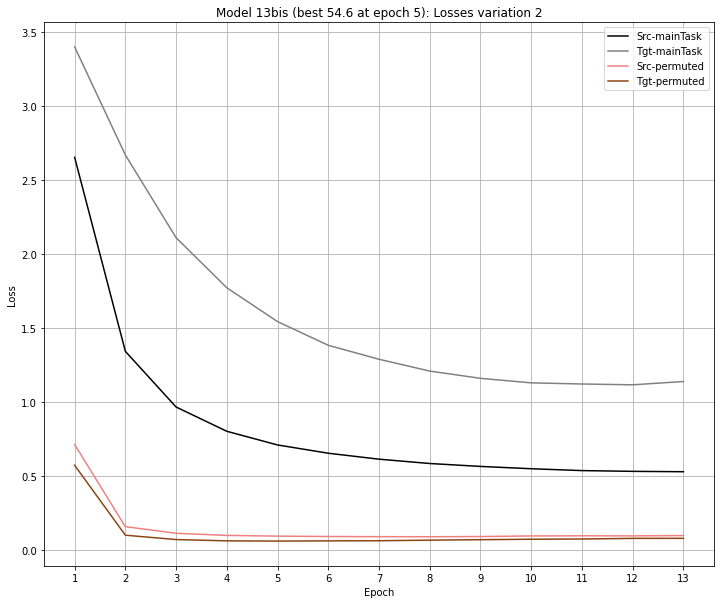

Restored checkpoint at epoch: 14


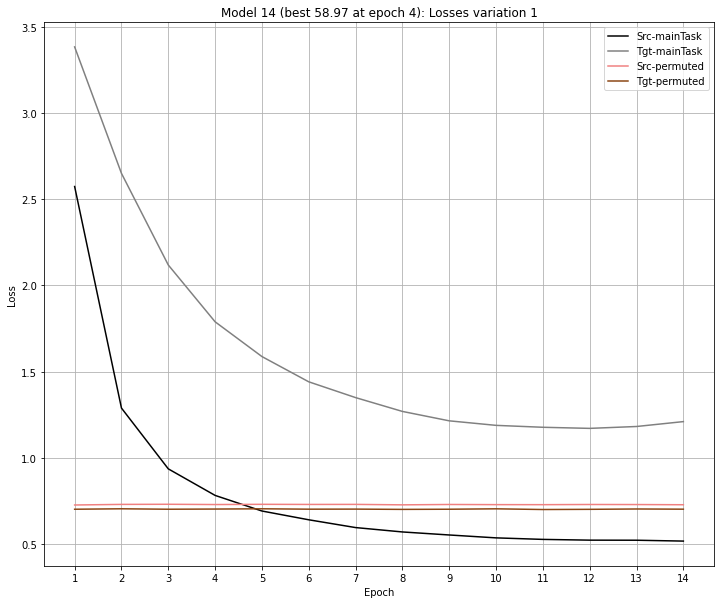

Restored checkpoint at epoch: 13


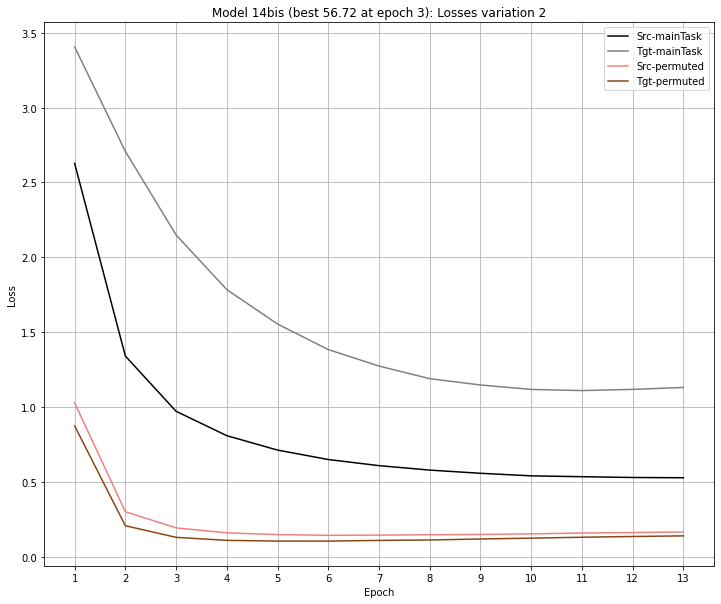

Restored checkpoint at epoch: 14


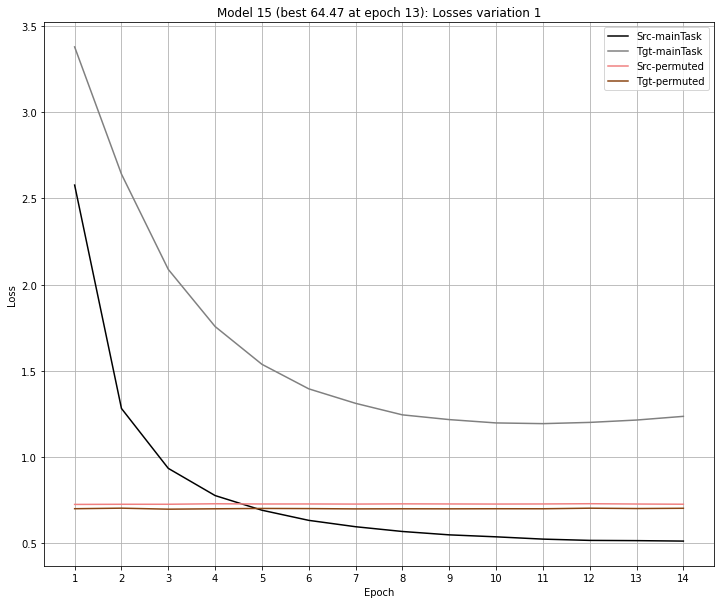

Restored checkpoint at epoch: 24


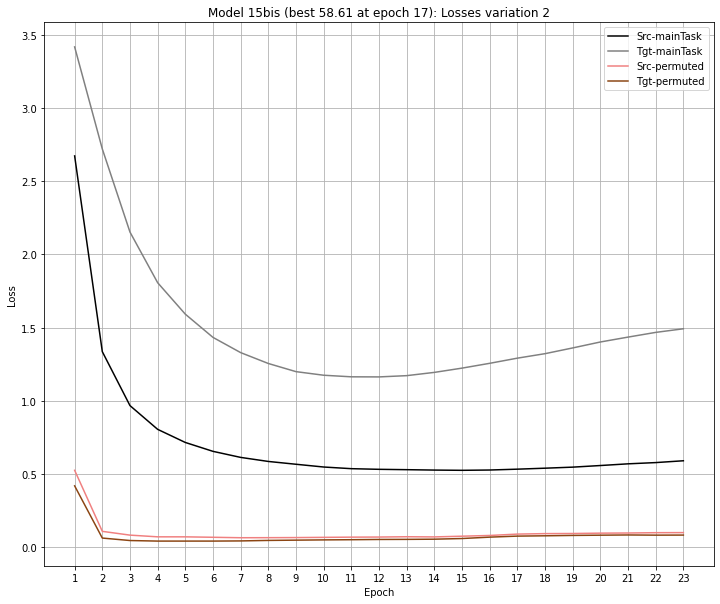

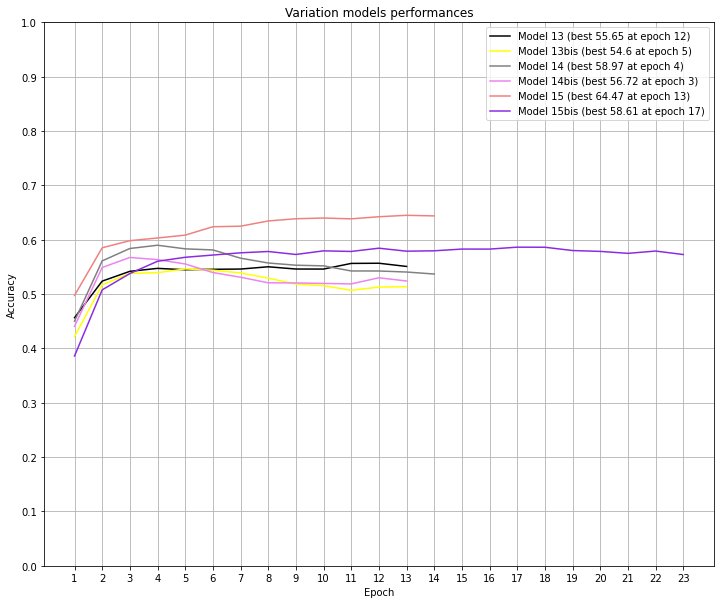

In [ ]:
# Variation results

models_to_plot = [13,14,15] 


colorlist = ['black', 'gray', 'lightcoral', 
'saddlebrown', 'red', 'darkorange', 
'gold', 'olivedrab', 'lime', 
'turquoise', 'dodgerblue', 'darkslateblue',
'blueviolet', 'violet', 'yellow']

curves = []

for i in models_to_plot: 
  
  #standard variation (1)
  prefix = str(i)

  _, _, _, _, _, _, _, lossesList1, val_accuracy, _, main_checkpoints = load_v_checkpoint(prefix)

  best_acc = max(val_accuracy)
  best_epoch = val_accuracy.index(best_acc)+1

  label = f"Model {i} (best {(best_acc // 0.0001)/100} at epoch {best_epoch})"

  screenshot = {'x': range(1, len(val_accuracy)+1), 'y': val_accuracy, 
                'label': label, 'color': colorlist[i - min(models_to_plot)]}

  curves.append(screenshot)

  #lossesLists = [Src_mainLoss, tgt_mainLoss, Src_rotateLoss, tgt_rotateLoss]
  # losses of variation 1
  text = label
  losses = list()

  labls = ['Src-mainTask', 'Tgt-mainTask', 'Src-permuted','Tgt-permuted']
  c = 0
  for l in lossesList1:

    label = labls[c]

    screenshot = {'x': range(1, len(l)+1), 'y': l, 
                  'label': label, 'color': colorlist[c]}

    losses.append(screenshot)

    c += 1
  big_plot(losses, f"{text}: Losses variation 1", "Loss")


  #second variation (2)
  prefix = prefix + 'bis'

  _, _, _, _, _, _, _, lossesList2, val_accuracy, _, main_checkpoints = load_v_checkpoint(prefix)

  best_acc = max(val_accuracy)
  best_epoch = val_accuracy.index(best_acc)+1

  label = f"Model {prefix} (best {(best_acc // 0.0001)/100} at epoch {best_epoch})"

  screenshot = {'x': range(1, len(val_accuracy)+1), 'y': val_accuracy, 
                'label': label, 'color': colorlist[len(colorlist)-1-(i - min(models_to_plot))]}

  curves.append(screenshot)

  #lossesLists = [Src_mainLoss, tgt_mainLoss, Src_rotateLoss, tgt_rotateLoss]
  # losses of variation 2
  text = label
  losses = list()

  labls = ['Src-mainTask', 'Tgt-mainTask', 'Src-permuted','Tgt-permuted']
  c = 0
  for l in lossesList2:

    label = labls[c]

    screenshot = {'x': range(1, len(l)+1), 'y': l, 
                  'label': label, 'color': colorlist[c]}

    losses.append(screenshot)

    c += 1
  big_plot(losses, f"{text}: Losses variation 2", "Loss")

big_plot(curves, "Variation models performances")


commented_stuff = """#lossesLists = [Src_mainLoss, tgt_mainLoss, Src_rotateLoss, tgt_rotateLoss]
# losses of variation 1
losses = list()

labls = ['Src-mainTask', 'Tgt-mainTask', 'Src-permuted','Tgt-permuted']
c = 0
for l in lossesList1:

  label = labls[c]

  screenshot = {'x': range(1, len(l)+1), 'y': l, 
                'label': label, 'color': colorlist[c]}

  losses.append(screenshot)

  c += 1
#big_plot(losses, "Losses variation 1", "Loss")



#lossesLists = [Src_mainLoss, tgt_mainLoss, Src_rotateLoss, tgt_rotateLoss]
# losses of variation 2
losses = list()

labls = ['Src-mainTask', 'Tgt-mainTask', 'Src-permuted','Tgt-permuted']
c = 0
for l in lossesList2:

  label = labls[c]

  screenshot = {'x': range(1, len(l)+1), 'y': l, 
                'label': label, 'color': colorlist[c]}

  losses.append(screenshot)

  c += 1
#big_plot(losses, "Losses variation 2", "Loss")"""

**Variation 1 - further experiments**

In [ ]:
def pretext_test(extractor, maintask, dataloader, criterion, test_phase):
  # i perform the model evaluation after each epoch
  running_corrects = 0
  loss_val = 0.0
  extractor.eval()
  maintask.eval()
  batch_n = 0

  with torch.no_grad():
    for (rgb, depth), labels in tqdm(dataloader):
      batch_n += 1
      rgb = rgb.to(DEVICE)
      depth = depth.to(DEVICE)
      labels = labels.to(DEVICE)
      #make predictions
      features = extractor.forward(rgb, depth)
      outputs = maintask.forward(features)
      outputs = outputs[:, 0]                                # reshape it from [64,1] to [64] for BCELoss
      print(outputs.shape)
      Tr_loss = criterion(torch.tensor(outputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32))
      #get the validation loss for each batch
      loss_val += Tr_loss.item()*len(rgb)
      # Get predictions
      preds = (outputs)   
      mask = (preds > 0) # i.e. sigmoid(preds) > 0.5
      preds[mask] = 1
      preds[~mask] = 0
      preds = torch.tensor(preds)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()
      # stop at batch number 100 if test_phase = True
      if batch_n == NUM_BATCHES_LIMITED and test_phase == False:
        break

  if test_phase == False:
    length = NUM_BATCHES_LIMITED*BATCH_SIZE
  else:
    length = len(dataloader.dataset)
  
  return float(loss_val)/ float(length), float(running_corrects)/ float(length)

In [ ]:
import PIL
from PIL import Image
start_time = time.time()
 
Extractor = FeatureExtractor().to(DEVICE)
mainTask = MainTask().to(DEVICE)
preText = PreText_variation(num_classes=1).to(DEVICE)

extractor_opt = optim.SGD(Extractor.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
mainTask_opt = optim.SGD(mainTask.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)
preText_opt = optim.SGD(preText.parameters(), lr = LR, momentum = MOMENTUM, weight_decay=WEIGHT_DECAY)

cudnn.benchmark                                    # Calling this optimizes runtime
 
Src_mainLoss = []
tgt_mainLoss = []
Src_rotateLoss = []
tgt_rotateLoss = []
val_accuracy = []
epochs_no_improve = 0
min_val_loss = np.Inf
best_epoch = 0

big_test = True
n_epochs_stop = EARLY_STOP_VAL
flag_stop = False
epoch = ELAPSED_DA_EPOCHS + 1

# Evaluate initial level of the model
# main task
_, acc1 = validation_test(Extractor, mainTask, test_target_dataloarder, mainTask_criterion, test_phase = big_test)
# pretext task
source_permuted_dataloader,target_permuted_dataloader = get_permuted_dataLoader(data_synRODrgb,\
                                                    data_synRODdepth, data_RODrgb, data_RODdepth, second_variation)
loss , acc = pretext_test(Extractor, preText, target_permuted_dataloader, preText_criterion, test_phase = big_test)
# print
print(f"Initial main task accuracy on target, without any training: {acc1}")
print(f"Initial pretext task accuracy on target: {acc}\nInitial loss value for it: {loss}")
ptx_losses = [loss]
ptx_acc = [acc]

while epoch <= NUM_EPOCHS:
  if flag_stop == True:
    break
  print('Starting epoch {}/{}'.format(epoch , NUM_EPOCHS))
 
  # Data loaders:
  source_rotated_dataloader,target_rotated_dataloader = get_permuted_dataLoader(data_synRODrgb,\
                                                    data_synRODdepth, data_RODrgb, data_RODdepth, second_variation)
  
  torch.cuda.empty_cache()
  Extractor.train(True)                                 # set in training mode
  mainTask.train(True)                                  # set in training mode
  preText.train(True)                                   # set in training mode
 
  cumsum_mainloss = 0
  cumsum_T_mainloss = 0
  cumsum_Trloss = 0
  cumsum_Srloss = 0
  current_step = 0
 
  # Work on 3 batches in parallel
  for S, T, Sr, Tr in zip(source_dataloarder, train_target_dataloarder, source_rotated_dataloader, target_rotated_dataloader):
 
    # Forward pass - Source:
    (S_rgb_image, S_depth_image), S_label = S                 # load Source batch
 
    S_rgb_batch = S_rgb_image.to(DEVICE)                      # bring data over device
    S_depth_batch = S_depth_image.to(DEVICE)                  # bring data over device
    S_label = S_label.to(DEVICE)                              # bring label over device
 
    S_features = Extractor.forward(S_rgb_batch, S_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask.forward(S_features)                 # main task forward pass
    S_main_loss = mainTask_criterion(outPuts_main, S_label)       # compute main loss
    cumsum_mainloss += S_main_loss.item()*len(S_rgb_image)        # loss for all the images in S_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE --> Step {}, Loss {}'.format(current_step, S_main_loss.item()))
 
 
 
    # Forward pass - Target:
    (T_rgb_image, T_depth_image), T_label = T                 # load Source batch
 
    T_rgb_batch = T_rgb_image.to(DEVICE)                      # bring data over device
    T_depth_batch = T_depth_image.to(DEVICE)                  # bring data over device
                                                              # DON'T use the labels
 
    T_features = Extractor.forward(T_rgb_batch, T_depth_batch)  # Forward pass (feature extractor)
    outPuts_main = mainTask.forward(T_features)                 # main task forward pass
    T_main_loss = tgt_main_criterion(outPuts_main)              # compute main loss of Target on MainTask
    cumsum_T_mainloss += T_main_loss.item()*len(T_rgb_image)           # loss for all the images in T_rgb_image 
 
    if current_step % LOG_FREQUENCY == 0:
      print('TARGET --> Step {}, Loss {}'.format(current_step, T_main_loss.item()))
 
 
 
    # Forward pass - Source rotated
    (Sr_rgb_image, Sr_depth_image), Sr_label = Sr               # load Source rotated batch

    Sr_rgb_batch = Sr_rgb_image.to(DEVICE)                      # bring data over device
    Sr_depth_batch = Sr_depth_image.to(DEVICE)                  # bring data over device
    Sr_label = Sr_label.to(DEVICE)                              # bring label over device
 
    Sr_features = Extractor.forward(Sr_rgb_batch, Sr_depth_batch)  # Forward pass (feature extractor)
    out_preText = preText.forward(Sr_features)                     # preText task forward pass

    out_preText = out_preText[:, 0]                                # reshape it from [64,1] to [64] for BCELoss
    #Sr_loss = preText_criterion(out_preText, Sr_label)         # compute aux loss 
    Sr_loss = preText_criterion(torch.tensor(out_preText, dtype=torch.float32), torch.tensor(Sr_label, dtype=torch.float32))
    #Sr_loss = preText_criterion(torch.tensor(torch.argmax(out_preText, axis=1), dtype=torch.float32), torch.tensor(Sr_label, dtype=torch.float32))

    cumsum_Srloss += Sr_loss.item()*len(Sr_rgb_image)              # loss for all the images in Sr_rgb_image
 
    if current_step % LOG_FREQUENCY == 0:
      print('SOURCE PERM --> Step {}, Loss {}'.format(current_step, Sr_loss.item()))
 
 
 
    # Forward pass - Target rotated
    (Tr_rgb_image, Tr_depth_image), Tr_label = Tr               # load Source rotated batch
 
    Tr_rgb_batch = Tr_rgb_image.to(DEVICE)                      # bring data over device
    Tr_depth_batch = Tr_depth_image.to(DEVICE)                  # bring data over device
    Tr_label = Tr_label.to(DEVICE)                              # bring the label to device 
 
    Tr_features = Extractor.forward(Tr_rgb_batch, Tr_depth_batch)  # Forward pass (feature extractor)
    out_preText = preText.forward(Tr_features)                     # preText task forward pass

    
    out_preText = out_preText[:, 0]                                # reshape it from [64,1] to [64] for BCELoss
    Tr_loss = preText_criterion(torch.tensor(out_preText, dtype=torch.float32), torch.tensor(Tr_label, dtype=torch.float32))

    cumsum_Trloss += Tr_loss.item()*len(Tr_rgb_image)              # loss for all the images in Tr_rgb_image
 
    print('TARGET PERM --> Step {}, Loss {}'.format(current_step, Tr_loss.item()))
    ptx_losses.append(Tr_loss.item())
 
    # computing final loss
    final_loss = S_main_loss + LAMBDA1 * (Sr_loss +  Tr_loss) + LAMBDA2 * T_main_loss
 
    if current_step % LOG_FREQUENCY == 0:
      print('TOTAL LOSS --> Step {}, Loss {}'.format(current_step, final_loss.item()))
      print()
 
    # final steps
    Extractor.zero_grad()             # Zero-ing the gradients
    mainTask.zero_grad()              # Zero-ing the gradients
    preText.zero_grad()               # Zero-ing the gradients
 
    final_loss.backward()             # backward pass: computes gradients for the net
 
    preText_opt.step()                # update weights for pretext
    extractor_opt.step()              # update weights for extractor
    mainTask_opt.step()               # update the weights of the only maintask
 
    current_step += 1
  
 
  #list of losses for the source dataset over the main classifier for later visualization
  Src_mainLoss.append(cumsum_mainloss / float(len(source_dataloarder.dataset))) 
  tgt_mainLoss.append(cumsum_T_mainloss / float(len(train_target_dataloarder.dataset))) 
  Src_rotateLoss.append(cumsum_Srloss / float(len( source_rotated_dataloader.dataset)))
  tgt_rotateLoss.append(cumsum_Trloss / float(len(target_rotated_dataloader.dataset)))
 
 
  # each 5 epochs do a complete validation/test phase on the target dataset
  #otherwise do it on 100 batches only for all the other epochs
  """big_test = False
  if epoch != 0 and epoch % 5 == 0:
    big_test = True"""
  # Not entirely representative of the actual performance in quick validations. Let's do a complete one each epoch
  big_test = True
 
  loss1 , acc1 = validation_test(Extractor, mainTask, test_target_dataloarder, mainTask_criterion, test_phase = big_test)
  val_accuracy.append(acc)

  loss , acc = pretext_test(Extractor, preText, target_permuted_dataloader, preText_criterion, test_phase = big_test)
  print(f"\nVALIDATION ACCURACY: {acc1}")
  print(f"VALIDATION Loss: {loss1}")
  print(f"PRETEXT ACCURACY: {acc}\n")
  ptx_acc.append(acc)
 
 
  # early stopping criterion
  if loss < min_val_loss:       # if there was an improvement in the loss --> reset counter
    epochs_no_improve = 0
    min_val_loss = loss
    best_epoch = epoch
  else:                       # Otherwise increment count of epochs with no improvement
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve >= n_epochs_stop:
      print(f'\nEarly stopping! at epoch {epoch}.\n The best epoch is epoch {best_epoch}')
      flag_stop = True
 
  exec_time = time.time() - start_time
  mins = int(exec_time // 60)
  secs = int(exec_time % 60)
  print(f"--- Elapsed time from trainig start (eventual checkpoint restoration excluded): {mins} minutes and {secs} seconds ---\n")
  epoch +=1
  # --- epoch end ---



  0%|          | 0/609 [00:00<?, ?it/s]

  0%|          | 1/609 [00:00<03:12,  3.16it/s]

  0%|          | 2/609 [00:00<03:11,  3.16it/s]

  0%|          | 3/609 [00:00<03:11,  3.17it/s]

  1%|          | 4/609 [00:01<03:10,  3.17it/s]

  1%|          | 5/609 [00:01<03:11,  3.16it/s]

  1%|          | 6/609 [00:01<03:09,  3.19it/s]

  1%|          | 7/609 [00:02<03:09,  3.18it/s]

  1%|▏         | 8/609 [00:02<03:08,  3.19it/s]

  1%|▏         | 9/609 [00:02<03:07,  3.19it/s]

  2%|▏         | 10/609 [00:03<03:04,  3.25it/s]

  2%|▏         | 11/609 [00:03<03:01,  3.29it/s]

  2%|▏         | 12/609 [00:03<02:58,  3.34it/s]

  2%|▏         | 13/609 [00:04<02:58,  3.34it/s]

  2%|▏         | 14/609 [00:04<02:56,  3.37it/s]

  2%|▏         | 15/609 [00:04<02:55,  3.39it/s]

  3%|▎         | 16/609 [00:04<02:54,  3.40it/s]

  3%|▎         | 17/609 [00:05<02:53,  3.40it/s]

  3%|▎         | 18/609 [00:05<02:53,  3.40it/s]

  3%|▎         | 19/609 [00:05<02:53,  3.39it/s]

  3%|▎         |

torch.Size([64])




  0%|          | 2/608 [00:00<04:20,  2.33it/s]

torch.Size([64])




  0%|          | 3/608 [00:01<04:16,  2.36it/s]

torch.Size([64])




  1%|          | 4/608 [00:01<04:11,  2.40it/s]

torch.Size([64])




  1%|          | 5/608 [00:02<04:14,  2.37it/s]

torch.Size([64])




  1%|          | 6/608 [00:02<04:11,  2.39it/s]

torch.Size([64])




  1%|          | 7/608 [00:02<04:08,  2.42it/s]

torch.Size([64])




  1%|▏         | 8/608 [00:03<04:07,  2.42it/s]

torch.Size([64])




  1%|▏         | 9/608 [00:03<04:06,  2.43it/s]

torch.Size([64])




  2%|▏         | 10/608 [00:04<03:57,  2.51it/s]

torch.Size([64])




  2%|▏         | 11/608 [00:04<03:57,  2.51it/s]

torch.Size([64])




  2%|▏         | 12/608 [00:04<03:58,  2.49it/s]

torch.Size([64])




  2%|▏         | 13/608 [00:05<03:51,  2.57it/s]

torch.Size([64])




  2%|▏         | 14/608 [00:05<03:50,  2.58it/s]

torch.Size([64])




  2%|▏         | 15/608 [00:06<03:49,  2.58it/s]

torch.Size([64])




  3%|▎         | 16/608 [00:06<03:50,  2.57it/s]

torch.Size([64])




  3%|▎         | 17/608 [00:06<03:51,  2.55it/s]

torch.Size([64])




  3%|▎         | 18/608 [00:07<03:50,  2.56it/s]

torch.Size([64])




  3%|▎         | 19/608 [00:07<03:54,  2.51it/s]

torch.Size([64])




  3%|▎         | 20/608 [00:08<03:53,  2.52it/s]

torch.Size([64])




  3%|▎         | 21/608 [00:08<03:50,  2.55it/s]

torch.Size([64])




  4%|▎         | 22/608 [00:08<03:50,  2.54it/s]

torch.Size([64])




  4%|▍         | 23/608 [00:09<03:50,  2.53it/s]

torch.Size([64])




  4%|▍         | 24/608 [00:09<03:47,  2.57it/s]

torch.Size([64])




  4%|▍         | 25/608 [00:09<03:49,  2.54it/s]

torch.Size([64])




  4%|▍         | 26/608 [00:10<03:46,  2.57it/s]

torch.Size([64])




  4%|▍         | 27/608 [00:10<03:45,  2.58it/s]

torch.Size([64])




  5%|▍         | 28/608 [00:11<03:43,  2.59it/s]

torch.Size([64])




  5%|▍         | 29/608 [00:11<03:42,  2.60it/s]

torch.Size([64])




  5%|▍         | 30/608 [00:11<03:39,  2.63it/s]

torch.Size([64])




  5%|▌         | 31/608 [00:12<03:47,  2.53it/s]

torch.Size([64])




  5%|▌         | 32/608 [00:12<03:49,  2.51it/s]

torch.Size([64])




  5%|▌         | 33/608 [00:13<03:49,  2.51it/s]

torch.Size([64])




  6%|▌         | 34/608 [00:13<03:52,  2.47it/s]

torch.Size([64])




  6%|▌         | 35/608 [00:13<03:50,  2.48it/s]

torch.Size([64])




  6%|▌         | 36/608 [00:14<03:47,  2.51it/s]

torch.Size([64])




  6%|▌         | 37/608 [00:14<03:44,  2.54it/s]

torch.Size([64])




  6%|▋         | 38/608 [00:15<03:45,  2.53it/s]

torch.Size([64])




  6%|▋         | 39/608 [00:15<03:48,  2.49it/s]

torch.Size([64])




  7%|▋         | 40/608 [00:15<03:47,  2.49it/s]

torch.Size([64])




  7%|▋         | 41/608 [00:16<03:44,  2.53it/s]

torch.Size([64])




  7%|▋         | 42/608 [00:16<03:43,  2.53it/s]

torch.Size([64])




  7%|▋         | 43/608 [00:17<03:43,  2.53it/s]

torch.Size([64])




  7%|▋         | 44/608 [00:17<03:44,  2.52it/s]

torch.Size([64])




  7%|▋         | 45/608 [00:17<03:41,  2.54it/s]

torch.Size([64])




  8%|▊         | 46/608 [00:18<03:39,  2.56it/s]

torch.Size([64])




  8%|▊         | 47/608 [00:18<03:41,  2.54it/s]

torch.Size([64])




  8%|▊         | 48/608 [00:19<03:38,  2.56it/s]

torch.Size([64])




  8%|▊         | 49/608 [00:19<03:43,  2.50it/s]

torch.Size([64])




  8%|▊         | 50/608 [00:19<03:39,  2.54it/s]

torch.Size([64])




  8%|▊         | 51/608 [00:20<03:39,  2.53it/s]

torch.Size([64])




  9%|▊         | 52/608 [00:20<03:37,  2.56it/s]

torch.Size([64])




  9%|▊         | 53/608 [00:21<03:36,  2.56it/s]

torch.Size([64])




  9%|▉         | 54/608 [00:21<03:38,  2.53it/s]

torch.Size([64])




  9%|▉         | 55/608 [00:21<03:35,  2.57it/s]

torch.Size([64])




  9%|▉         | 56/608 [00:22<03:31,  2.61it/s]

torch.Size([64])




  9%|▉         | 57/608 [00:22<03:33,  2.58it/s]

torch.Size([64])




 10%|▉         | 58/608 [00:22<03:37,  2.53it/s]

torch.Size([64])




 10%|▉         | 59/608 [00:23<03:36,  2.54it/s]

torch.Size([64])




 10%|▉         | 60/608 [00:23<03:37,  2.52it/s]

torch.Size([64])




 10%|█         | 61/608 [00:24<03:39,  2.50it/s]

torch.Size([64])




 10%|█         | 62/608 [00:24<03:37,  2.51it/s]

torch.Size([64])




 10%|█         | 63/608 [00:24<03:35,  2.53it/s]

torch.Size([64])




 11%|█         | 64/608 [00:25<03:32,  2.56it/s]

torch.Size([64])




 11%|█         | 65/608 [00:25<03:29,  2.59it/s]

torch.Size([64])




 11%|█         | 66/608 [00:26<03:23,  2.66it/s]

torch.Size([64])




 11%|█         | 67/608 [00:26<03:26,  2.62it/s]

torch.Size([64])




 11%|█         | 68/608 [00:26<03:23,  2.66it/s]

torch.Size([64])




 11%|█▏        | 69/608 [00:27<03:30,  2.56it/s]

torch.Size([64])




 12%|█▏        | 70/608 [00:27<03:28,  2.58it/s]

torch.Size([64])




 12%|█▏        | 71/608 [00:28<03:28,  2.57it/s]

torch.Size([64])




 12%|█▏        | 72/608 [00:28<03:29,  2.56it/s]

torch.Size([64])




 12%|█▏        | 73/608 [00:28<03:28,  2.57it/s]

torch.Size([64])




 12%|█▏        | 74/608 [00:29<03:29,  2.55it/s]

torch.Size([64])




 12%|█▏        | 75/608 [00:29<03:28,  2.56it/s]

torch.Size([64])




 12%|█▎        | 76/608 [00:29<03:26,  2.58it/s]

torch.Size([64])




 13%|█▎        | 77/608 [00:30<03:26,  2.58it/s]

torch.Size([64])




 13%|█▎        | 78/608 [00:30<03:24,  2.59it/s]

torch.Size([64])




 13%|█▎        | 79/608 [00:31<03:28,  2.53it/s]

torch.Size([64])




 13%|█▎        | 80/608 [00:31<03:25,  2.57it/s]

torch.Size([64])




 13%|█▎        | 81/608 [00:31<03:26,  2.55it/s]

torch.Size([64])




 13%|█▎        | 82/608 [00:32<03:27,  2.54it/s]

torch.Size([64])




 14%|█▎        | 83/608 [00:32<03:28,  2.51it/s]

torch.Size([64])




 14%|█▍        | 84/608 [00:33<03:28,  2.52it/s]

torch.Size([64])




 14%|█▍        | 85/608 [00:33<03:30,  2.49it/s]

torch.Size([64])




 14%|█▍        | 86/608 [00:33<03:32,  2.46it/s]

torch.Size([64])




 14%|█▍        | 87/608 [00:34<03:30,  2.47it/s]

torch.Size([64])




 14%|█▍        | 88/608 [00:34<03:32,  2.44it/s]

torch.Size([64])




 15%|█▍        | 89/608 [00:35<03:33,  2.43it/s]

torch.Size([64])




 15%|█▍        | 90/608 [00:35<03:30,  2.46it/s]

torch.Size([64])




 15%|█▍        | 91/608 [00:35<03:30,  2.46it/s]

torch.Size([64])




 15%|█▌        | 92/608 [00:36<03:23,  2.53it/s]

torch.Size([64])




 15%|█▌        | 93/608 [00:36<03:20,  2.57it/s]

torch.Size([64])




 15%|█▌        | 94/608 [00:37<03:20,  2.56it/s]

torch.Size([64])




 16%|█▌        | 95/608 [00:37<03:19,  2.58it/s]

torch.Size([64])




 16%|█▌        | 96/608 [00:37<03:19,  2.56it/s]

torch.Size([64])




 16%|█▌        | 97/608 [00:38<03:16,  2.60it/s]

torch.Size([64])




 16%|█▌        | 98/608 [00:38<03:16,  2.59it/s]

torch.Size([64])




 16%|█▋        | 99/608 [00:39<03:21,  2.53it/s]

torch.Size([64])




 16%|█▋        | 100/608 [00:39<03:21,  2.53it/s]

torch.Size([64])




 17%|█▋        | 101/608 [00:39<03:22,  2.51it/s]

torch.Size([64])




 17%|█▋        | 102/608 [00:40<03:20,  2.52it/s]

torch.Size([64])




 17%|█▋        | 103/608 [00:40<03:21,  2.50it/s]

torch.Size([64])




 17%|█▋        | 104/608 [00:41<03:24,  2.47it/s]

torch.Size([64])




 17%|█▋        | 105/608 [00:41<03:22,  2.48it/s]

torch.Size([64])




 17%|█▋        | 106/608 [00:41<03:19,  2.52it/s]

torch.Size([64])




 18%|█▊        | 107/608 [00:42<03:21,  2.49it/s]

torch.Size([64])




 18%|█▊        | 108/608 [00:42<03:16,  2.54it/s]

torch.Size([64])




 18%|█▊        | 109/608 [00:43<03:17,  2.53it/s]

torch.Size([64])




 18%|█▊        | 110/608 [00:43<03:15,  2.55it/s]

torch.Size([64])




 18%|█▊        | 111/608 [00:43<03:15,  2.55it/s]

torch.Size([64])




 18%|█▊        | 112/608 [00:44<03:19,  2.49it/s]

torch.Size([64])




 19%|█▊        | 113/608 [00:44<03:21,  2.46it/s]

torch.Size([64])




 19%|█▉        | 114/608 [00:45<03:16,  2.51it/s]

torch.Size([64])




 19%|█▉        | 115/608 [00:45<03:16,  2.50it/s]

torch.Size([64])




 19%|█▉        | 116/608 [00:45<03:14,  2.53it/s]

torch.Size([64])




 19%|█▉        | 117/608 [00:46<03:12,  2.56it/s]

torch.Size([64])




 19%|█▉        | 118/608 [00:46<03:10,  2.58it/s]

torch.Size([64])




 20%|█▉        | 119/608 [00:47<03:10,  2.57it/s]

torch.Size([64])




 20%|█▉        | 120/608 [00:47<03:10,  2.57it/s]

torch.Size([64])




 20%|█▉        | 121/608 [00:47<03:07,  2.59it/s]

torch.Size([64])




 20%|██        | 122/608 [00:48<03:08,  2.58it/s]

torch.Size([64])




 20%|██        | 123/608 [00:48<03:13,  2.51it/s]

torch.Size([64])




 20%|██        | 124/608 [00:49<03:13,  2.50it/s]

torch.Size([64])




 21%|██        | 125/608 [00:49<03:13,  2.50it/s]

torch.Size([64])




 21%|██        | 126/608 [00:49<03:11,  2.52it/s]

torch.Size([64])




 21%|██        | 127/608 [00:50<03:07,  2.57it/s]

torch.Size([64])




 21%|██        | 128/608 [00:50<03:05,  2.58it/s]

torch.Size([64])




 21%|██        | 129/608 [00:50<03:12,  2.48it/s]

torch.Size([64])




 21%|██▏       | 130/608 [00:51<03:09,  2.52it/s]

torch.Size([64])




 22%|██▏       | 131/608 [00:51<03:09,  2.51it/s]

torch.Size([64])




 22%|██▏       | 132/608 [00:52<03:07,  2.54it/s]

torch.Size([64])




 22%|██▏       | 133/608 [00:52<03:07,  2.53it/s]

torch.Size([64])




 22%|██▏       | 134/608 [00:52<03:03,  2.58it/s]

torch.Size([64])




 22%|██▏       | 135/608 [00:53<03:06,  2.54it/s]

torch.Size([64])




 22%|██▏       | 136/608 [00:53<03:05,  2.54it/s]

torch.Size([64])




 23%|██▎       | 137/608 [00:54<03:04,  2.56it/s]

torch.Size([64])




 23%|██▎       | 138/608 [00:54<03:02,  2.57it/s]

torch.Size([64])




 23%|██▎       | 139/608 [00:54<03:02,  2.57it/s]

torch.Size([64])




 23%|██▎       | 140/608 [00:55<03:00,  2.59it/s]

torch.Size([64])




 23%|██▎       | 141/608 [00:55<02:57,  2.63it/s]

torch.Size([64])




 23%|██▎       | 142/608 [00:56<02:56,  2.64it/s]

torch.Size([64])




 24%|██▎       | 143/608 [00:56<02:58,  2.61it/s]

torch.Size([64])




 24%|██▎       | 144/608 [00:56<03:06,  2.49it/s]

torch.Size([64])




 24%|██▍       | 145/608 [00:57<03:04,  2.51it/s]

torch.Size([64])




 24%|██▍       | 146/608 [00:57<03:01,  2.54it/s]

torch.Size([64])




 24%|██▍       | 147/608 [00:58<03:01,  2.54it/s]

torch.Size([64])




 24%|██▍       | 148/608 [00:58<02:58,  2.58it/s]

torch.Size([64])




 25%|██▍       | 149/608 [00:58<03:03,  2.50it/s]

torch.Size([64])




 25%|██▍       | 150/608 [00:59<03:01,  2.52it/s]

torch.Size([64])




 25%|██▍       | 151/608 [00:59<03:00,  2.54it/s]

torch.Size([64])




 25%|██▌       | 152/608 [00:59<02:59,  2.54it/s]

torch.Size([64])




 25%|██▌       | 153/608 [01:00<03:01,  2.51it/s]

torch.Size([64])




 25%|██▌       | 154/608 [01:00<02:57,  2.56it/s]

torch.Size([64])




 25%|██▌       | 155/608 [01:01<02:57,  2.56it/s]

torch.Size([64])




 26%|██▌       | 156/608 [01:01<02:54,  2.59it/s]

torch.Size([64])




 26%|██▌       | 157/608 [01:01<02:52,  2.61it/s]

torch.Size([64])




 26%|██▌       | 158/608 [01:02<02:55,  2.57it/s]

torch.Size([64])




 26%|██▌       | 159/608 [01:02<02:59,  2.51it/s]

torch.Size([64])




 26%|██▋       | 160/608 [01:03<02:57,  2.52it/s]

torch.Size([64])




 26%|██▋       | 161/608 [01:03<02:59,  2.48it/s]

torch.Size([64])




 27%|██▋       | 162/608 [01:03<02:57,  2.52it/s]

torch.Size([64])




 27%|██▋       | 163/608 [01:04<02:52,  2.58it/s]

torch.Size([64])




 27%|██▋       | 164/608 [01:04<02:52,  2.58it/s]

torch.Size([64])




 27%|██▋       | 165/608 [01:05<02:52,  2.57it/s]

torch.Size([64])




 27%|██▋       | 166/608 [01:05<02:51,  2.58it/s]

torch.Size([64])




 27%|██▋       | 167/608 [01:05<02:51,  2.57it/s]

torch.Size([64])




 28%|██▊       | 168/608 [01:06<02:50,  2.58it/s]

torch.Size([64])




 28%|██▊       | 169/608 [01:06<02:51,  2.56it/s]

torch.Size([64])




 28%|██▊       | 170/608 [01:07<02:49,  2.58it/s]

torch.Size([64])




 28%|██▊       | 171/608 [01:07<02:53,  2.53it/s]

torch.Size([64])




 28%|██▊       | 172/608 [01:07<02:54,  2.50it/s]

torch.Size([64])




 28%|██▊       | 173/608 [01:08<02:54,  2.50it/s]

torch.Size([64])




 29%|██▊       | 174/608 [01:08<02:53,  2.50it/s]

torch.Size([64])




 29%|██▉       | 175/608 [01:09<02:54,  2.48it/s]

torch.Size([64])




 29%|██▉       | 176/608 [01:09<02:53,  2.49it/s]

torch.Size([64])




 29%|██▉       | 177/608 [01:09<02:53,  2.48it/s]

torch.Size([64])




 29%|██▉       | 178/608 [01:10<02:53,  2.47it/s]

torch.Size([64])




 29%|██▉       | 179/608 [01:10<02:52,  2.49it/s]

torch.Size([64])




 30%|██▉       | 180/608 [01:11<02:52,  2.47it/s]

torch.Size([64])




 30%|██▉       | 181/608 [01:11<02:49,  2.53it/s]

torch.Size([64])




 30%|██▉       | 182/608 [01:11<02:48,  2.52it/s]

torch.Size([64])




 30%|███       | 183/608 [01:12<02:45,  2.56it/s]

torch.Size([64])




 30%|███       | 184/608 [01:12<02:47,  2.53it/s]

torch.Size([64])




 30%|███       | 185/608 [01:13<02:45,  2.56it/s]

torch.Size([64])




 31%|███       | 186/608 [01:13<02:45,  2.54it/s]

torch.Size([64])




 31%|███       | 187/608 [01:13<02:43,  2.57it/s]

torch.Size([64])




 31%|███       | 188/608 [01:14<02:42,  2.59it/s]

torch.Size([64])




 31%|███       | 189/608 [01:14<02:45,  2.53it/s]

torch.Size([64])




 31%|███▏      | 190/608 [01:14<02:43,  2.55it/s]

torch.Size([64])




 31%|███▏      | 191/608 [01:15<02:46,  2.51it/s]

torch.Size([64])




 32%|███▏      | 192/608 [01:15<02:45,  2.51it/s]

torch.Size([64])




 32%|███▏      | 193/608 [01:16<02:41,  2.56it/s]

torch.Size([64])




 32%|███▏      | 194/608 [01:16<02:41,  2.56it/s]

torch.Size([64])




 32%|███▏      | 195/608 [01:16<02:42,  2.55it/s]

torch.Size([64])




 32%|███▏      | 196/608 [01:17<02:43,  2.52it/s]

torch.Size([64])




 32%|███▏      | 197/608 [01:17<02:44,  2.50it/s]

torch.Size([64])




 33%|███▎      | 198/608 [01:18<02:45,  2.47it/s]

torch.Size([64])




 33%|███▎      | 199/608 [01:18<02:44,  2.48it/s]

torch.Size([64])




 33%|███▎      | 200/608 [01:18<02:42,  2.51it/s]

torch.Size([64])




 33%|███▎      | 201/608 [01:19<02:41,  2.53it/s]

torch.Size([64])




 33%|███▎      | 202/608 [01:19<02:37,  2.57it/s]

torch.Size([64])




 33%|███▎      | 203/608 [01:20<02:38,  2.55it/s]

torch.Size([64])




 34%|███▎      | 204/608 [01:20<02:36,  2.57it/s]

torch.Size([64])




 34%|███▎      | 205/608 [01:20<02:37,  2.56it/s]

torch.Size([64])




 34%|███▍      | 206/608 [01:21<02:38,  2.53it/s]

torch.Size([64])




 34%|███▍      | 207/608 [01:21<02:37,  2.55it/s]

torch.Size([64])




 34%|███▍      | 208/608 [01:22<02:38,  2.52it/s]

torch.Size([64])




 34%|███▍      | 209/608 [01:22<02:36,  2.54it/s]

torch.Size([64])




 35%|███▍      | 210/608 [01:22<02:38,  2.51it/s]

torch.Size([64])




 35%|███▍      | 211/608 [01:23<02:36,  2.53it/s]

torch.Size([64])




 35%|███▍      | 212/608 [01:23<02:36,  2.53it/s]

torch.Size([64])




 35%|███▌      | 213/608 [01:24<02:42,  2.43it/s]

torch.Size([64])




 35%|███▌      | 214/608 [01:24<02:42,  2.42it/s]

torch.Size([64])




 35%|███▌      | 215/608 [01:24<02:39,  2.47it/s]

torch.Size([64])




 36%|███▌      | 216/608 [01:25<02:40,  2.45it/s]

torch.Size([64])




 36%|███▌      | 217/608 [01:25<02:36,  2.50it/s]

torch.Size([64])




 36%|███▌      | 218/608 [01:26<02:36,  2.50it/s]

torch.Size([64])




 36%|███▌      | 219/608 [01:26<02:36,  2.49it/s]

torch.Size([64])




 36%|███▌      | 220/608 [01:26<02:35,  2.50it/s]

torch.Size([64])




 36%|███▋      | 221/608 [01:27<02:33,  2.51it/s]

torch.Size([64])




 37%|███▋      | 222/608 [01:27<02:33,  2.51it/s]

torch.Size([64])




 37%|███▋      | 223/608 [01:28<02:35,  2.48it/s]

torch.Size([64])




 37%|███▋      | 224/608 [01:28<02:34,  2.49it/s]

torch.Size([64])




 37%|███▋      | 225/608 [01:28<02:35,  2.46it/s]

torch.Size([64])




 37%|███▋      | 226/608 [01:29<02:37,  2.43it/s]

torch.Size([64])




 37%|███▋      | 227/608 [01:29<02:34,  2.46it/s]

torch.Size([64])




 38%|███▊      | 228/608 [01:30<02:31,  2.50it/s]

torch.Size([64])




 38%|███▊      | 229/608 [01:30<02:31,  2.50it/s]

torch.Size([64])




 38%|███▊      | 230/608 [01:30<02:30,  2.51it/s]

torch.Size([64])




 38%|███▊      | 231/608 [01:31<02:27,  2.56it/s]

torch.Size([64])




 38%|███▊      | 232/608 [01:31<02:27,  2.55it/s]

torch.Size([64])




 38%|███▊      | 233/608 [01:32<02:27,  2.54it/s]

torch.Size([64])




 38%|███▊      | 234/608 [01:32<02:30,  2.48it/s]

torch.Size([64])




 39%|███▊      | 235/608 [01:32<02:30,  2.47it/s]

torch.Size([64])




 39%|███▉      | 236/608 [01:33<02:29,  2.49it/s]

torch.Size([64])




 39%|███▉      | 237/608 [01:33<02:27,  2.51it/s]

torch.Size([64])




 39%|███▉      | 238/608 [01:34<02:26,  2.52it/s]

torch.Size([64])




 39%|███▉      | 239/608 [01:34<02:28,  2.48it/s]

torch.Size([64])




 39%|███▉      | 240/608 [01:34<02:26,  2.51it/s]

torch.Size([64])




 40%|███▉      | 241/608 [01:35<02:25,  2.53it/s]

torch.Size([64])




 40%|███▉      | 242/608 [01:35<02:26,  2.49it/s]

torch.Size([64])




 40%|███▉      | 243/608 [01:36<02:25,  2.51it/s]

torch.Size([64])




 40%|████      | 244/608 [01:36<02:22,  2.55it/s]

torch.Size([64])




 40%|████      | 245/608 [01:36<02:21,  2.56it/s]

torch.Size([64])




 40%|████      | 246/608 [01:37<02:20,  2.57it/s]

torch.Size([64])




 41%|████      | 247/608 [01:37<02:20,  2.58it/s]

torch.Size([64])




 41%|████      | 248/608 [01:38<02:19,  2.59it/s]

torch.Size([64])




 41%|████      | 249/608 [01:38<02:21,  2.53it/s]

torch.Size([64])




 41%|████      | 250/608 [01:38<02:22,  2.51it/s]

torch.Size([64])




 41%|████▏     | 251/608 [01:39<02:21,  2.52it/s]

torch.Size([64])




 41%|████▏     | 252/608 [01:39<02:19,  2.55it/s]

torch.Size([64])




 42%|████▏     | 253/608 [01:39<02:17,  2.59it/s]

torch.Size([64])




 42%|████▏     | 254/608 [01:40<02:18,  2.56it/s]

torch.Size([64])




 42%|████▏     | 255/608 [01:40<02:16,  2.59it/s]

torch.Size([64])




 42%|████▏     | 256/608 [01:41<02:15,  2.59it/s]

torch.Size([64])




 42%|████▏     | 257/608 [01:41<02:16,  2.56it/s]

torch.Size([64])




 42%|████▏     | 258/608 [01:41<02:13,  2.63it/s]

torch.Size([64])




 43%|████▎     | 259/608 [01:42<02:13,  2.61it/s]

torch.Size([64])




 43%|████▎     | 260/608 [01:42<02:13,  2.61it/s]

torch.Size([64])




 43%|████▎     | 261/608 [01:43<02:16,  2.54it/s]

torch.Size([64])




 43%|████▎     | 262/608 [01:43<02:15,  2.56it/s]

torch.Size([64])




 43%|████▎     | 263/608 [01:43<02:16,  2.53it/s]

torch.Size([64])




 43%|████▎     | 264/608 [01:44<02:16,  2.51it/s]

torch.Size([64])




 44%|████▎     | 265/608 [01:44<02:15,  2.53it/s]

torch.Size([64])




 44%|████▍     | 266/608 [01:45<02:16,  2.51it/s]

torch.Size([64])




 44%|████▍     | 267/608 [01:45<02:14,  2.53it/s]

torch.Size([64])




 44%|████▍     | 268/608 [01:45<02:15,  2.51it/s]

torch.Size([64])




 44%|████▍     | 269/608 [01:46<02:15,  2.50it/s]

torch.Size([64])




 44%|████▍     | 270/608 [01:46<02:13,  2.53it/s]

torch.Size([64])




 45%|████▍     | 271/608 [01:47<02:12,  2.55it/s]

torch.Size([64])




 45%|████▍     | 272/608 [01:47<02:10,  2.57it/s]

torch.Size([64])




 45%|████▍     | 273/608 [01:47<02:09,  2.58it/s]

torch.Size([64])




 45%|████▌     | 274/608 [01:48<02:09,  2.58it/s]

torch.Size([64])




 45%|████▌     | 275/608 [01:48<02:12,  2.52it/s]

torch.Size([64])




 45%|████▌     | 276/608 [01:49<02:10,  2.55it/s]

torch.Size([64])




 46%|████▌     | 277/608 [01:49<02:10,  2.54it/s]

torch.Size([64])




 46%|████▌     | 278/608 [01:49<02:10,  2.52it/s]

torch.Size([64])




 46%|████▌     | 279/608 [01:50<02:09,  2.55it/s]

torch.Size([64])




 46%|████▌     | 280/608 [01:50<02:09,  2.54it/s]

torch.Size([64])




 46%|████▌     | 281/608 [01:50<02:08,  2.54it/s]

torch.Size([64])




 46%|████▋     | 282/608 [01:51<02:09,  2.51it/s]

torch.Size([64])




 47%|████▋     | 283/608 [01:51<02:08,  2.52it/s]

torch.Size([64])




 47%|████▋     | 284/608 [01:52<02:07,  2.55it/s]

torch.Size([64])




 47%|████▋     | 285/608 [01:52<02:08,  2.52it/s]

torch.Size([64])




 47%|████▋     | 286/608 [01:52<02:08,  2.51it/s]

torch.Size([64])




 47%|████▋     | 287/608 [01:53<02:06,  2.53it/s]

torch.Size([64])




 47%|████▋     | 288/608 [01:53<02:05,  2.56it/s]

torch.Size([64])




 48%|████▊     | 289/608 [01:54<02:07,  2.49it/s]

torch.Size([64])




 48%|████▊     | 290/608 [01:54<02:05,  2.53it/s]

torch.Size([64])




 48%|████▊     | 291/608 [01:54<02:05,  2.53it/s]

torch.Size([64])




 48%|████▊     | 292/608 [01:55<02:05,  2.51it/s]

torch.Size([64])




 48%|████▊     | 293/608 [01:55<02:05,  2.51it/s]

torch.Size([64])




 48%|████▊     | 294/608 [01:56<02:04,  2.52it/s]

torch.Size([64])




 49%|████▊     | 295/608 [01:56<02:05,  2.49it/s]

torch.Size([64])




 49%|████▊     | 296/608 [01:56<02:03,  2.52it/s]

torch.Size([64])




 49%|████▉     | 297/608 [01:57<02:02,  2.53it/s]

torch.Size([64])




 49%|████▉     | 298/608 [01:57<02:02,  2.52it/s]

torch.Size([64])




 49%|████▉     | 299/608 [01:58<02:00,  2.56it/s]

torch.Size([64])




 49%|████▉     | 300/608 [01:58<01:58,  2.60it/s]

torch.Size([64])




 50%|████▉     | 301/608 [01:58<02:00,  2.56it/s]

torch.Size([64])




 50%|████▉     | 302/608 [01:59<01:59,  2.57it/s]

torch.Size([64])




 50%|████▉     | 303/608 [01:59<02:00,  2.52it/s]

torch.Size([64])




 50%|█████     | 304/608 [02:00<02:00,  2.52it/s]

torch.Size([64])




 50%|█████     | 305/608 [02:00<02:00,  2.51it/s]

torch.Size([64])




 50%|█████     | 306/608 [02:00<01:58,  2.56it/s]

torch.Size([64])




 50%|█████     | 307/608 [02:01<02:01,  2.48it/s]

torch.Size([64])




 51%|█████     | 308/608 [02:01<02:03,  2.43it/s]

torch.Size([64])




 51%|█████     | 309/608 [02:02<02:00,  2.47it/s]

torch.Size([64])




 51%|█████     | 310/608 [02:02<02:00,  2.47it/s]

torch.Size([64])




 51%|█████     | 311/608 [02:02<01:57,  2.52it/s]

torch.Size([64])




 51%|█████▏    | 312/608 [02:03<01:56,  2.54it/s]

torch.Size([64])




 51%|█████▏    | 313/608 [02:03<01:55,  2.56it/s]

torch.Size([64])




 52%|█████▏    | 314/608 [02:04<01:55,  2.56it/s]

torch.Size([64])




 52%|█████▏    | 315/608 [02:04<01:53,  2.58it/s]

torch.Size([64])




 52%|█████▏    | 316/608 [02:04<01:53,  2.56it/s]

torch.Size([64])




 52%|█████▏    | 317/608 [02:05<01:57,  2.48it/s]

torch.Size([64])




 52%|█████▏    | 318/608 [02:05<01:53,  2.56it/s]

torch.Size([64])




 52%|█████▏    | 319/608 [02:06<01:53,  2.55it/s]

torch.Size([64])




 53%|█████▎    | 320/608 [02:06<01:53,  2.54it/s]

torch.Size([64])




 53%|█████▎    | 321/608 [02:06<01:52,  2.55it/s]

torch.Size([64])




 53%|█████▎    | 322/608 [02:07<01:50,  2.59it/s]

torch.Size([64])




 53%|█████▎    | 323/608 [02:07<01:51,  2.55it/s]

torch.Size([64])




 53%|█████▎    | 324/608 [02:07<01:50,  2.57it/s]

torch.Size([64])




 53%|█████▎    | 325/608 [02:08<01:51,  2.54it/s]

torch.Size([64])




 54%|█████▎    | 326/608 [02:08<01:51,  2.54it/s]

torch.Size([64])




 54%|█████▍    | 327/608 [02:09<01:52,  2.49it/s]

torch.Size([64])




 54%|█████▍    | 328/608 [02:09<01:52,  2.49it/s]

torch.Size([64])




 54%|█████▍    | 329/608 [02:09<01:51,  2.50it/s]

torch.Size([64])




 54%|█████▍    | 330/608 [02:10<01:52,  2.48it/s]

torch.Size([64])




 54%|█████▍    | 331/608 [02:10<01:51,  2.48it/s]

torch.Size([64])




 55%|█████▍    | 332/608 [02:11<01:50,  2.49it/s]

torch.Size([64])




 55%|█████▍    | 333/608 [02:11<01:52,  2.44it/s]

torch.Size([64])




 55%|█████▍    | 334/608 [02:12<01:50,  2.49it/s]

torch.Size([64])




 55%|█████▌    | 335/608 [02:12<01:52,  2.43it/s]

torch.Size([64])




 55%|█████▌    | 336/608 [02:12<01:50,  2.46it/s]

torch.Size([64])




 55%|█████▌    | 337/608 [02:13<01:50,  2.45it/s]

torch.Size([64])




 56%|█████▌    | 338/608 [02:13<01:48,  2.49it/s]

torch.Size([64])




 56%|█████▌    | 339/608 [02:14<01:46,  2.52it/s]

torch.Size([64])




 56%|█████▌    | 340/608 [02:14<01:45,  2.55it/s]

torch.Size([64])




 56%|█████▌    | 341/608 [02:14<01:43,  2.57it/s]

torch.Size([64])




 56%|█████▋    | 342/608 [02:15<01:43,  2.58it/s]

torch.Size([64])




 56%|█████▋    | 343/608 [02:15<01:44,  2.53it/s]

torch.Size([64])




 57%|█████▋    | 344/608 [02:15<01:43,  2.54it/s]

torch.Size([64])




 57%|█████▋    | 345/608 [02:16<01:42,  2.56it/s]

torch.Size([64])




 57%|█████▋    | 346/608 [02:16<01:42,  2.56it/s]

torch.Size([64])




 57%|█████▋    | 347/608 [02:17<01:41,  2.56it/s]

torch.Size([64])




 57%|█████▋    | 348/608 [02:17<01:40,  2.58it/s]

torch.Size([64])




 57%|█████▋    | 349/608 [02:17<01:41,  2.55it/s]

torch.Size([64])




 58%|█████▊    | 350/608 [02:18<01:39,  2.59it/s]

torch.Size([64])




 58%|█████▊    | 351/608 [02:18<01:40,  2.55it/s]

torch.Size([64])




 58%|█████▊    | 352/608 [02:19<01:41,  2.53it/s]

torch.Size([64])




 58%|█████▊    | 353/608 [02:19<01:41,  2.50it/s]

torch.Size([64])




 58%|█████▊    | 354/608 [02:19<01:40,  2.53it/s]

torch.Size([64])




 58%|█████▊    | 355/608 [02:20<01:41,  2.48it/s]

torch.Size([64])




 59%|█████▊    | 356/608 [02:20<01:40,  2.50it/s]

torch.Size([64])




 59%|█████▊    | 357/608 [02:21<01:42,  2.46it/s]

torch.Size([64])




 59%|█████▉    | 358/608 [02:21<01:41,  2.47it/s]

torch.Size([64])




 59%|█████▉    | 359/608 [02:21<01:38,  2.53it/s]

torch.Size([64])




 59%|█████▉    | 360/608 [02:22<01:38,  2.53it/s]

torch.Size([64])




 59%|█████▉    | 361/608 [02:22<01:37,  2.52it/s]

torch.Size([64])




 60%|█████▉    | 362/608 [02:23<01:37,  2.52it/s]

torch.Size([64])




 60%|█████▉    | 363/608 [02:23<01:36,  2.53it/s]

torch.Size([64])




 60%|█████▉    | 364/608 [02:23<01:34,  2.59it/s]

torch.Size([64])




 60%|██████    | 365/608 [02:24<01:33,  2.59it/s]

torch.Size([64])




 60%|██████    | 366/608 [02:24<01:33,  2.59it/s]

torch.Size([64])




 60%|██████    | 367/608 [02:25<01:34,  2.56it/s]

torch.Size([64])




 61%|██████    | 368/608 [02:25<01:34,  2.53it/s]

torch.Size([64])




 61%|██████    | 369/608 [02:25<01:33,  2.56it/s]

torch.Size([64])




 61%|██████    | 370/608 [02:26<01:33,  2.54it/s]

torch.Size([64])




 61%|██████    | 371/608 [02:26<01:34,  2.52it/s]

torch.Size([64])




 61%|██████    | 372/608 [02:27<01:35,  2.48it/s]

torch.Size([64])




 61%|██████▏   | 373/608 [02:27<01:34,  2.48it/s]

torch.Size([64])




 62%|██████▏   | 374/608 [02:27<01:31,  2.56it/s]

torch.Size([64])




 62%|██████▏   | 375/608 [02:28<01:32,  2.53it/s]

torch.Size([64])




 62%|██████▏   | 376/608 [02:28<01:31,  2.54it/s]

torch.Size([64])




 62%|██████▏   | 377/608 [02:28<01:31,  2.53it/s]

torch.Size([64])




 62%|██████▏   | 378/608 [02:29<01:30,  2.54it/s]

torch.Size([64])




 62%|██████▏   | 379/608 [02:29<01:29,  2.56it/s]

torch.Size([64])




 62%|██████▎   | 380/608 [02:30<01:28,  2.59it/s]

torch.Size([64])




 63%|██████▎   | 381/608 [02:30<01:26,  2.61it/s]

torch.Size([64])




 63%|██████▎   | 382/608 [02:30<01:27,  2.58it/s]

torch.Size([64])




 63%|██████▎   | 383/608 [02:31<01:27,  2.56it/s]

torch.Size([64])




 63%|██████▎   | 384/608 [02:31<01:28,  2.54it/s]

torch.Size([64])




 63%|██████▎   | 385/608 [02:32<01:26,  2.58it/s]

torch.Size([64])




 63%|██████▎   | 386/608 [02:32<01:27,  2.55it/s]

torch.Size([64])




 64%|██████▎   | 387/608 [02:32<01:28,  2.51it/s]

torch.Size([64])




 64%|██████▍   | 388/608 [02:33<01:30,  2.44it/s]

torch.Size([64])




 64%|██████▍   | 389/608 [02:33<01:29,  2.44it/s]

torch.Size([64])




 64%|██████▍   | 390/608 [02:34<01:27,  2.50it/s]

torch.Size([64])




 64%|██████▍   | 391/608 [02:34<01:27,  2.49it/s]

torch.Size([64])




 64%|██████▍   | 392/608 [02:34<01:25,  2.52it/s]

torch.Size([64])




 65%|██████▍   | 393/608 [02:35<01:25,  2.52it/s]

torch.Size([64])




 65%|██████▍   | 394/608 [02:35<01:24,  2.55it/s]

torch.Size([64])




 65%|██████▍   | 395/608 [02:36<01:23,  2.55it/s]

torch.Size([64])




 65%|██████▌   | 396/608 [02:36<01:25,  2.48it/s]

torch.Size([64])




 65%|██████▌   | 397/608 [02:36<01:24,  2.50it/s]

torch.Size([64])




 65%|██████▌   | 398/608 [02:37<01:22,  2.54it/s]

torch.Size([64])




 66%|██████▌   | 399/608 [02:37<01:22,  2.54it/s]

torch.Size([64])




 66%|██████▌   | 400/608 [02:38<01:22,  2.53it/s]

torch.Size([64])




 66%|██████▌   | 401/608 [02:38<01:20,  2.56it/s]

torch.Size([64])




 66%|██████▌   | 402/608 [02:38<01:18,  2.62it/s]

torch.Size([64])




 66%|██████▋   | 403/608 [02:39<01:19,  2.59it/s]

torch.Size([64])




 66%|██████▋   | 404/608 [02:39<01:18,  2.59it/s]

torch.Size([64])




 67%|██████▋   | 405/608 [02:39<01:17,  2.61it/s]

torch.Size([64])




 67%|██████▋   | 406/608 [02:40<01:16,  2.64it/s]

torch.Size([64])




 67%|██████▋   | 407/608 [02:40<01:17,  2.58it/s]

torch.Size([64])




 67%|██████▋   | 408/608 [02:41<01:18,  2.55it/s]

torch.Size([64])




 67%|██████▋   | 409/608 [02:41<01:20,  2.47it/s]

torch.Size([64])




 67%|██████▋   | 410/608 [02:41<01:17,  2.54it/s]

torch.Size([64])




 68%|██████▊   | 411/608 [02:42<01:18,  2.51it/s]

torch.Size([64])




 68%|██████▊   | 412/608 [02:42<01:18,  2.50it/s]

torch.Size([64])




 68%|██████▊   | 413/608 [02:43<01:17,  2.51it/s]

torch.Size([64])




 68%|██████▊   | 414/608 [02:43<01:16,  2.54it/s]

torch.Size([64])




 68%|██████▊   | 415/608 [02:43<01:16,  2.53it/s]

torch.Size([64])




 68%|██████▊   | 416/608 [02:44<01:16,  2.50it/s]

torch.Size([64])




 69%|██████▊   | 417/608 [02:44<01:16,  2.51it/s]

torch.Size([64])




 69%|██████▉   | 418/608 [02:45<01:15,  2.52it/s]

torch.Size([64])




 69%|██████▉   | 419/608 [02:45<01:16,  2.47it/s]

torch.Size([64])




 69%|██████▉   | 420/608 [02:45<01:14,  2.51it/s]

torch.Size([64])




 69%|██████▉   | 421/608 [02:46<01:15,  2.48it/s]

torch.Size([64])




 69%|██████▉   | 422/608 [02:46<01:14,  2.51it/s]

torch.Size([64])




 70%|██████▉   | 423/608 [02:47<01:13,  2.52it/s]

torch.Size([64])




 70%|██████▉   | 424/608 [02:47<01:12,  2.55it/s]

torch.Size([64])




 70%|██████▉   | 425/608 [02:47<01:11,  2.56it/s]

torch.Size([64])




 70%|███████   | 426/608 [02:48<01:09,  2.61it/s]

torch.Size([64])




 70%|███████   | 427/608 [02:48<01:10,  2.58it/s]

torch.Size([64])




 70%|███████   | 428/608 [02:49<01:10,  2.56it/s]

torch.Size([64])




 71%|███████   | 429/608 [02:49<01:09,  2.57it/s]

torch.Size([64])




 71%|███████   | 430/608 [02:49<01:09,  2.57it/s]

torch.Size([64])




 71%|███████   | 431/608 [02:50<01:09,  2.55it/s]

torch.Size([64])




 71%|███████   | 432/608 [02:50<01:09,  2.52it/s]

torch.Size([64])




 71%|███████   | 433/608 [02:51<01:09,  2.52it/s]

torch.Size([64])




 71%|███████▏  | 434/608 [02:51<01:08,  2.55it/s]

torch.Size([64])




 72%|███████▏  | 435/608 [02:51<01:09,  2.49it/s]

torch.Size([64])




 72%|███████▏  | 436/608 [02:52<01:09,  2.47it/s]

torch.Size([64])




 72%|███████▏  | 437/608 [02:52<01:08,  2.49it/s]

torch.Size([64])




 72%|███████▏  | 438/608 [02:53<01:07,  2.51it/s]

torch.Size([64])




 72%|███████▏  | 439/608 [02:53<01:06,  2.54it/s]

torch.Size([64])




 72%|███████▏  | 440/608 [02:53<01:06,  2.53it/s]

torch.Size([64])




 73%|███████▎  | 441/608 [02:54<01:04,  2.57it/s]

torch.Size([64])




 73%|███████▎  | 442/608 [02:54<01:04,  2.59it/s]

torch.Size([64])




 73%|███████▎  | 443/608 [02:54<01:03,  2.59it/s]

torch.Size([64])




 73%|███████▎  | 444/608 [02:55<01:03,  2.60it/s]

torch.Size([64])




 73%|███████▎  | 445/608 [02:55<01:04,  2.55it/s]

torch.Size([64])




 73%|███████▎  | 446/608 [02:56<01:03,  2.53it/s]

torch.Size([64])




 74%|███████▎  | 447/608 [02:56<01:03,  2.52it/s]

torch.Size([64])




 74%|███████▎  | 448/608 [02:56<01:03,  2.51it/s]

torch.Size([64])




 74%|███████▍  | 449/608 [02:57<01:03,  2.50it/s]

torch.Size([64])




 74%|███████▍  | 450/608 [02:57<01:03,  2.50it/s]

torch.Size([64])




 74%|███████▍  | 451/608 [02:58<01:02,  2.53it/s]

torch.Size([64])




 74%|███████▍  | 452/608 [02:58<01:02,  2.50it/s]

torch.Size([64])




 75%|███████▍  | 453/608 [02:58<01:01,  2.51it/s]

torch.Size([64])




 75%|███████▍  | 454/608 [02:59<01:00,  2.54it/s]

torch.Size([64])




 75%|███████▍  | 455/608 [02:59<00:59,  2.57it/s]

torch.Size([64])




 75%|███████▌  | 456/608 [03:00<00:59,  2.54it/s]

torch.Size([64])




 75%|███████▌  | 457/608 [03:00<00:59,  2.55it/s]

torch.Size([64])




 75%|███████▌  | 458/608 [03:00<00:59,  2.52it/s]

torch.Size([64])




 75%|███████▌  | 459/608 [03:01<01:00,  2.48it/s]

torch.Size([64])




 76%|███████▌  | 460/608 [03:01<00:59,  2.50it/s]

torch.Size([64])




 76%|███████▌  | 461/608 [03:02<00:58,  2.50it/s]

torch.Size([64])




 76%|███████▌  | 462/608 [03:02<00:57,  2.55it/s]

torch.Size([64])




 76%|███████▌  | 463/608 [03:02<00:57,  2.54it/s]

torch.Size([64])




 76%|███████▋  | 464/608 [03:03<00:56,  2.54it/s]

torch.Size([64])




 76%|███████▋  | 465/608 [03:03<00:54,  2.60it/s]

torch.Size([64])




 77%|███████▋  | 466/608 [03:04<00:54,  2.62it/s]

torch.Size([64])




 77%|███████▋  | 467/608 [03:04<00:54,  2.59it/s]

torch.Size([64])




 77%|███████▋  | 468/608 [03:04<00:54,  2.57it/s]

torch.Size([64])




 77%|███████▋  | 469/608 [03:05<00:54,  2.57it/s]

torch.Size([64])




 77%|███████▋  | 470/608 [03:05<00:52,  2.61it/s]

torch.Size([64])




 77%|███████▋  | 471/608 [03:06<00:53,  2.58it/s]

torch.Size([64])




 78%|███████▊  | 472/608 [03:06<00:53,  2.56it/s]

torch.Size([64])




 78%|███████▊  | 473/608 [03:06<00:52,  2.56it/s]

torch.Size([64])




 78%|███████▊  | 474/608 [03:07<00:52,  2.57it/s]

torch.Size([64])




 78%|███████▊  | 475/608 [03:07<00:51,  2.57it/s]

torch.Size([64])




 78%|███████▊  | 476/608 [03:07<00:51,  2.58it/s]

torch.Size([64])




 78%|███████▊  | 477/608 [03:08<00:52,  2.50it/s]

torch.Size([64])




 79%|███████▊  | 478/608 [03:08<00:50,  2.59it/s]

torch.Size([64])




 79%|███████▉  | 479/608 [03:09<00:50,  2.58it/s]

torch.Size([64])




 79%|███████▉  | 480/608 [03:09<00:51,  2.50it/s]

torch.Size([64])




 79%|███████▉  | 481/608 [03:10<00:52,  2.42it/s]

torch.Size([64])




 79%|███████▉  | 482/608 [03:10<00:50,  2.48it/s]

torch.Size([64])




 79%|███████▉  | 483/608 [03:10<00:50,  2.49it/s]

torch.Size([64])




 80%|███████▉  | 484/608 [03:11<00:50,  2.47it/s]

torch.Size([64])




 80%|███████▉  | 485/608 [03:11<00:48,  2.52it/s]

torch.Size([64])




 80%|███████▉  | 486/608 [03:11<00:48,  2.53it/s]

torch.Size([64])




 80%|████████  | 487/608 [03:12<00:48,  2.49it/s]

torch.Size([64])




 80%|████████  | 488/608 [03:12<00:46,  2.56it/s]

torch.Size([64])




 80%|████████  | 489/608 [03:13<00:45,  2.61it/s]

torch.Size([64])




 81%|████████  | 490/608 [03:13<00:45,  2.59it/s]

torch.Size([64])




 81%|████████  | 491/608 [03:13<00:45,  2.55it/s]

torch.Size([64])




 81%|████████  | 492/608 [03:14<00:44,  2.60it/s]

torch.Size([64])




 81%|████████  | 493/608 [03:14<00:44,  2.61it/s]

torch.Size([64])




 81%|████████▏ | 494/608 [03:15<00:44,  2.57it/s]

torch.Size([64])




 81%|████████▏ | 495/608 [03:15<00:43,  2.61it/s]

torch.Size([64])




 82%|████████▏ | 496/608 [03:15<00:43,  2.58it/s]

torch.Size([64])




 82%|████████▏ | 497/608 [03:16<00:43,  2.57it/s]

torch.Size([64])




 82%|████████▏ | 498/608 [03:16<00:42,  2.57it/s]

torch.Size([64])




 82%|████████▏ | 499/608 [03:17<00:42,  2.56it/s]

torch.Size([64])




 82%|████████▏ | 500/608 [03:17<00:42,  2.55it/s]

torch.Size([64])




 82%|████████▏ | 501/608 [03:17<00:42,  2.54it/s]

torch.Size([64])




 83%|████████▎ | 502/608 [03:18<00:41,  2.57it/s]

torch.Size([64])




 83%|████████▎ | 503/608 [03:18<00:40,  2.61it/s]

torch.Size([64])




 83%|████████▎ | 504/608 [03:18<00:40,  2.58it/s]

torch.Size([64])




 83%|████████▎ | 505/608 [03:19<00:40,  2.54it/s]

torch.Size([64])




 83%|████████▎ | 506/608 [03:19<00:39,  2.55it/s]

torch.Size([64])




 83%|████████▎ | 507/608 [03:20<00:39,  2.54it/s]

torch.Size([64])




 84%|████████▎ | 508/608 [03:20<00:38,  2.57it/s]

torch.Size([64])




 84%|████████▎ | 509/608 [03:20<00:38,  2.57it/s]

torch.Size([64])




 84%|████████▍ | 510/608 [03:21<00:38,  2.54it/s]

torch.Size([64])




 84%|████████▍ | 511/608 [03:21<00:38,  2.53it/s]

torch.Size([64])




 84%|████████▍ | 512/608 [03:22<00:36,  2.60it/s]

torch.Size([64])




 84%|████████▍ | 513/608 [03:22<00:36,  2.58it/s]

torch.Size([64])




 85%|████████▍ | 514/608 [03:22<00:37,  2.49it/s]

torch.Size([64])




 85%|████████▍ | 515/608 [03:23<00:37,  2.49it/s]

torch.Size([64])




 85%|████████▍ | 516/608 [03:23<00:36,  2.51it/s]

torch.Size([64])




 85%|████████▌ | 517/608 [03:24<00:35,  2.55it/s]

torch.Size([64])




 85%|████████▌ | 518/608 [03:24<00:34,  2.60it/s]

torch.Size([64])




 85%|████████▌ | 519/608 [03:24<00:33,  2.63it/s]

torch.Size([64])




 86%|████████▌ | 520/608 [03:25<00:34,  2.52it/s]

torch.Size([64])




 86%|████████▌ | 521/608 [03:25<00:34,  2.53it/s]

torch.Size([64])




 86%|████████▌ | 522/608 [03:26<00:33,  2.58it/s]

torch.Size([64])




 86%|████████▌ | 523/608 [03:26<00:33,  2.51it/s]

torch.Size([64])




 86%|████████▌ | 524/608 [03:26<00:33,  2.50it/s]

torch.Size([64])




 86%|████████▋ | 525/608 [03:27<00:32,  2.52it/s]

torch.Size([64])




 87%|████████▋ | 526/608 [03:27<00:32,  2.54it/s]

torch.Size([64])




 87%|████████▋ | 527/608 [03:28<00:32,  2.53it/s]

torch.Size([64])




 87%|████████▋ | 528/608 [03:28<00:31,  2.54it/s]

torch.Size([64])




 87%|████████▋ | 529/608 [03:28<00:31,  2.50it/s]

torch.Size([64])




 87%|████████▋ | 530/608 [03:29<00:30,  2.57it/s]

torch.Size([64])




 87%|████████▋ | 531/608 [03:29<00:30,  2.50it/s]

torch.Size([64])




 88%|████████▊ | 532/608 [03:29<00:30,  2.50it/s]

torch.Size([64])




 88%|████████▊ | 533/608 [03:30<00:29,  2.50it/s]

torch.Size([64])




 88%|████████▊ | 534/608 [03:30<00:29,  2.52it/s]

torch.Size([64])




 88%|████████▊ | 535/608 [03:31<00:28,  2.58it/s]

torch.Size([64])




 88%|████████▊ | 536/608 [03:31<00:28,  2.57it/s]

torch.Size([64])




 88%|████████▊ | 537/608 [03:31<00:27,  2.54it/s]

torch.Size([64])




 88%|████████▊ | 538/608 [03:32<00:27,  2.57it/s]

torch.Size([64])




 89%|████████▊ | 539/608 [03:32<00:26,  2.62it/s]

torch.Size([64])




 89%|████████▉ | 540/608 [03:33<00:26,  2.58it/s]

torch.Size([64])




 89%|████████▉ | 541/608 [03:33<00:25,  2.60it/s]

torch.Size([64])




 89%|████████▉ | 542/608 [03:33<00:25,  2.61it/s]

torch.Size([64])




 89%|████████▉ | 543/608 [03:34<00:25,  2.59it/s]

torch.Size([64])




 89%|████████▉ | 544/608 [03:34<00:24,  2.65it/s]

torch.Size([64])




 90%|████████▉ | 545/608 [03:35<00:24,  2.58it/s]

torch.Size([64])




 90%|████████▉ | 546/608 [03:35<00:24,  2.56it/s]

torch.Size([64])




 90%|████████▉ | 547/608 [03:35<00:23,  2.57it/s]

torch.Size([64])




 90%|█████████ | 548/608 [03:36<00:23,  2.58it/s]

torch.Size([64])




 90%|█████████ | 549/608 [03:36<00:22,  2.58it/s]

torch.Size([64])




 90%|█████████ | 550/608 [03:36<00:23,  2.52it/s]

torch.Size([64])




 91%|█████████ | 551/608 [03:37<00:22,  2.57it/s]

torch.Size([64])




 91%|█████████ | 552/608 [03:37<00:21,  2.57it/s]

torch.Size([64])




 91%|█████████ | 553/608 [03:38<00:21,  2.53it/s]

torch.Size([64])




 91%|█████████ | 554/608 [03:38<00:21,  2.51it/s]

torch.Size([64])




 91%|█████████▏| 555/608 [03:38<00:21,  2.50it/s]

torch.Size([64])




 91%|█████████▏| 556/608 [03:39<00:20,  2.51it/s]

torch.Size([64])




 92%|█████████▏| 557/608 [03:39<00:20,  2.55it/s]

torch.Size([64])




 92%|█████████▏| 558/608 [03:40<00:19,  2.54it/s]

torch.Size([64])




 92%|█████████▏| 559/608 [03:40<00:19,  2.57it/s]

torch.Size([64])




 92%|█████████▏| 560/608 [03:40<00:18,  2.58it/s]

torch.Size([64])




 92%|█████████▏| 561/608 [03:41<00:18,  2.57it/s]

torch.Size([64])




 92%|█████████▏| 562/608 [03:41<00:17,  2.61it/s]

torch.Size([64])




 93%|█████████▎| 563/608 [03:42<00:17,  2.58it/s]

torch.Size([64])




 93%|█████████▎| 564/608 [03:42<00:17,  2.58it/s]

torch.Size([64])




 93%|█████████▎| 565/608 [03:42<00:16,  2.54it/s]

torch.Size([64])




 93%|█████████▎| 566/608 [03:43<00:16,  2.58it/s]

torch.Size([64])




 93%|█████████▎| 567/608 [03:43<00:16,  2.51it/s]

torch.Size([64])




 93%|█████████▎| 568/608 [03:44<00:16,  2.45it/s]

torch.Size([64])




 94%|█████████▎| 569/608 [03:44<00:15,  2.46it/s]

torch.Size([64])




 94%|█████████▍| 570/608 [03:44<00:15,  2.50it/s]

torch.Size([64])




 94%|█████████▍| 571/608 [03:45<00:14,  2.48it/s]

torch.Size([64])




 94%|█████████▍| 572/608 [03:45<00:14,  2.56it/s]

torch.Size([64])




 94%|█████████▍| 573/608 [03:46<00:13,  2.57it/s]

torch.Size([64])




 94%|█████████▍| 574/608 [03:46<00:13,  2.58it/s]

torch.Size([64])




 95%|█████████▍| 575/608 [03:46<00:12,  2.59it/s]

torch.Size([64])




 95%|█████████▍| 576/608 [03:47<00:12,  2.58it/s]

torch.Size([64])




 95%|█████████▍| 577/608 [03:47<00:12,  2.51it/s]

torch.Size([64])




 95%|█████████▌| 578/608 [03:47<00:11,  2.57it/s]

torch.Size([64])




 95%|█████████▌| 579/608 [03:48<00:11,  2.58it/s]

torch.Size([64])




 95%|█████████▌| 580/608 [03:48<00:10,  2.59it/s]

torch.Size([64])




 96%|█████████▌| 581/608 [03:49<00:10,  2.59it/s]

torch.Size([64])




 96%|█████████▌| 582/608 [03:49<00:09,  2.62it/s]

torch.Size([64])




 96%|█████████▌| 583/608 [03:49<00:09,  2.65it/s]

torch.Size([64])




 96%|█████████▌| 584/608 [03:50<00:09,  2.63it/s]

torch.Size([64])




 96%|█████████▌| 585/608 [03:50<00:08,  2.64it/s]

torch.Size([64])




 96%|█████████▋| 586/608 [03:51<00:08,  2.56it/s]

torch.Size([64])




 97%|█████████▋| 587/608 [03:51<00:08,  2.50it/s]

torch.Size([64])




 97%|█████████▋| 588/608 [03:51<00:08,  2.48it/s]

torch.Size([64])




 97%|█████████▋| 589/608 [03:52<00:07,  2.53it/s]

torch.Size([64])




 97%|█████████▋| 590/608 [03:52<00:07,  2.56it/s]

torch.Size([64])




 97%|█████████▋| 591/608 [03:53<00:06,  2.60it/s]

torch.Size([64])




 97%|█████████▋| 592/608 [03:53<00:06,  2.49it/s]

torch.Size([64])




 98%|█████████▊| 593/608 [03:53<00:06,  2.48it/s]

torch.Size([64])




 98%|█████████▊| 594/608 [03:54<00:05,  2.58it/s]

torch.Size([64])




 98%|█████████▊| 595/608 [03:54<00:05,  2.59it/s]

torch.Size([64])




 98%|█████████▊| 596/608 [03:54<00:04,  2.59it/s]

torch.Size([64])




 98%|█████████▊| 597/608 [03:55<00:04,  2.61it/s]

torch.Size([64])




 98%|█████████▊| 598/608 [03:55<00:03,  2.55it/s]

torch.Size([64])




 99%|█████████▊| 599/608 [03:56<00:03,  2.50it/s]

torch.Size([64])




 99%|█████████▊| 600/608 [03:56<00:03,  2.54it/s]

torch.Size([64])




 99%|█████████▉| 601/608 [03:56<00:02,  2.56it/s]

torch.Size([64])




 99%|█████████▉| 602/608 [03:57<00:02,  2.59it/s]

torch.Size([64])




 99%|█████████▉| 603/608 [03:57<00:01,  2.61it/s]

torch.Size([64])




 99%|█████████▉| 604/608 [03:58<00:01,  2.65it/s]

torch.Size([64])




100%|█████████▉| 605/608 [03:58<00:01,  2.60it/s]

torch.Size([64])




100%|█████████▉| 606/608 [03:58<00:00,  2.58it/s]

torch.Size([64])




100%|█████████▉| 607/608 [03:59<00:00,  2.56it/s]

torch.Size([64])




100%|██████████| 608/608 [03:59<00:00,  2.54it/s]

torch.Size([64])
Initial main task accuracy on target, without any training: 0.02623809401555801
Initial pretext task accuracy on target: 0.5040178686041437
Initial loss value for it: 0.6925473231926023
Starting epoch 1/40


SOURCE --> Step 0, Loss 4.064211845397949
TARGET --> Step 0, Loss 3.6797335147857666
SOURCE PERM --> Step 0, Loss 0.7365278601646423


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


TARGET PERM --> Step 0, Loss 0.7060860395431519
TOTAL LOSS --> Step 0, Loss 5.874798774719238

TARGET PERM --> Step 1, Loss 0.6796173453330994
TARGET PERM --> Step 2, Loss 0.7198848128318787
TARGET PERM --> Step 3, Loss 0.7061826586723328
TARGET PERM --> Step 4, Loss 0.7291022539138794
TARGET PERM --> Step 5, Loss 0.7519936561584473
TARGET PERM --> Step 6, Loss 0.6912209987640381
TARGET PERM --> Step 7, Loss 0.7458052635192871
TARGET PERM --> Step 8, Loss 0.6693302392959595
TARGET PERM --> Step 9, Loss 0.7099466323852539
TARGET PERM --> Step 10, Loss 0.8425490260124207
TARGET PERM --> Step 11, Loss 0.7236063480377197
TARGET PERM --> Step 12, Loss 0.7060253620147705
TARGET PERM --> Step 13, Loss 0.6915991306304932
TARGET PERM --> Step 14, Loss 0.7319744825363159
TARGET PERM --> Step 15, Loss 0.7161178588867188
TARGET PERM --> Step 16, Loss 0.8030293583869934
TARGET PERM --> Step 17, Loss 0.7359727025032043
TARGET PERM --> Step 18, Loss 0.7685444355010986
TARGET PERM --> Step 19, Loss 0.



  0%|          | 0/609 [00:00<?, ?it/s]

TARGET PERM --> Step 585, Loss 0.7312127351760864




  0%|          | 1/609 [00:00<03:07,  3.23it/s]

  0%|          | 2/609 [00:00<03:06,  3.26it/s]

  0%|          | 3/609 [00:00<03:07,  3.23it/s]

  1%|          | 4/609 [00:01<03:05,  3.27it/s]

  1%|          | 5/609 [00:01<03:04,  3.27it/s]

  1%|          | 6/609 [00:01<03:04,  3.27it/s]

  1%|          | 7/609 [00:02<03:04,  3.26it/s]

  1%|▏         | 8/609 [00:02<03:02,  3.29it/s]

  1%|▏         | 9/609 [00:02<03:03,  3.26it/s]

  2%|▏         | 10/609 [00:03<03:00,  3.32it/s]

  2%|▏         | 11/609 [00:03<02:57,  3.37it/s]

  2%|▏         | 12/609 [00:03<02:54,  3.42it/s]

  2%|▏         | 13/609 [00:03<02:54,  3.41it/s]

  2%|▏         | 14/609 [00:04<02:52,  3.45it/s]

  2%|▏         | 15/609 [00:04<02:51,  3.46it/s]

  3%|▎         | 16/609 [00:04<02:51,  3.45it/s]

  3%|▎         | 17/609 [00:05<02:51,  3.45it/s]

  3%|▎         | 18/609 [00:05<02:50,  3.47it/s]

  3%|▎         | 19/609 [00:05<02:51,  3.44it/s]

  3%|▎         | 20/609 [00:05<02:51,  3.43it/s]

  3%|▎ 

torch.Size([64])




  0%|          | 2/608 [00:00<03:57,  2.56it/s]

torch.Size([64])




  0%|          | 3/608 [00:01<03:56,  2.56it/s]

torch.Size([64])




  1%|          | 4/608 [00:01<03:53,  2.58it/s]

torch.Size([64])




  1%|          | 5/608 [00:01<03:53,  2.58it/s]

torch.Size([64])




  1%|          | 6/608 [00:02<03:53,  2.57it/s]

torch.Size([64])




  1%|          | 7/608 [00:02<03:58,  2.52it/s]

torch.Size([64])




  1%|▏         | 8/608 [00:03<03:53,  2.56it/s]

torch.Size([64])




  1%|▏         | 9/608 [00:03<03:53,  2.56it/s]

torch.Size([64])




  2%|▏         | 10/608 [00:03<03:45,  2.65it/s]

torch.Size([64])




  2%|▏         | 11/608 [00:04<03:43,  2.67it/s]

torch.Size([64])




  2%|▏         | 12/608 [00:04<03:49,  2.59it/s]

torch.Size([64])




  2%|▏         | 13/608 [00:05<03:54,  2.54it/s]

torch.Size([64])




  2%|▏         | 14/608 [00:05<03:52,  2.55it/s]

torch.Size([64])




  2%|▏         | 15/608 [00:05<03:55,  2.52it/s]

torch.Size([64])




  3%|▎         | 16/608 [00:06<03:51,  2.55it/s]

torch.Size([64])




  3%|▎         | 17/608 [00:06<03:52,  2.54it/s]

torch.Size([64])




  3%|▎         | 18/608 [00:07<03:51,  2.55it/s]

torch.Size([64])




  3%|▎         | 19/608 [00:07<03:50,  2.56it/s]

torch.Size([64])




  3%|▎         | 20/608 [00:07<03:50,  2.55it/s]

torch.Size([64])




  3%|▎         | 21/608 [00:08<03:55,  2.49it/s]

torch.Size([64])




  4%|▎         | 22/608 [00:08<03:55,  2.49it/s]

torch.Size([64])




  4%|▍         | 23/608 [00:09<03:54,  2.50it/s]

torch.Size([64])




  4%|▍         | 24/608 [00:09<03:51,  2.53it/s]

torch.Size([64])




  4%|▍         | 25/608 [00:09<03:50,  2.53it/s]

torch.Size([64])




  4%|▍         | 26/608 [00:10<03:53,  2.49it/s]

torch.Size([64])




  4%|▍         | 27/608 [00:10<03:55,  2.47it/s]

torch.Size([64])




  5%|▍         | 28/608 [00:11<03:49,  2.52it/s]

torch.Size([64])




  5%|▍         | 29/608 [00:11<03:52,  2.49it/s]

torch.Size([64])




  5%|▍         | 30/608 [00:11<03:48,  2.53it/s]

torch.Size([64])




  5%|▌         | 31/608 [00:12<03:48,  2.53it/s]

torch.Size([64])




  5%|▌         | 32/608 [00:12<03:45,  2.56it/s]

torch.Size([64])




  5%|▌         | 33/608 [00:12<03:45,  2.55it/s]

torch.Size([64])




  6%|▌         | 34/608 [00:13<03:44,  2.55it/s]

torch.Size([64])




  6%|▌         | 35/608 [00:13<03:42,  2.57it/s]

torch.Size([64])




  6%|▌         | 36/608 [00:14<03:40,  2.60it/s]

torch.Size([64])




  6%|▌         | 37/608 [00:14<03:39,  2.60it/s]

torch.Size([64])




  6%|▋         | 38/608 [00:14<03:43,  2.55it/s]

torch.Size([64])




  6%|▋         | 39/608 [00:15<03:42,  2.56it/s]

torch.Size([64])




  7%|▋         | 40/608 [00:15<03:45,  2.52it/s]

torch.Size([64])




  7%|▋         | 41/608 [00:16<03:44,  2.53it/s]

torch.Size([64])




  7%|▋         | 42/608 [00:16<03:43,  2.54it/s]

torch.Size([64])




  7%|▋         | 43/608 [00:16<03:44,  2.51it/s]

torch.Size([64])




  7%|▋         | 44/608 [00:17<03:41,  2.55it/s]

torch.Size([64])




  7%|▋         | 45/608 [00:17<03:37,  2.59it/s]

torch.Size([64])




  8%|▊         | 46/608 [00:18<03:35,  2.61it/s]

torch.Size([64])




  8%|▊         | 47/608 [00:18<03:37,  2.58it/s]

torch.Size([64])




  8%|▊         | 48/608 [00:18<03:35,  2.60it/s]

torch.Size([64])




  8%|▊         | 49/608 [00:19<03:32,  2.64it/s]

torch.Size([64])




  8%|▊         | 50/608 [00:19<03:38,  2.55it/s]

torch.Size([64])




  8%|▊         | 51/608 [00:19<03:36,  2.57it/s]

torch.Size([64])




  9%|▊         | 52/608 [00:20<03:38,  2.55it/s]

torch.Size([64])




  9%|▊         | 53/608 [00:20<03:41,  2.50it/s]

torch.Size([64])




  9%|▉         | 54/608 [00:21<03:40,  2.51it/s]

torch.Size([64])




  9%|▉         | 55/608 [00:21<03:39,  2.52it/s]

torch.Size([64])




  9%|▉         | 56/608 [00:21<03:38,  2.53it/s]

torch.Size([64])




  9%|▉         | 57/608 [00:22<03:40,  2.50it/s]

torch.Size([64])




 10%|▉         | 58/608 [00:22<03:39,  2.51it/s]

torch.Size([64])




 10%|▉         | 59/608 [00:23<03:43,  2.46it/s]

torch.Size([64])




 10%|▉         | 60/608 [00:23<03:36,  2.53it/s]

torch.Size([64])




 10%|█         | 61/608 [00:23<03:37,  2.51it/s]

torch.Size([64])




 10%|█         | 62/608 [00:24<03:33,  2.55it/s]

torch.Size([64])




 10%|█         | 63/608 [00:24<03:34,  2.54it/s]

torch.Size([64])




 11%|█         | 64/608 [00:25<03:34,  2.54it/s]

torch.Size([64])




 11%|█         | 65/608 [00:25<03:31,  2.57it/s]

torch.Size([64])




 11%|█         | 66/608 [00:25<03:34,  2.52it/s]

torch.Size([64])




 11%|█         | 67/608 [00:26<03:34,  2.52it/s]

torch.Size([64])




 11%|█         | 68/608 [00:26<03:35,  2.51it/s]

torch.Size([64])




 11%|█▏        | 69/608 [00:27<03:34,  2.52it/s]

torch.Size([64])




 12%|█▏        | 70/608 [00:27<03:37,  2.47it/s]

torch.Size([64])




 12%|█▏        | 71/608 [00:27<03:37,  2.47it/s]

torch.Size([64])




 12%|█▏        | 72/608 [00:28<03:36,  2.47it/s]

torch.Size([64])




 12%|█▏        | 73/608 [00:28<03:33,  2.51it/s]

torch.Size([64])




 12%|█▏        | 74/608 [00:29<03:30,  2.54it/s]

torch.Size([64])




 12%|█▏        | 75/608 [00:29<03:29,  2.54it/s]

torch.Size([64])




 12%|█▎        | 76/608 [00:29<03:33,  2.49it/s]

torch.Size([64])




 13%|█▎        | 77/608 [00:30<03:31,  2.51it/s]

torch.Size([64])




 13%|█▎        | 78/608 [00:30<03:32,  2.49it/s]

torch.Size([64])




 13%|█▎        | 79/608 [00:31<03:30,  2.51it/s]

torch.Size([64])




 13%|█▎        | 80/608 [00:31<03:31,  2.49it/s]

torch.Size([64])




 13%|█▎        | 81/608 [00:31<03:28,  2.53it/s]

torch.Size([64])




 13%|█▎        | 82/608 [00:32<03:25,  2.56it/s]

torch.Size([64])




 14%|█▎        | 83/608 [00:32<03:24,  2.57it/s]

torch.Size([64])




 14%|█▍        | 84/608 [00:33<03:21,  2.60it/s]

torch.Size([64])




 14%|█▍        | 85/608 [00:33<03:22,  2.58it/s]

torch.Size([64])




 14%|█▍        | 86/608 [00:33<03:22,  2.57it/s]

torch.Size([64])




 14%|█▍        | 87/608 [00:34<03:22,  2.57it/s]

torch.Size([64])




 14%|█▍        | 88/608 [00:34<03:25,  2.53it/s]

torch.Size([64])




 15%|█▍        | 89/608 [00:35<03:23,  2.55it/s]

torch.Size([64])




 15%|█▍        | 90/608 [00:35<03:23,  2.54it/s]

torch.Size([64])




 15%|█▍        | 91/608 [00:35<03:24,  2.53it/s]

torch.Size([64])




 15%|█▌        | 92/608 [00:36<03:22,  2.55it/s]

torch.Size([64])




 15%|█▌        | 93/608 [00:36<03:25,  2.50it/s]

torch.Size([64])




 15%|█▌        | 94/608 [00:37<03:21,  2.55it/s]

torch.Size([64])




 16%|█▌        | 95/608 [00:37<03:25,  2.50it/s]

torch.Size([64])




 16%|█▌        | 96/608 [00:37<03:28,  2.46it/s]

torch.Size([64])




 16%|█▌        | 97/608 [00:38<03:26,  2.47it/s]

torch.Size([64])




 16%|█▌        | 98/608 [00:38<03:23,  2.50it/s]

torch.Size([64])




 16%|█▋        | 99/608 [00:39<03:22,  2.51it/s]

torch.Size([64])




 16%|█▋        | 100/608 [00:39<03:19,  2.55it/s]

torch.Size([64])




 17%|█▋        | 101/608 [00:39<03:16,  2.58it/s]

torch.Size([64])




 17%|█▋        | 102/608 [00:40<03:13,  2.61it/s]

torch.Size([64])




 17%|█▋        | 103/608 [00:40<03:18,  2.54it/s]

torch.Size([64])




 17%|█▋        | 104/608 [00:40<03:19,  2.52it/s]

torch.Size([64])




 17%|█▋        | 105/608 [00:41<03:18,  2.54it/s]

torch.Size([64])




 17%|█▋        | 106/608 [00:41<03:18,  2.53it/s]

torch.Size([64])




 18%|█▊        | 107/608 [00:42<03:12,  2.60it/s]

torch.Size([64])




 18%|█▊        | 108/608 [00:42<03:14,  2.58it/s]

torch.Size([64])




 18%|█▊        | 109/608 [00:42<03:17,  2.53it/s]

torch.Size([64])




 18%|█▊        | 110/608 [00:43<03:13,  2.58it/s]

torch.Size([64])




 18%|█▊        | 111/608 [00:43<03:14,  2.55it/s]

torch.Size([64])




 18%|█▊        | 112/608 [00:44<03:12,  2.58it/s]

torch.Size([64])




 19%|█▊        | 113/608 [00:44<03:16,  2.52it/s]

torch.Size([64])




 19%|█▉        | 114/608 [00:44<03:16,  2.52it/s]

torch.Size([64])




 19%|█▉        | 115/608 [00:45<03:14,  2.54it/s]

torch.Size([64])




 19%|█▉        | 116/608 [00:45<03:13,  2.55it/s]

torch.Size([64])




 19%|█▉        | 117/608 [00:46<03:12,  2.55it/s]

torch.Size([64])




 19%|█▉        | 118/608 [00:46<03:10,  2.57it/s]

torch.Size([64])




 20%|█▉        | 119/608 [00:46<03:11,  2.56it/s]

torch.Size([64])




 20%|█▉        | 120/608 [00:47<03:09,  2.58it/s]

torch.Size([64])




 20%|█▉        | 121/608 [00:47<03:09,  2.57it/s]

torch.Size([64])




 20%|██        | 122/608 [00:47<03:04,  2.63it/s]

torch.Size([64])




 20%|██        | 123/608 [00:48<03:07,  2.58it/s]

torch.Size([64])




 20%|██        | 124/608 [00:48<03:10,  2.53it/s]

torch.Size([64])




 21%|██        | 125/608 [00:49<03:09,  2.55it/s]

torch.Size([64])




 21%|██        | 126/608 [00:49<03:08,  2.56it/s]

torch.Size([64])




 21%|██        | 127/608 [00:49<03:10,  2.52it/s]

torch.Size([64])




 21%|██        | 128/608 [00:50<03:08,  2.55it/s]

torch.Size([64])




 21%|██        | 129/608 [00:50<03:09,  2.53it/s]

torch.Size([64])




 21%|██▏       | 130/608 [00:51<03:09,  2.52it/s]

torch.Size([64])




 22%|██▏       | 131/608 [00:51<03:10,  2.51it/s]

torch.Size([64])




 22%|██▏       | 132/608 [00:51<03:11,  2.49it/s]

torch.Size([64])




 22%|██▏       | 133/608 [00:52<03:08,  2.52it/s]

torch.Size([64])




 22%|██▏       | 134/608 [00:52<03:03,  2.58it/s]

torch.Size([64])




 22%|██▏       | 135/608 [00:53<03:06,  2.54it/s]

torch.Size([64])




 22%|██▏       | 136/608 [00:53<03:03,  2.57it/s]

torch.Size([64])




 23%|██▎       | 137/608 [00:53<03:04,  2.55it/s]

torch.Size([64])




 23%|██▎       | 138/608 [00:54<03:03,  2.56it/s]

torch.Size([64])




 23%|██▎       | 139/608 [00:54<03:04,  2.54it/s]

torch.Size([64])




 23%|██▎       | 140/608 [00:55<03:03,  2.55it/s]

torch.Size([64])




 23%|██▎       | 141/608 [00:55<03:03,  2.55it/s]

torch.Size([64])




 23%|██▎       | 142/608 [00:55<03:02,  2.56it/s]

torch.Size([64])




 24%|██▎       | 143/608 [00:56<03:00,  2.58it/s]

torch.Size([64])




 24%|██▎       | 144/608 [00:56<03:02,  2.55it/s]

torch.Size([64])




 24%|██▍       | 145/608 [00:57<03:02,  2.54it/s]

torch.Size([64])




 24%|██▍       | 146/608 [00:57<03:02,  2.53it/s]

torch.Size([64])




 24%|██▍       | 147/608 [00:57<03:03,  2.51it/s]

torch.Size([64])




 24%|██▍       | 148/608 [00:58<03:04,  2.49it/s]

torch.Size([64])




 25%|██▍       | 149/608 [00:58<03:04,  2.49it/s]

torch.Size([64])




 25%|██▍       | 150/608 [00:59<02:59,  2.55it/s]

torch.Size([64])




 25%|██▍       | 151/608 [00:59<03:01,  2.52it/s]

torch.Size([64])




 25%|██▌       | 152/608 [00:59<02:57,  2.57it/s]

torch.Size([64])




 25%|██▌       | 153/608 [01:00<02:53,  2.62it/s]

torch.Size([64])




 25%|██▌       | 154/608 [01:00<02:53,  2.62it/s]

torch.Size([64])




 25%|██▌       | 155/608 [01:00<02:55,  2.59it/s]

torch.Size([64])




 26%|██▌       | 156/608 [01:01<02:54,  2.59it/s]

torch.Size([64])




 26%|██▌       | 157/608 [01:01<02:55,  2.57it/s]

torch.Size([64])




 26%|██▌       | 158/608 [01:02<02:55,  2.57it/s]

torch.Size([64])




 26%|██▌       | 159/608 [01:02<02:56,  2.54it/s]

torch.Size([64])




 26%|██▋       | 160/608 [01:02<03:00,  2.48it/s]

torch.Size([64])




 26%|██▋       | 161/608 [01:03<02:57,  2.52it/s]

torch.Size([64])




 27%|██▋       | 162/608 [01:03<02:56,  2.52it/s]

torch.Size([64])




 27%|██▋       | 163/608 [01:04<02:50,  2.61it/s]

torch.Size([64])




 27%|██▋       | 164/608 [01:04<02:47,  2.66it/s]

torch.Size([64])




 27%|██▋       | 165/608 [01:04<02:49,  2.61it/s]

torch.Size([64])




 27%|██▋       | 166/608 [01:05<02:51,  2.58it/s]

torch.Size([64])




 27%|██▋       | 167/608 [01:05<02:47,  2.63it/s]

torch.Size([64])




 28%|██▊       | 168/608 [01:06<02:49,  2.60it/s]

torch.Size([64])




 28%|██▊       | 169/608 [01:06<02:47,  2.63it/s]

torch.Size([64])




 28%|██▊       | 170/608 [01:06<02:47,  2.62it/s]

torch.Size([64])




 28%|██▊       | 171/608 [01:07<02:46,  2.62it/s]

torch.Size([64])




 28%|██▊       | 172/608 [01:07<02:43,  2.66it/s]

torch.Size([64])




 28%|██▊       | 173/608 [01:07<02:45,  2.63it/s]

torch.Size([64])




 29%|██▊       | 174/608 [01:08<02:44,  2.64it/s]

torch.Size([64])




 29%|██▉       | 175/608 [01:08<02:46,  2.59it/s]

torch.Size([64])




 29%|██▉       | 176/608 [01:09<02:49,  2.55it/s]

torch.Size([64])




 29%|██▉       | 177/608 [01:09<02:49,  2.54it/s]

torch.Size([64])




 29%|██▉       | 178/608 [01:09<02:49,  2.53it/s]

torch.Size([64])




 29%|██▉       | 179/608 [01:10<02:47,  2.56it/s]

torch.Size([64])




 30%|██▉       | 180/608 [01:10<02:47,  2.55it/s]

torch.Size([64])




 30%|██▉       | 181/608 [01:11<02:49,  2.51it/s]

torch.Size([64])




 30%|██▉       | 182/608 [01:11<02:47,  2.54it/s]

torch.Size([64])




 30%|███       | 183/608 [01:11<02:49,  2.50it/s]

torch.Size([64])




 30%|███       | 184/608 [01:12<02:48,  2.52it/s]

torch.Size([64])




 30%|███       | 185/608 [01:12<02:49,  2.49it/s]

torch.Size([64])




 31%|███       | 186/608 [01:13<02:48,  2.50it/s]

torch.Size([64])




 31%|███       | 187/608 [01:13<02:46,  2.53it/s]

torch.Size([64])




 31%|███       | 188/608 [01:13<02:47,  2.50it/s]

torch.Size([64])




 31%|███       | 189/608 [01:14<02:49,  2.47it/s]

torch.Size([64])




 31%|███▏      | 190/608 [01:14<02:48,  2.48it/s]

torch.Size([64])




 31%|███▏      | 191/608 [01:15<02:48,  2.48it/s]

torch.Size([64])




 32%|███▏      | 192/608 [01:15<02:52,  2.42it/s]

torch.Size([64])




 32%|███▏      | 193/608 [01:15<02:52,  2.41it/s]

torch.Size([64])




 32%|███▏      | 194/608 [01:16<02:53,  2.39it/s]

torch.Size([64])




 32%|███▏      | 195/608 [01:16<02:47,  2.46it/s]

torch.Size([64])




 32%|███▏      | 196/608 [01:17<02:43,  2.52it/s]

torch.Size([64])




 32%|███▏      | 197/608 [01:17<02:40,  2.57it/s]

torch.Size([64])




 33%|███▎      | 198/608 [01:17<02:39,  2.58it/s]

torch.Size([64])




 33%|███▎      | 199/608 [01:18<02:44,  2.49it/s]

torch.Size([64])




 33%|███▎      | 200/608 [01:18<02:42,  2.51it/s]

torch.Size([64])




 33%|███▎      | 201/608 [01:19<02:44,  2.48it/s]

torch.Size([64])




 33%|███▎      | 202/608 [01:19<02:43,  2.48it/s]

torch.Size([64])




 33%|███▎      | 203/608 [01:19<02:46,  2.44it/s]

torch.Size([64])




 34%|███▎      | 204/608 [01:20<02:44,  2.45it/s]

torch.Size([64])




 34%|███▎      | 205/608 [01:20<02:43,  2.46it/s]

torch.Size([64])




 34%|███▍      | 206/608 [01:21<02:43,  2.46it/s]

torch.Size([64])




 34%|███▍      | 207/608 [01:21<02:42,  2.47it/s]

torch.Size([64])




 34%|███▍      | 208/608 [01:21<02:38,  2.52it/s]

torch.Size([64])




 34%|███▍      | 209/608 [01:22<02:39,  2.50it/s]

torch.Size([64])




 35%|███▍      | 210/608 [01:22<02:39,  2.50it/s]

torch.Size([64])




 35%|███▍      | 211/608 [01:23<02:37,  2.52it/s]

torch.Size([64])




 35%|███▍      | 212/608 [01:23<02:37,  2.52it/s]

torch.Size([64])




 35%|███▌      | 213/608 [01:23<02:36,  2.52it/s]

torch.Size([64])




 35%|███▌      | 214/608 [01:24<02:35,  2.53it/s]

torch.Size([64])




 35%|███▌      | 215/608 [01:24<02:37,  2.49it/s]

torch.Size([64])




 36%|███▌      | 216/608 [01:25<02:38,  2.47it/s]

torch.Size([64])




 36%|███▌      | 217/608 [01:25<02:35,  2.52it/s]

torch.Size([64])




 36%|███▌      | 218/608 [01:25<02:32,  2.56it/s]

torch.Size([64])




 36%|███▌      | 219/608 [01:26<02:32,  2.55it/s]

torch.Size([64])




 36%|███▌      | 220/608 [01:26<02:31,  2.56it/s]

torch.Size([64])




 36%|███▋      | 221/608 [01:27<02:33,  2.53it/s]

torch.Size([64])




 37%|███▋      | 222/608 [01:27<02:30,  2.56it/s]

torch.Size([64])




 37%|███▋      | 223/608 [01:27<02:31,  2.55it/s]

torch.Size([64])




 37%|███▋      | 224/608 [01:28<02:29,  2.56it/s]

torch.Size([64])




 37%|███▋      | 225/608 [01:28<02:29,  2.57it/s]

torch.Size([64])




 37%|███▋      | 226/608 [01:29<02:30,  2.54it/s]

torch.Size([64])




 37%|███▋      | 227/608 [01:29<02:29,  2.54it/s]

torch.Size([64])




 38%|███▊      | 228/608 [01:29<02:28,  2.55it/s]

torch.Size([64])




 38%|███▊      | 229/608 [01:30<02:28,  2.56it/s]

torch.Size([64])




 38%|███▊      | 230/608 [01:30<02:27,  2.57it/s]

torch.Size([64])




 38%|███▊      | 231/608 [01:30<02:25,  2.59it/s]

torch.Size([64])




 38%|███▊      | 232/608 [01:31<02:24,  2.60it/s]

torch.Size([64])




 38%|███▊      | 233/608 [01:31<02:25,  2.58it/s]

torch.Size([64])




 38%|███▊      | 234/608 [01:32<02:24,  2.59it/s]

torch.Size([64])




 39%|███▊      | 235/608 [01:32<02:24,  2.59it/s]

torch.Size([64])




 39%|███▉      | 236/608 [01:32<02:21,  2.62it/s]

torch.Size([64])




 39%|███▉      | 237/608 [01:33<02:24,  2.56it/s]

torch.Size([64])




 39%|███▉      | 238/608 [01:33<02:25,  2.55it/s]

torch.Size([64])




 39%|███▉      | 239/608 [01:34<02:24,  2.55it/s]

torch.Size([64])




 39%|███▉      | 240/608 [01:34<02:24,  2.54it/s]

torch.Size([64])




 40%|███▉      | 241/608 [01:34<02:23,  2.56it/s]

torch.Size([64])




 40%|███▉      | 242/608 [01:35<02:23,  2.55it/s]

torch.Size([64])




 40%|███▉      | 243/608 [01:35<02:25,  2.51it/s]

torch.Size([64])




 40%|████      | 244/608 [01:36<02:24,  2.52it/s]

torch.Size([64])




 40%|████      | 245/608 [01:36<02:22,  2.54it/s]

torch.Size([64])




 40%|████      | 246/608 [01:36<02:22,  2.53it/s]

torch.Size([64])




 41%|████      | 247/608 [01:37<02:23,  2.52it/s]

torch.Size([64])




 41%|████      | 248/608 [01:37<02:19,  2.58it/s]

torch.Size([64])




 41%|████      | 249/608 [01:38<02:21,  2.54it/s]

torch.Size([64])




 41%|████      | 250/608 [01:38<02:21,  2.52it/s]

torch.Size([64])




 41%|████▏     | 251/608 [01:38<02:22,  2.50it/s]

torch.Size([64])




 41%|████▏     | 252/608 [01:39<02:20,  2.54it/s]

torch.Size([64])




 42%|████▏     | 253/608 [01:39<02:18,  2.56it/s]

torch.Size([64])




 42%|████▏     | 254/608 [01:39<02:17,  2.57it/s]

torch.Size([64])




 42%|████▏     | 255/608 [01:40<02:17,  2.56it/s]

torch.Size([64])




 42%|████▏     | 256/608 [01:40<02:16,  2.57it/s]

torch.Size([64])




 42%|████▏     | 257/608 [01:41<02:15,  2.58it/s]

torch.Size([64])




 42%|████▏     | 258/608 [01:41<02:18,  2.53it/s]

torch.Size([64])




 43%|████▎     | 259/608 [01:41<02:17,  2.55it/s]

torch.Size([64])




 43%|████▎     | 260/608 [01:42<02:15,  2.56it/s]

torch.Size([64])




 43%|████▎     | 261/608 [01:42<02:15,  2.56it/s]

torch.Size([64])




 43%|████▎     | 262/608 [01:43<02:17,  2.52it/s]

torch.Size([64])




 43%|████▎     | 263/608 [01:43<02:16,  2.53it/s]

torch.Size([64])




 43%|████▎     | 264/608 [01:43<02:15,  2.54it/s]

torch.Size([64])




 44%|████▎     | 265/608 [01:44<02:16,  2.52it/s]

torch.Size([64])




 44%|████▍     | 266/608 [01:44<02:19,  2.46it/s]

torch.Size([64])




 44%|████▍     | 267/608 [01:45<02:15,  2.51it/s]

torch.Size([64])




 44%|████▍     | 268/608 [01:45<02:16,  2.48it/s]

torch.Size([64])




 44%|████▍     | 269/608 [01:45<02:17,  2.47it/s]

torch.Size([64])




 44%|████▍     | 270/608 [01:46<02:14,  2.52it/s]

torch.Size([64])




 45%|████▍     | 271/608 [01:46<02:12,  2.53it/s]

torch.Size([64])




 45%|████▍     | 272/608 [01:47<02:09,  2.59it/s]

torch.Size([64])




 45%|████▍     | 273/608 [01:47<02:09,  2.59it/s]

torch.Size([64])




 45%|████▌     | 274/608 [01:47<02:09,  2.59it/s]

torch.Size([64])




 45%|████▌     | 275/608 [01:48<02:10,  2.54it/s]

torch.Size([64])




 45%|████▌     | 276/608 [01:48<02:08,  2.58it/s]

torch.Size([64])




 46%|████▌     | 277/608 [01:49<02:09,  2.56it/s]

torch.Size([64])




 46%|████▌     | 278/608 [01:49<02:09,  2.55it/s]

torch.Size([64])




 46%|████▌     | 279/608 [01:49<02:10,  2.52it/s]

torch.Size([64])




 46%|████▌     | 280/608 [01:50<02:13,  2.46it/s]

torch.Size([64])




 46%|████▌     | 281/608 [01:50<02:14,  2.43it/s]

torch.Size([64])




 46%|████▋     | 282/608 [01:51<02:10,  2.50it/s]

torch.Size([64])




 47%|████▋     | 283/608 [01:51<02:10,  2.50it/s]

torch.Size([64])




 47%|████▋     | 284/608 [01:51<02:11,  2.47it/s]

torch.Size([64])




 47%|████▋     | 285/608 [01:52<02:08,  2.51it/s]

torch.Size([64])




 47%|████▋     | 286/608 [01:52<02:06,  2.54it/s]

torch.Size([64])




 47%|████▋     | 287/608 [01:53<02:09,  2.48it/s]

torch.Size([64])




 47%|████▋     | 288/608 [01:53<02:08,  2.49it/s]

torch.Size([64])




 48%|████▊     | 289/608 [01:53<02:09,  2.46it/s]

torch.Size([64])




 48%|████▊     | 290/608 [01:54<02:08,  2.47it/s]

torch.Size([64])




 48%|████▊     | 291/608 [01:54<02:06,  2.51it/s]

torch.Size([64])




 48%|████▊     | 292/608 [01:55<02:06,  2.50it/s]

torch.Size([64])




 48%|████▊     | 293/608 [01:55<02:04,  2.53it/s]

torch.Size([64])




 48%|████▊     | 294/608 [01:55<02:04,  2.53it/s]

torch.Size([64])




 49%|████▊     | 295/608 [01:56<02:03,  2.53it/s]

torch.Size([64])




 49%|████▊     | 296/608 [01:56<02:02,  2.54it/s]

torch.Size([64])




 49%|████▉     | 297/608 [01:57<02:02,  2.53it/s]

torch.Size([64])




 49%|████▉     | 298/608 [01:57<02:03,  2.51it/s]

torch.Size([64])




 49%|████▉     | 299/608 [01:57<02:04,  2.47it/s]

torch.Size([64])




 49%|████▉     | 300/608 [01:58<02:00,  2.56it/s]

torch.Size([64])




 50%|████▉     | 301/608 [01:58<01:59,  2.57it/s]

torch.Size([64])




 50%|████▉     | 302/608 [01:59<02:02,  2.50it/s]

torch.Size([64])




 50%|████▉     | 303/608 [01:59<02:02,  2.49it/s]

torch.Size([64])




 50%|█████     | 304/608 [01:59<01:58,  2.56it/s]

torch.Size([64])




 50%|█████     | 305/608 [02:00<02:00,  2.51it/s]

torch.Size([64])




 50%|█████     | 306/608 [02:00<02:00,  2.51it/s]

torch.Size([64])




 50%|█████     | 307/608 [02:01<02:00,  2.50it/s]

torch.Size([64])




 51%|█████     | 308/608 [02:01<01:56,  2.56it/s]

torch.Size([64])




 51%|█████     | 309/608 [02:01<01:58,  2.52it/s]

torch.Size([64])




 51%|█████     | 310/608 [02:02<01:57,  2.53it/s]

torch.Size([64])




 51%|█████     | 311/608 [02:02<01:57,  2.52it/s]

torch.Size([64])




 51%|█████▏    | 312/608 [02:02<01:55,  2.57it/s]

torch.Size([64])




 51%|█████▏    | 313/608 [02:03<01:56,  2.53it/s]

torch.Size([64])




 52%|█████▏    | 314/608 [02:03<01:56,  2.53it/s]

torch.Size([64])




 52%|█████▏    | 315/608 [02:04<01:57,  2.48it/s]

torch.Size([64])




 52%|█████▏    | 316/608 [02:04<01:56,  2.51it/s]

torch.Size([64])




 52%|█████▏    | 317/608 [02:04<01:53,  2.57it/s]

torch.Size([64])




 52%|█████▏    | 318/608 [02:05<01:52,  2.57it/s]

torch.Size([64])




 52%|█████▏    | 319/608 [02:05<01:51,  2.59it/s]

torch.Size([64])




 53%|█████▎    | 320/608 [02:06<01:51,  2.58it/s]

torch.Size([64])




 53%|█████▎    | 321/608 [02:06<01:53,  2.52it/s]

torch.Size([64])




 53%|█████▎    | 322/608 [02:06<01:55,  2.49it/s]

torch.Size([64])




 53%|█████▎    | 323/608 [02:07<01:54,  2.49it/s]

torch.Size([64])




 53%|█████▎    | 324/608 [02:07<01:54,  2.49it/s]

torch.Size([64])




 53%|█████▎    | 325/608 [02:08<01:54,  2.47it/s]

torch.Size([64])




 54%|█████▎    | 326/608 [02:08<01:52,  2.50it/s]

torch.Size([64])




 54%|█████▍    | 327/608 [02:08<01:52,  2.49it/s]

torch.Size([64])




 54%|█████▍    | 328/608 [02:09<01:50,  2.54it/s]

torch.Size([64])




 54%|█████▍    | 329/608 [02:09<01:49,  2.54it/s]

torch.Size([64])




 54%|█████▍    | 330/608 [02:10<01:49,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 331/608 [02:10<01:48,  2.55it/s]

torch.Size([64])




 55%|█████▍    | 332/608 [02:10<01:47,  2.58it/s]

torch.Size([64])




 55%|█████▍    | 333/608 [02:11<01:47,  2.55it/s]

torch.Size([64])




 55%|█████▍    | 334/608 [02:11<01:44,  2.62it/s]

torch.Size([64])




 55%|█████▌    | 335/608 [02:12<01:46,  2.57it/s]

torch.Size([64])




 55%|█████▌    | 336/608 [02:12<01:44,  2.59it/s]

torch.Size([64])




 55%|█████▌    | 337/608 [02:12<01:44,  2.60it/s]

torch.Size([64])




 56%|█████▌    | 338/608 [02:13<01:44,  2.58it/s]

torch.Size([64])




 56%|█████▌    | 339/608 [02:13<01:45,  2.56it/s]

torch.Size([64])




 56%|█████▌    | 340/608 [02:13<01:44,  2.56it/s]

torch.Size([64])




 56%|█████▌    | 341/608 [02:14<01:45,  2.52it/s]

torch.Size([64])




 56%|█████▋    | 342/608 [02:14<01:46,  2.49it/s]

torch.Size([64])




 56%|█████▋    | 343/608 [02:15<01:44,  2.53it/s]

torch.Size([64])




 57%|█████▋    | 344/608 [02:15<01:45,  2.50it/s]

torch.Size([64])




 57%|█████▋    | 345/608 [02:15<01:45,  2.49it/s]

torch.Size([64])




 57%|█████▋    | 346/608 [02:16<01:44,  2.50it/s]

torch.Size([64])




 57%|█████▋    | 347/608 [02:16<01:45,  2.48it/s]

torch.Size([64])




 57%|█████▋    | 348/608 [02:17<01:43,  2.51it/s]

torch.Size([64])




 57%|█████▋    | 349/608 [02:17<01:42,  2.53it/s]

torch.Size([64])




 58%|█████▊    | 350/608 [02:17<01:43,  2.49it/s]

torch.Size([64])




 58%|█████▊    | 351/608 [02:18<01:41,  2.53it/s]

torch.Size([64])




 58%|█████▊    | 352/608 [02:18<01:40,  2.54it/s]

torch.Size([64])




 58%|█████▊    | 353/608 [02:19<01:37,  2.61it/s]

torch.Size([64])




 58%|█████▊    | 354/608 [02:19<01:36,  2.62it/s]

torch.Size([64])




 58%|█████▊    | 355/608 [02:19<01:35,  2.64it/s]

torch.Size([64])




 59%|█████▊    | 356/608 [02:20<01:35,  2.65it/s]

torch.Size([64])




 59%|█████▊    | 357/608 [02:20<01:36,  2.61it/s]

torch.Size([64])




 59%|█████▉    | 358/608 [02:21<01:36,  2.58it/s]

torch.Size([64])




 59%|█████▉    | 359/608 [02:21<01:38,  2.53it/s]

torch.Size([64])




 59%|█████▉    | 360/608 [02:21<01:37,  2.55it/s]

torch.Size([64])




 59%|█████▉    | 361/608 [02:22<01:38,  2.50it/s]

torch.Size([64])




 60%|█████▉    | 362/608 [02:22<01:37,  2.51it/s]

torch.Size([64])




 60%|█████▉    | 363/608 [02:23<01:37,  2.52it/s]

torch.Size([64])




 60%|█████▉    | 364/608 [02:23<01:36,  2.53it/s]

torch.Size([64])




 60%|██████    | 365/608 [02:23<01:35,  2.55it/s]

torch.Size([64])




 60%|██████    | 366/608 [02:24<01:33,  2.58it/s]

torch.Size([64])




 60%|██████    | 367/608 [02:24<01:35,  2.53it/s]

torch.Size([64])




 61%|██████    | 368/608 [02:24<01:33,  2.57it/s]

torch.Size([64])




 61%|██████    | 369/608 [02:25<01:34,  2.54it/s]

torch.Size([64])




 61%|██████    | 370/608 [02:25<01:32,  2.57it/s]

torch.Size([64])




 61%|██████    | 371/608 [02:26<01:33,  2.52it/s]

torch.Size([64])




 61%|██████    | 372/608 [02:26<01:31,  2.57it/s]

torch.Size([64])




 61%|██████▏   | 373/608 [02:26<01:31,  2.58it/s]

torch.Size([64])




 62%|██████▏   | 374/608 [02:27<01:31,  2.56it/s]

torch.Size([64])




 62%|██████▏   | 375/608 [02:27<01:30,  2.58it/s]

torch.Size([64])




 62%|██████▏   | 376/608 [02:28<01:30,  2.57it/s]

torch.Size([64])




 62%|██████▏   | 377/608 [02:28<01:29,  2.57it/s]

torch.Size([64])




 62%|██████▏   | 378/608 [02:28<01:28,  2.60it/s]

torch.Size([64])




 62%|██████▏   | 379/608 [02:29<01:29,  2.55it/s]

torch.Size([64])




 62%|██████▎   | 380/608 [02:29<01:29,  2.54it/s]

torch.Size([64])




 63%|██████▎   | 381/608 [02:30<01:27,  2.58it/s]

torch.Size([64])




 63%|██████▎   | 382/608 [02:30<01:27,  2.57it/s]

torch.Size([64])




 63%|██████▎   | 383/608 [02:30<01:26,  2.61it/s]

torch.Size([64])




 63%|██████▎   | 384/608 [02:31<01:27,  2.57it/s]

torch.Size([64])




 63%|██████▎   | 385/608 [02:31<01:29,  2.48it/s]

torch.Size([64])




 63%|██████▎   | 386/608 [02:32<01:29,  2.48it/s]

torch.Size([64])




 64%|██████▎   | 387/608 [02:32<01:29,  2.46it/s]

torch.Size([64])




 64%|██████▍   | 388/608 [02:32<01:27,  2.50it/s]

torch.Size([64])




 64%|██████▍   | 389/608 [02:33<01:25,  2.56it/s]

torch.Size([64])




 64%|██████▍   | 390/608 [02:33<01:25,  2.54it/s]

torch.Size([64])




 64%|██████▍   | 391/608 [02:34<01:25,  2.53it/s]

torch.Size([64])




 64%|██████▍   | 392/608 [02:34<01:25,  2.54it/s]

torch.Size([64])




 65%|██████▍   | 393/608 [02:34<01:26,  2.49it/s]

torch.Size([64])




 65%|██████▍   | 394/608 [02:35<01:23,  2.55it/s]

torch.Size([64])




 65%|██████▍   | 395/608 [02:35<01:25,  2.49it/s]

torch.Size([64])




 65%|██████▌   | 396/608 [02:36<01:25,  2.48it/s]

torch.Size([64])




 65%|██████▌   | 397/608 [02:36<01:23,  2.52it/s]

torch.Size([64])




 65%|██████▌   | 398/608 [02:36<01:24,  2.47it/s]

torch.Size([64])




 66%|██████▌   | 399/608 [02:37<01:23,  2.50it/s]

torch.Size([64])




 66%|██████▌   | 400/608 [02:37<01:22,  2.51it/s]

torch.Size([64])




 66%|██████▌   | 401/608 [02:38<01:22,  2.50it/s]

torch.Size([64])




 66%|██████▌   | 402/608 [02:38<01:23,  2.48it/s]

torch.Size([64])




 66%|██████▋   | 403/608 [02:38<01:22,  2.48it/s]

torch.Size([64])




 66%|██████▋   | 404/608 [02:39<01:20,  2.54it/s]

torch.Size([64])




 67%|██████▋   | 405/608 [02:39<01:20,  2.51it/s]

torch.Size([64])




 67%|██████▋   | 406/608 [02:40<01:20,  2.52it/s]

torch.Size([64])




 67%|██████▋   | 407/608 [02:40<01:21,  2.47it/s]

torch.Size([64])




 67%|██████▋   | 408/608 [02:40<01:19,  2.52it/s]

torch.Size([64])




 67%|██████▋   | 409/608 [02:41<01:18,  2.55it/s]

torch.Size([64])




 67%|██████▋   | 410/608 [02:41<01:17,  2.54it/s]

torch.Size([64])




 68%|██████▊   | 411/608 [02:41<01:17,  2.56it/s]

torch.Size([64])




 68%|██████▊   | 412/608 [02:42<01:17,  2.52it/s]

torch.Size([64])




 68%|██████▊   | 413/608 [02:42<01:18,  2.48it/s]

torch.Size([64])




 68%|██████▊   | 414/608 [02:43<01:16,  2.54it/s]

torch.Size([64])




 68%|██████▊   | 415/608 [02:43<01:16,  2.53it/s]

torch.Size([64])




 68%|██████▊   | 416/608 [02:43<01:16,  2.52it/s]

torch.Size([64])




 69%|██████▊   | 417/608 [02:44<01:14,  2.58it/s]

torch.Size([64])




 69%|██████▉   | 418/608 [02:44<01:12,  2.60it/s]

torch.Size([64])




 69%|██████▉   | 419/608 [02:45<01:12,  2.61it/s]

torch.Size([64])




 69%|██████▉   | 420/608 [02:45<01:11,  2.62it/s]

torch.Size([64])




 69%|██████▉   | 421/608 [02:45<01:12,  2.57it/s]

torch.Size([64])




 69%|██████▉   | 422/608 [02:46<01:12,  2.55it/s]

torch.Size([64])




 70%|██████▉   | 423/608 [02:46<01:11,  2.57it/s]

torch.Size([64])




 70%|██████▉   | 424/608 [02:47<01:13,  2.51it/s]

torch.Size([64])




 70%|██████▉   | 425/608 [02:47<01:13,  2.49it/s]

torch.Size([64])




 70%|███████   | 426/608 [02:47<01:13,  2.48it/s]

torch.Size([64])




 70%|███████   | 427/608 [02:48<01:12,  2.50it/s]

torch.Size([64])




 70%|███████   | 428/608 [02:48<01:12,  2.49it/s]

torch.Size([64])




 71%|███████   | 429/608 [02:49<01:12,  2.48it/s]

torch.Size([64])




 71%|███████   | 430/608 [02:49<01:11,  2.50it/s]

torch.Size([64])




 71%|███████   | 431/608 [02:49<01:12,  2.46it/s]

torch.Size([64])




 71%|███████   | 432/608 [02:50<01:10,  2.50it/s]

torch.Size([64])




 71%|███████   | 433/608 [02:50<01:09,  2.51it/s]

torch.Size([64])




 71%|███████▏  | 434/608 [02:51<01:09,  2.49it/s]

torch.Size([64])




 72%|███████▏  | 435/608 [02:51<01:08,  2.53it/s]

torch.Size([64])




 72%|███████▏  | 436/608 [02:51<01:07,  2.55it/s]

torch.Size([64])




 72%|███████▏  | 437/608 [02:52<01:06,  2.58it/s]

torch.Size([64])




 72%|███████▏  | 438/608 [02:52<01:06,  2.55it/s]

torch.Size([64])




 72%|███████▏  | 439/608 [02:53<01:07,  2.51it/s]

torch.Size([64])




 72%|███████▏  | 440/608 [02:53<01:06,  2.54it/s]

torch.Size([64])




 73%|███████▎  | 441/608 [02:53<01:05,  2.56it/s]

torch.Size([64])




 73%|███████▎  | 442/608 [02:54<01:06,  2.51it/s]

torch.Size([64])




 73%|███████▎  | 443/608 [02:54<01:05,  2.53it/s]

torch.Size([64])




 73%|███████▎  | 444/608 [02:55<01:05,  2.49it/s]

torch.Size([64])




 73%|███████▎  | 445/608 [02:55<01:06,  2.45it/s]

torch.Size([64])




 73%|███████▎  | 446/608 [02:55<01:05,  2.46it/s]

torch.Size([64])




 74%|███████▎  | 447/608 [02:56<01:05,  2.45it/s]

torch.Size([64])




 74%|███████▎  | 448/608 [02:56<01:04,  2.48it/s]

torch.Size([64])




 74%|███████▍  | 449/608 [02:57<01:03,  2.51it/s]

torch.Size([64])




 74%|███████▍  | 450/608 [02:57<01:02,  2.53it/s]

torch.Size([64])




 74%|███████▍  | 451/608 [02:57<01:02,  2.52it/s]

torch.Size([64])




 74%|███████▍  | 452/608 [02:58<01:01,  2.55it/s]

torch.Size([64])




 75%|███████▍  | 453/608 [02:58<01:00,  2.57it/s]

torch.Size([64])




 75%|███████▍  | 454/608 [02:59<00:59,  2.58it/s]

torch.Size([64])




 75%|███████▍  | 455/608 [02:59<00:58,  2.63it/s]

torch.Size([64])




 75%|███████▌  | 456/608 [02:59<00:58,  2.62it/s]

torch.Size([64])




 75%|███████▌  | 457/608 [03:00<00:58,  2.59it/s]

torch.Size([64])




 75%|███████▌  | 458/608 [03:00<00:58,  2.55it/s]

torch.Size([64])




 75%|███████▌  | 459/608 [03:00<00:58,  2.54it/s]

torch.Size([64])




 76%|███████▌  | 460/608 [03:01<00:57,  2.57it/s]

torch.Size([64])




 76%|███████▌  | 461/608 [03:01<00:57,  2.55it/s]

torch.Size([64])




 76%|███████▌  | 462/608 [03:02<00:59,  2.46it/s]

torch.Size([64])




 76%|███████▌  | 463/608 [03:02<00:59,  2.44it/s]

torch.Size([64])




 76%|███████▋  | 464/608 [03:02<00:58,  2.46it/s]

torch.Size([64])




 76%|███████▋  | 465/608 [03:03<00:56,  2.54it/s]

torch.Size([64])




 77%|███████▋  | 466/608 [03:03<00:56,  2.53it/s]

torch.Size([64])




 77%|███████▋  | 467/608 [03:04<00:55,  2.53it/s]

torch.Size([64])




 77%|███████▋  | 468/608 [03:04<00:55,  2.54it/s]

torch.Size([64])




 77%|███████▋  | 469/608 [03:04<00:54,  2.55it/s]

torch.Size([64])




 77%|███████▋  | 470/608 [03:05<00:54,  2.52it/s]

torch.Size([64])




 77%|███████▋  | 471/608 [03:05<00:54,  2.50it/s]

torch.Size([64])




 78%|███████▊  | 472/608 [03:06<00:53,  2.56it/s]

torch.Size([64])




 78%|███████▊  | 473/608 [03:06<00:53,  2.54it/s]

torch.Size([64])




 78%|███████▊  | 474/608 [03:06<00:54,  2.47it/s]

torch.Size([64])




 78%|███████▊  | 475/608 [03:07<00:53,  2.50it/s]

torch.Size([64])




 78%|███████▊  | 476/608 [03:07<00:53,  2.47it/s]

torch.Size([64])




 78%|███████▊  | 477/608 [03:08<00:53,  2.44it/s]

torch.Size([64])




 79%|███████▊  | 478/608 [03:08<00:52,  2.50it/s]

torch.Size([64])




 79%|███████▉  | 479/608 [03:08<00:50,  2.55it/s]

torch.Size([64])




 79%|███████▉  | 480/608 [03:09<00:49,  2.56it/s]

torch.Size([64])




 79%|███████▉  | 481/608 [03:09<00:50,  2.54it/s]

torch.Size([64])




 79%|███████▉  | 482/608 [03:10<00:50,  2.51it/s]

torch.Size([64])




 79%|███████▉  | 483/608 [03:10<00:50,  2.49it/s]

torch.Size([64])




 80%|███████▉  | 484/608 [03:10<00:48,  2.54it/s]

torch.Size([64])




 80%|███████▉  | 485/608 [03:11<00:48,  2.54it/s]

torch.Size([64])




 80%|███████▉  | 486/608 [03:11<00:47,  2.55it/s]

torch.Size([64])




 80%|████████  | 487/608 [03:12<00:47,  2.55it/s]

torch.Size([64])




 80%|████████  | 488/608 [03:12<00:48,  2.49it/s]

torch.Size([64])




 80%|████████  | 489/608 [03:12<00:47,  2.49it/s]

torch.Size([64])




 81%|████████  | 490/608 [03:13<00:47,  2.48it/s]

torch.Size([64])




 81%|████████  | 491/608 [03:13<00:46,  2.50it/s]

torch.Size([64])




 81%|████████  | 492/608 [03:14<00:45,  2.53it/s]

torch.Size([64])




 81%|████████  | 493/608 [03:14<00:45,  2.51it/s]

torch.Size([64])




 81%|████████▏ | 494/608 [03:14<00:45,  2.49it/s]

torch.Size([64])




 81%|████████▏ | 495/608 [03:15<00:44,  2.52it/s]

torch.Size([64])




 82%|████████▏ | 496/608 [03:15<00:43,  2.55it/s]

torch.Size([64])




 82%|████████▏ | 497/608 [03:16<00:43,  2.56it/s]

torch.Size([64])




 82%|████████▏ | 498/608 [03:16<00:43,  2.55it/s]

torch.Size([64])




 82%|████████▏ | 499/608 [03:16<00:43,  2.52it/s]

torch.Size([64])




 82%|████████▏ | 500/608 [03:17<00:42,  2.54it/s]

torch.Size([64])




 82%|████████▏ | 501/608 [03:17<00:42,  2.55it/s]

torch.Size([64])




 83%|████████▎ | 502/608 [03:18<00:42,  2.52it/s]

torch.Size([64])




 83%|████████▎ | 503/608 [03:18<00:41,  2.51it/s]

torch.Size([64])




 83%|████████▎ | 504/608 [03:18<00:41,  2.50it/s]

torch.Size([64])




 83%|████████▎ | 505/608 [03:19<00:41,  2.47it/s]

torch.Size([64])




 83%|████████▎ | 506/608 [03:19<00:40,  2.50it/s]

torch.Size([64])




 83%|████████▎ | 507/608 [03:20<00:39,  2.55it/s]

torch.Size([64])




 84%|████████▎ | 508/608 [03:20<00:39,  2.52it/s]

torch.Size([64])




 84%|████████▎ | 509/608 [03:20<00:39,  2.52it/s]

torch.Size([64])




 84%|████████▍ | 510/608 [03:21<00:39,  2.49it/s]

torch.Size([64])




 84%|████████▍ | 511/608 [03:21<00:39,  2.46it/s]

torch.Size([64])




 84%|████████▍ | 512/608 [03:22<00:38,  2.48it/s]

torch.Size([64])




 84%|████████▍ | 513/608 [03:22<00:38,  2.49it/s]

torch.Size([64])




 85%|████████▍ | 514/608 [03:22<00:37,  2.52it/s]

torch.Size([64])




 85%|████████▍ | 515/608 [03:23<00:37,  2.51it/s]

torch.Size([64])




 85%|████████▍ | 516/608 [03:23<00:36,  2.52it/s]

torch.Size([64])




 85%|████████▌ | 517/608 [03:24<00:36,  2.53it/s]

torch.Size([64])




 85%|████████▌ | 518/608 [03:24<00:35,  2.55it/s]

torch.Size([64])




 85%|████████▌ | 519/608 [03:24<00:35,  2.54it/s]

torch.Size([64])




 86%|████████▌ | 520/608 [03:25<00:35,  2.48it/s]

torch.Size([64])




 86%|████████▌ | 521/608 [03:25<00:34,  2.52it/s]

torch.Size([64])




 86%|████████▌ | 522/608 [03:25<00:33,  2.55it/s]

torch.Size([64])




 86%|████████▌ | 523/608 [03:26<00:33,  2.56it/s]

torch.Size([64])




 86%|████████▌ | 524/608 [03:26<00:32,  2.56it/s]

torch.Size([64])




 86%|████████▋ | 525/608 [03:27<00:32,  2.54it/s]

torch.Size([64])




 87%|████████▋ | 526/608 [03:27<00:32,  2.52it/s]

torch.Size([64])




 87%|████████▋ | 527/608 [03:27<00:31,  2.54it/s]

torch.Size([64])




 87%|████████▋ | 528/608 [03:28<00:31,  2.56it/s]

torch.Size([64])




 87%|████████▋ | 529/608 [03:28<00:31,  2.47it/s]

torch.Size([64])




 87%|████████▋ | 530/608 [03:29<00:31,  2.50it/s]

torch.Size([64])




 87%|████████▋ | 531/608 [03:29<00:30,  2.50it/s]

torch.Size([64])




 88%|████████▊ | 532/608 [03:30<00:31,  2.44it/s]

torch.Size([64])




 88%|████████▊ | 533/608 [03:30<00:30,  2.49it/s]

torch.Size([64])




 88%|████████▊ | 534/608 [03:30<00:29,  2.55it/s]

torch.Size([64])




 88%|████████▊ | 535/608 [03:31<00:28,  2.60it/s]

torch.Size([64])




 88%|████████▊ | 536/608 [03:31<00:28,  2.55it/s]

torch.Size([64])




 88%|████████▊ | 537/608 [03:31<00:28,  2.53it/s]

torch.Size([64])




 88%|████████▊ | 538/608 [03:32<00:27,  2.56it/s]

torch.Size([64])




 89%|████████▊ | 539/608 [03:32<00:26,  2.57it/s]

torch.Size([64])




 89%|████████▉ | 540/608 [03:33<00:26,  2.61it/s]

torch.Size([64])




 89%|████████▉ | 541/608 [03:33<00:25,  2.61it/s]

torch.Size([64])




 89%|████████▉ | 542/608 [03:33<00:25,  2.58it/s]

torch.Size([64])




 89%|████████▉ | 543/608 [03:34<00:25,  2.56it/s]

torch.Size([64])




 89%|████████▉ | 544/608 [03:34<00:24,  2.60it/s]

torch.Size([64])




 90%|████████▉ | 545/608 [03:35<00:24,  2.60it/s]

torch.Size([64])




 90%|████████▉ | 546/608 [03:35<00:23,  2.59it/s]

torch.Size([64])




 90%|████████▉ | 547/608 [03:35<00:23,  2.56it/s]

torch.Size([64])




 90%|█████████ | 548/608 [03:36<00:23,  2.57it/s]

torch.Size([64])




 90%|█████████ | 549/608 [03:36<00:23,  2.55it/s]

torch.Size([64])




 90%|█████████ | 550/608 [03:36<00:22,  2.55it/s]

torch.Size([64])




 91%|█████████ | 551/608 [03:37<00:21,  2.60it/s]

torch.Size([64])




 91%|█████████ | 552/608 [03:37<00:21,  2.64it/s]

torch.Size([64])




 91%|█████████ | 553/608 [03:38<00:21,  2.61it/s]

torch.Size([64])




 91%|█████████ | 554/608 [03:38<00:20,  2.61it/s]

torch.Size([64])




 91%|█████████▏| 555/608 [03:38<00:20,  2.60it/s]

torch.Size([64])




 91%|█████████▏| 556/608 [03:39<00:20,  2.59it/s]

torch.Size([64])




 92%|█████████▏| 557/608 [03:39<00:20,  2.54it/s]

torch.Size([64])




 92%|█████████▏| 558/608 [03:40<00:19,  2.59it/s]

torch.Size([64])




 92%|█████████▏| 559/608 [03:40<00:19,  2.55it/s]

torch.Size([64])




 92%|█████████▏| 560/608 [03:40<00:19,  2.52it/s]

torch.Size([64])




 92%|█████████▏| 561/608 [03:41<00:18,  2.54it/s]

torch.Size([64])




 92%|█████████▏| 562/608 [03:41<00:18,  2.54it/s]

torch.Size([64])




 93%|█████████▎| 563/608 [03:42<00:17,  2.55it/s]

torch.Size([64])




 93%|█████████▎| 564/608 [03:42<00:17,  2.56it/s]

torch.Size([64])




 93%|█████████▎| 565/608 [03:42<00:17,  2.52it/s]

torch.Size([64])




 93%|█████████▎| 566/608 [03:43<00:16,  2.51it/s]

torch.Size([64])




 93%|█████████▎| 567/608 [03:43<00:16,  2.56it/s]

torch.Size([64])




 93%|█████████▎| 568/608 [03:44<00:15,  2.52it/s]

torch.Size([64])




 94%|█████████▎| 569/608 [03:44<00:15,  2.53it/s]

torch.Size([64])




 94%|█████████▍| 570/608 [03:44<00:15,  2.50it/s]

torch.Size([64])




 94%|█████████▍| 571/608 [03:45<00:14,  2.50it/s]

torch.Size([64])




 94%|█████████▍| 572/608 [03:45<00:14,  2.51it/s]

torch.Size([64])




 94%|█████████▍| 573/608 [03:45<00:13,  2.55it/s]

torch.Size([64])




 94%|█████████▍| 574/608 [03:46<00:13,  2.54it/s]

torch.Size([64])




 95%|█████████▍| 575/608 [03:46<00:12,  2.54it/s]

torch.Size([64])




 95%|█████████▍| 576/608 [03:47<00:12,  2.54it/s]

torch.Size([64])




 95%|█████████▍| 577/608 [03:47<00:12,  2.50it/s]

torch.Size([64])




 95%|█████████▌| 578/608 [03:47<00:11,  2.51it/s]

torch.Size([64])




 95%|█████████▌| 579/608 [03:48<00:11,  2.54it/s]

torch.Size([64])




 95%|█████████▌| 580/608 [03:48<00:11,  2.47it/s]

torch.Size([64])




 96%|█████████▌| 581/608 [03:49<00:10,  2.46it/s]

torch.Size([64])




 96%|█████████▌| 582/608 [03:49<00:10,  2.41it/s]

torch.Size([64])




 96%|█████████▌| 583/608 [03:50<00:10,  2.41it/s]

torch.Size([64])




 96%|█████████▌| 584/608 [03:50<00:09,  2.44it/s]

torch.Size([64])




 96%|█████████▌| 585/608 [03:50<00:09,  2.40it/s]

torch.Size([64])




 96%|█████████▋| 586/608 [03:51<00:09,  2.42it/s]

torch.Size([64])




 97%|█████████▋| 587/608 [03:51<00:08,  2.41it/s]

torch.Size([64])




 97%|█████████▋| 588/608 [03:52<00:08,  2.41it/s]

torch.Size([64])




 97%|█████████▋| 589/608 [03:52<00:07,  2.48it/s]

torch.Size([64])




 97%|█████████▋| 590/608 [03:52<00:07,  2.42it/s]

torch.Size([64])




 97%|█████████▋| 591/608 [03:53<00:06,  2.45it/s]

torch.Size([64])




 97%|█████████▋| 592/608 [03:53<00:06,  2.40it/s]

torch.Size([64])




 98%|█████████▊| 593/608 [03:54<00:06,  2.40it/s]

torch.Size([64])




 98%|█████████▊| 594/608 [03:54<00:05,  2.46it/s]

torch.Size([64])




 98%|█████████▊| 595/608 [03:54<00:05,  2.51it/s]

torch.Size([64])




 98%|█████████▊| 596/608 [03:55<00:04,  2.50it/s]

torch.Size([64])




 98%|█████████▊| 597/608 [03:55<00:04,  2.50it/s]

torch.Size([64])




 98%|█████████▊| 598/608 [03:56<00:03,  2.53it/s]

torch.Size([64])




 99%|█████████▊| 599/608 [03:56<00:03,  2.54it/s]

torch.Size([64])




 99%|█████████▊| 600/608 [03:56<00:03,  2.51it/s]

torch.Size([64])




 99%|█████████▉| 601/608 [03:57<00:02,  2.49it/s]

torch.Size([64])




 99%|█████████▉| 602/608 [03:57<00:02,  2.50it/s]

torch.Size([64])




 99%|█████████▉| 603/608 [03:58<00:01,  2.52it/s]

torch.Size([64])




 99%|█████████▉| 604/608 [03:58<00:01,  2.56it/s]

torch.Size([64])




100%|█████████▉| 605/608 [03:58<00:01,  2.53it/s]

torch.Size([64])




100%|█████████▉| 606/608 [03:59<00:00,  2.50it/s]

torch.Size([64])




100%|█████████▉| 607/608 [03:59<00:00,  2.50it/s]

torch.Size([64])




100%|██████████| 608/608 [04:00<00:00,  2.53it/s]

torch.Size([64])

VALIDATION ACCURACY: 0.48255500500628995
VALIDATION Loss: 2.2389870659444595
PRETEXT ACCURACY: 0.4998074503863829

--- Elapsed time from trainig start (eventual checkpoint restoration excluded): 34 minutes and 53 seconds ---

Starting epoch 2/40


SOURCE --> Step 0, Loss 1.5616583824157715
TARGET --> Step 0, Loss 3.153623580932617
SOURCE PERM --> Step 0, Loss 0.7430775165557861
TARGET PERM --> Step 0, Loss 0.7629022002220154
TOTAL LOSS --> Step 0, Loss 3.383000612258911

TARGET PERM --> Step 1, Loss 0.7674495577812195
TARGET PERM --> Step 2, Loss 0.7336506843566895
TARGET PERM --> Step 3, Loss 0.7002120614051819
TARGET PERM --> Step 4, Loss 0.6791472434997559
TARGET PERM --> Step 5, Loss 0.7651636004447937
TARGET PERM --> Step 6, Loss 0.753874659538269
TARGET PERM --> Step 7, Loss 0.7122207880020142
TARGET PERM --> Step 8, Loss 0.749373733997345
TARGET PERM --> Step 9, Loss 0.7531082034111023
TARGET PERM --> Step 10, Loss 0.7339766621589661
TARGET PERM --> Step 11, Loss 0.7263129949569702
TARGET PERM --> Step 12, Loss 0.7559124231338501
TARGET PERM --> Step 13, Loss 0.7361109852790833
TARGET PERM --> Step 14, Loss 0.6846626996994019
TARGET PERM --> Step 15, Loss 0.7156548500061035
TARGET PERM --> Step 16, Loss 0.7573971748352051



  0%|          | 0/609 [00:00<?, ?it/s]

TARGET PERM --> Step 585, Loss 0.7392283082008362




  0%|          | 1/609 [00:00<03:06,  3.26it/s]

  0%|          | 2/609 [00:00<03:05,  3.27it/s]

  0%|          | 3/609 [00:00<03:05,  3.26it/s]

  1%|          | 4/609 [00:01<03:03,  3.30it/s]

  1%|          | 5/609 [00:01<03:04,  3.28it/s]

  1%|          | 6/609 [00:01<03:03,  3.28it/s]

  1%|          | 7/609 [00:02<03:04,  3.26it/s]

  1%|▏         | 8/609 [00:02<03:02,  3.29it/s]

  1%|▏         | 9/609 [00:02<03:04,  3.26it/s]

  2%|▏         | 10/609 [00:03<03:01,  3.31it/s]

  2%|▏         | 11/609 [00:03<02:58,  3.36it/s]

  2%|▏         | 12/609 [00:03<02:54,  3.42it/s]

  2%|▏         | 13/609 [00:03<02:54,  3.42it/s]

  2%|▏         | 14/609 [00:04<02:54,  3.42it/s]

  2%|▏         | 15/609 [00:04<02:54,  3.40it/s]

  3%|▎         | 16/609 [00:04<02:53,  3.43it/s]

  3%|▎         | 17/609 [00:05<02:52,  3.43it/s]

  3%|▎         | 18/609 [00:05<02:50,  3.47it/s]

  3%|▎         | 19/609 [00:05<02:50,  3.46it/s]

  3%|▎         | 20/609 [00:05<02:49,  3.47it/s]

  3%|▎ 

torch.Size([64])




  0%|          | 2/608 [00:00<03:57,  2.55it/s]

torch.Size([64])




  0%|          | 3/608 [00:01<04:00,  2.51it/s]

torch.Size([64])




  1%|          | 4/608 [00:01<03:57,  2.55it/s]

torch.Size([64])




  1%|          | 5/608 [00:01<03:52,  2.60it/s]

torch.Size([64])




  1%|          | 6/608 [00:02<03:52,  2.59it/s]

torch.Size([64])




  1%|          | 7/608 [00:02<03:46,  2.65it/s]

torch.Size([64])




  1%|▏         | 8/608 [00:03<03:48,  2.62it/s]

torch.Size([64])




  1%|▏         | 9/608 [00:03<03:48,  2.62it/s]

torch.Size([64])




  2%|▏         | 10/608 [00:03<03:52,  2.58it/s]

torch.Size([64])




  2%|▏         | 11/608 [00:04<03:53,  2.56it/s]

torch.Size([64])




  2%|▏         | 12/608 [00:04<03:52,  2.57it/s]

torch.Size([64])




  2%|▏         | 13/608 [00:05<03:57,  2.51it/s]

torch.Size([64])




  2%|▏         | 14/608 [00:05<03:56,  2.52it/s]

torch.Size([64])




  2%|▏         | 15/608 [00:05<03:56,  2.51it/s]

torch.Size([64])




  3%|▎         | 16/608 [00:06<03:56,  2.51it/s]

torch.Size([64])




  3%|▎         | 17/608 [00:06<03:55,  2.51it/s]

torch.Size([64])




  3%|▎         | 18/608 [00:07<03:53,  2.53it/s]

torch.Size([64])




  3%|▎         | 19/608 [00:07<03:55,  2.50it/s]

torch.Size([64])




  3%|▎         | 20/608 [00:07<03:53,  2.52it/s]

torch.Size([64])




  3%|▎         | 21/608 [00:08<03:52,  2.52it/s]

torch.Size([64])




  4%|▎         | 22/608 [00:08<03:47,  2.57it/s]

torch.Size([64])




  4%|▍         | 23/608 [00:09<03:52,  2.51it/s]

torch.Size([64])




  4%|▍         | 24/608 [00:09<03:50,  2.53it/s]

torch.Size([64])




  4%|▍         | 25/608 [00:09<03:50,  2.53it/s]

torch.Size([64])




  4%|▍         | 26/608 [00:10<03:46,  2.57it/s]

torch.Size([64])




  4%|▍         | 27/608 [00:10<03:46,  2.57it/s]

torch.Size([64])




  5%|▍         | 28/608 [00:10<03:43,  2.59it/s]

torch.Size([64])




  5%|▍         | 29/608 [00:11<03:46,  2.55it/s]

torch.Size([64])




  5%|▍         | 30/608 [00:11<03:45,  2.56it/s]

torch.Size([64])




  5%|▌         | 31/608 [00:12<03:45,  2.56it/s]

torch.Size([64])




  5%|▌         | 32/608 [00:12<03:44,  2.57it/s]

torch.Size([64])




  5%|▌         | 33/608 [00:12<03:50,  2.50it/s]

torch.Size([64])




  6%|▌         | 34/608 [00:13<03:48,  2.51it/s]

torch.Size([64])




  6%|▌         | 35/608 [00:13<03:47,  2.52it/s]

torch.Size([64])




  6%|▌         | 36/608 [00:14<03:44,  2.55it/s]

torch.Size([64])




  6%|▌         | 37/608 [00:14<03:43,  2.55it/s]

torch.Size([64])




  6%|▋         | 38/608 [00:14<03:46,  2.52it/s]

torch.Size([64])




  6%|▋         | 39/608 [00:15<03:42,  2.55it/s]

torch.Size([64])




  7%|▋         | 40/608 [00:15<03:43,  2.54it/s]

torch.Size([64])




  7%|▋         | 41/608 [00:16<03:40,  2.57it/s]

torch.Size([64])




  7%|▋         | 42/608 [00:16<03:44,  2.52it/s]

torch.Size([64])




  7%|▋         | 43/608 [00:16<03:43,  2.52it/s]

torch.Size([64])




  7%|▋         | 44/608 [00:17<03:41,  2.55it/s]

torch.Size([64])




  7%|▋         | 45/608 [00:17<03:43,  2.51it/s]

torch.Size([64])




  8%|▊         | 46/608 [00:18<03:44,  2.51it/s]

torch.Size([64])




  8%|▊         | 47/608 [00:18<03:43,  2.51it/s]

torch.Size([64])




  8%|▊         | 48/608 [00:18<03:42,  2.52it/s]

torch.Size([64])




  8%|▊         | 49/608 [00:19<03:42,  2.51it/s]

torch.Size([64])




  8%|▊         | 50/608 [00:19<03:40,  2.53it/s]

torch.Size([64])




  8%|▊         | 51/608 [00:20<03:42,  2.50it/s]

torch.Size([64])




  9%|▊         | 52/608 [00:20<03:38,  2.54it/s]

torch.Size([64])




  9%|▊         | 53/608 [00:20<03:36,  2.57it/s]

torch.Size([64])




  9%|▉         | 54/608 [00:21<03:33,  2.60it/s]

torch.Size([64])




  9%|▉         | 55/608 [00:21<03:36,  2.55it/s]

torch.Size([64])




  9%|▉         | 56/608 [00:22<03:37,  2.54it/s]

torch.Size([64])




  9%|▉         | 57/608 [00:22<03:41,  2.49it/s]

torch.Size([64])




 10%|▉         | 58/608 [00:22<03:43,  2.46it/s]

torch.Size([64])




 10%|▉         | 59/608 [00:23<03:43,  2.46it/s]

torch.Size([64])




 10%|▉         | 60/608 [00:23<03:38,  2.50it/s]

torch.Size([64])




 10%|█         | 61/608 [00:24<03:42,  2.46it/s]

torch.Size([64])




 10%|█         | 62/608 [00:24<03:42,  2.45it/s]

torch.Size([64])




 10%|█         | 63/608 [00:24<03:45,  2.42it/s]

torch.Size([64])




 11%|█         | 64/608 [00:25<03:38,  2.48it/s]

torch.Size([64])




 11%|█         | 65/608 [00:25<03:39,  2.48it/s]

torch.Size([64])




 11%|█         | 66/608 [00:26<03:35,  2.52it/s]

torch.Size([64])




 11%|█         | 67/608 [00:26<03:35,  2.51it/s]

torch.Size([64])




 11%|█         | 68/608 [00:26<03:31,  2.55it/s]

torch.Size([64])




 11%|█▏        | 69/608 [00:27<03:36,  2.49it/s]

torch.Size([64])




 12%|█▏        | 70/608 [00:27<03:32,  2.53it/s]

torch.Size([64])




 12%|█▏        | 71/608 [00:28<03:33,  2.51it/s]

torch.Size([64])




 12%|█▏        | 72/608 [00:28<03:32,  2.52it/s]

torch.Size([64])




 12%|█▏        | 73/608 [00:28<03:28,  2.56it/s]

torch.Size([64])




 12%|█▏        | 74/608 [00:29<03:28,  2.56it/s]

torch.Size([64])




 12%|█▏        | 75/608 [00:29<03:29,  2.54it/s]

torch.Size([64])




 12%|█▎        | 76/608 [00:29<03:25,  2.58it/s]

torch.Size([64])




 13%|█▎        | 77/608 [00:30<03:30,  2.52it/s]

torch.Size([64])




 13%|█▎        | 78/608 [00:30<03:29,  2.53it/s]

torch.Size([64])




 13%|█▎        | 79/608 [00:31<03:33,  2.48it/s]

torch.Size([64])




 13%|█▎        | 80/608 [00:31<03:29,  2.52it/s]

torch.Size([64])




 13%|█▎        | 81/608 [00:32<03:31,  2.50it/s]

torch.Size([64])




 13%|█▎        | 82/608 [00:32<03:29,  2.51it/s]

torch.Size([64])




 14%|█▎        | 83/608 [00:32<03:30,  2.50it/s]

torch.Size([64])




 14%|█▍        | 84/608 [00:33<03:28,  2.51it/s]

torch.Size([64])




 14%|█▍        | 85/608 [00:33<03:26,  2.53it/s]

torch.Size([64])




 14%|█▍        | 86/608 [00:33<03:27,  2.52it/s]

torch.Size([64])




 14%|█▍        | 87/608 [00:34<03:27,  2.51it/s]

torch.Size([64])




 14%|█▍        | 88/608 [00:34<03:21,  2.57it/s]

torch.Size([64])




 15%|█▍        | 89/608 [00:35<03:20,  2.59it/s]

torch.Size([64])




 15%|█▍        | 90/608 [00:35<03:17,  2.62it/s]

torch.Size([64])




 15%|█▍        | 91/608 [00:35<03:17,  2.62it/s]

torch.Size([64])




 15%|█▌        | 92/608 [00:36<03:21,  2.56it/s]

torch.Size([64])




 15%|█▌        | 93/608 [00:36<03:19,  2.58it/s]

torch.Size([64])




 15%|█▌        | 94/608 [00:37<03:19,  2.57it/s]

torch.Size([64])




 16%|█▌        | 95/608 [00:37<03:22,  2.54it/s]

torch.Size([64])




 16%|█▌        | 96/608 [00:37<03:17,  2.59it/s]

torch.Size([64])




 16%|█▌        | 97/608 [00:38<03:17,  2.59it/s]

torch.Size([64])




 16%|█▌        | 98/608 [00:38<03:17,  2.58it/s]

torch.Size([64])




 16%|█▋        | 99/608 [00:39<03:15,  2.60it/s]

torch.Size([64])




 16%|█▋        | 100/608 [00:39<03:17,  2.58it/s]

torch.Size([64])




 17%|█▋        | 101/608 [00:39<03:16,  2.58it/s]

torch.Size([64])




 17%|█▋        | 102/608 [00:40<03:20,  2.53it/s]

torch.Size([64])




 17%|█▋        | 103/608 [00:40<03:22,  2.50it/s]

torch.Size([64])




 17%|█▋        | 104/608 [00:40<03:17,  2.55it/s]

torch.Size([64])




 17%|█▋        | 105/608 [00:41<03:17,  2.54it/s]

torch.Size([64])




 17%|█▋        | 106/608 [00:41<03:18,  2.53it/s]

torch.Size([64])




 18%|█▊        | 107/608 [00:42<03:21,  2.48it/s]

torch.Size([64])




 18%|█▊        | 108/608 [00:42<03:21,  2.48it/s]

torch.Size([64])




 18%|█▊        | 109/608 [00:42<03:19,  2.50it/s]

torch.Size([64])




 18%|█▊        | 110/608 [00:43<03:17,  2.52it/s]

torch.Size([64])




 18%|█▊        | 111/608 [00:43<03:16,  2.53it/s]

torch.Size([64])




 18%|█▊        | 112/608 [00:44<03:19,  2.48it/s]

torch.Size([64])




 19%|█▊        | 113/608 [00:44<03:17,  2.51it/s]

torch.Size([64])




 19%|█▉        | 114/608 [00:44<03:11,  2.58it/s]

torch.Size([64])




 19%|█▉        | 115/608 [00:45<03:11,  2.57it/s]

torch.Size([64])




 19%|█▉        | 116/608 [00:45<03:10,  2.58it/s]

torch.Size([64])




 19%|█▉        | 117/608 [00:46<03:10,  2.57it/s]

torch.Size([64])




 19%|█▉        | 118/608 [00:46<03:11,  2.57it/s]

torch.Size([64])




 20%|█▉        | 119/608 [00:46<03:10,  2.57it/s]

torch.Size([64])




 20%|█▉        | 120/608 [00:47<03:13,  2.53it/s]

torch.Size([64])




 20%|█▉        | 121/608 [00:47<03:13,  2.52it/s]

torch.Size([64])




 20%|██        | 122/608 [00:48<03:13,  2.51it/s]

torch.Size([64])




 20%|██        | 123/608 [00:48<03:11,  2.54it/s]

torch.Size([64])




 20%|██        | 124/608 [00:48<03:09,  2.56it/s]

torch.Size([64])




 21%|██        | 125/608 [00:49<03:13,  2.49it/s]

torch.Size([64])




 21%|██        | 126/608 [00:49<03:12,  2.51it/s]

torch.Size([64])




 21%|██        | 127/608 [00:50<03:10,  2.52it/s]

torch.Size([64])




 21%|██        | 128/608 [00:50<03:07,  2.56it/s]

torch.Size([64])




 21%|██        | 129/608 [00:50<03:08,  2.55it/s]

torch.Size([64])




 21%|██▏       | 130/608 [00:51<03:09,  2.53it/s]

torch.Size([64])




 22%|██▏       | 131/608 [00:51<03:10,  2.51it/s]

torch.Size([64])




 22%|██▏       | 132/608 [00:52<03:06,  2.55it/s]

torch.Size([64])




 22%|██▏       | 133/608 [00:52<03:06,  2.54it/s]

torch.Size([64])




 22%|██▏       | 134/608 [00:52<03:05,  2.56it/s]

torch.Size([64])




 22%|██▏       | 135/608 [00:53<03:04,  2.56it/s]

torch.Size([64])




 22%|██▏       | 136/608 [00:53<03:04,  2.56it/s]

torch.Size([64])




 23%|██▎       | 137/608 [00:53<03:02,  2.57it/s]

torch.Size([64])




 23%|██▎       | 138/608 [00:54<03:01,  2.59it/s]

torch.Size([64])




 23%|██▎       | 139/608 [00:54<03:01,  2.59it/s]

torch.Size([64])




 23%|██▎       | 140/608 [00:55<03:00,  2.60it/s]

torch.Size([64])




 23%|██▎       | 141/608 [00:55<02:59,  2.61it/s]

torch.Size([64])




 23%|██▎       | 142/608 [00:55<03:04,  2.53it/s]

torch.Size([64])




 24%|██▎       | 143/608 [00:56<03:05,  2.51it/s]

torch.Size([64])




 24%|██▎       | 144/608 [00:56<02:59,  2.59it/s]

torch.Size([64])




 24%|██▍       | 145/608 [00:57<03:01,  2.56it/s]

torch.Size([64])




 24%|██▍       | 146/608 [00:57<03:01,  2.54it/s]

torch.Size([64])




 24%|██▍       | 147/608 [00:57<03:01,  2.53it/s]

torch.Size([64])




 24%|██▍       | 148/608 [00:58<03:00,  2.55it/s]

torch.Size([64])




 25%|██▍       | 149/608 [00:58<03:02,  2.52it/s]

torch.Size([64])




 25%|██▍       | 150/608 [00:59<03:02,  2.51it/s]

torch.Size([64])




 25%|██▍       | 151/608 [00:59<03:02,  2.51it/s]

torch.Size([64])




 25%|██▌       | 152/608 [00:59<03:01,  2.52it/s]

torch.Size([64])




 25%|██▌       | 153/608 [01:00<02:58,  2.55it/s]

torch.Size([64])




 25%|██▌       | 154/608 [01:00<02:56,  2.57it/s]

torch.Size([64])




 25%|██▌       | 155/608 [01:01<02:56,  2.57it/s]

torch.Size([64])




 26%|██▌       | 156/608 [01:01<02:56,  2.56it/s]

torch.Size([64])




 26%|██▌       | 157/608 [01:01<02:52,  2.61it/s]

torch.Size([64])




 26%|██▌       | 158/608 [01:02<02:54,  2.57it/s]

torch.Size([64])




 26%|██▌       | 159/608 [01:02<02:54,  2.57it/s]

torch.Size([64])




 26%|██▋       | 160/608 [01:02<02:54,  2.57it/s]

torch.Size([64])




 26%|██▋       | 161/608 [01:03<02:56,  2.53it/s]

torch.Size([64])




 27%|██▋       | 162/608 [01:03<02:52,  2.58it/s]

torch.Size([64])




 27%|██▋       | 163/608 [01:04<02:53,  2.57it/s]

torch.Size([64])




 27%|██▋       | 164/608 [01:04<02:53,  2.56it/s]

torch.Size([64])




 27%|██▋       | 165/608 [01:04<02:54,  2.53it/s]

torch.Size([64])




 27%|██▋       | 166/608 [01:05<02:59,  2.47it/s]

torch.Size([64])




 27%|██▋       | 167/608 [01:05<02:54,  2.53it/s]

torch.Size([64])




 28%|██▊       | 168/608 [01:06<02:55,  2.51it/s]

torch.Size([64])




 28%|██▊       | 169/608 [01:06<02:53,  2.53it/s]

torch.Size([64])




 28%|██▊       | 170/608 [01:06<02:50,  2.56it/s]

torch.Size([64])




 28%|██▊       | 171/608 [01:07<02:49,  2.58it/s]

torch.Size([64])




 28%|██▊       | 172/608 [01:07<02:51,  2.54it/s]

torch.Size([64])




 28%|██▊       | 173/608 [01:08<02:53,  2.51it/s]

torch.Size([64])




 29%|██▊       | 174/608 [01:08<02:55,  2.48it/s]

torch.Size([64])




 29%|██▉       | 175/608 [01:08<02:52,  2.51it/s]

torch.Size([64])




 29%|██▉       | 176/608 [01:09<02:50,  2.54it/s]

torch.Size([64])




 29%|██▉       | 177/608 [01:09<02:50,  2.53it/s]

torch.Size([64])




 29%|██▉       | 178/608 [01:10<02:45,  2.60it/s]

torch.Size([64])




 29%|██▉       | 179/608 [01:10<02:48,  2.55it/s]

torch.Size([64])




 30%|██▉       | 180/608 [01:10<02:50,  2.51it/s]

torch.Size([64])




 30%|██▉       | 181/608 [01:11<02:48,  2.53it/s]

torch.Size([64])




 30%|██▉       | 182/608 [01:11<02:46,  2.55it/s]

torch.Size([64])




 30%|███       | 183/608 [01:12<02:47,  2.53it/s]

torch.Size([64])




 30%|███       | 184/608 [01:12<02:45,  2.56it/s]

torch.Size([64])




 30%|███       | 185/608 [01:12<02:46,  2.54it/s]

torch.Size([64])




 31%|███       | 186/608 [01:13<02:45,  2.55it/s]

torch.Size([64])




 31%|███       | 187/608 [01:13<02:42,  2.59it/s]

torch.Size([64])




 31%|███       | 188/608 [01:14<02:44,  2.55it/s]

torch.Size([64])




 31%|███       | 189/608 [01:14<02:46,  2.52it/s]

torch.Size([64])




 31%|███▏      | 190/608 [01:14<02:42,  2.58it/s]

torch.Size([64])




 31%|███▏      | 191/608 [01:15<02:42,  2.56it/s]

torch.Size([64])




 32%|███▏      | 192/608 [01:15<02:38,  2.62it/s]

torch.Size([64])




 32%|███▏      | 193/608 [01:15<02:40,  2.59it/s]

torch.Size([64])




 32%|███▏      | 194/608 [01:16<02:41,  2.57it/s]

torch.Size([64])




 32%|███▏      | 195/608 [01:16<02:39,  2.58it/s]

torch.Size([64])




 32%|███▏      | 196/608 [01:17<02:40,  2.57it/s]

torch.Size([64])




 32%|███▏      | 197/608 [01:17<02:36,  2.63it/s]

torch.Size([64])




 33%|███▎      | 198/608 [01:17<02:36,  2.62it/s]

torch.Size([64])




 33%|███▎      | 199/608 [01:18<02:42,  2.52it/s]

torch.Size([64])




 33%|███▎      | 200/608 [01:18<02:39,  2.56it/s]

torch.Size([64])




 33%|███▎      | 201/608 [01:19<02:38,  2.58it/s]

torch.Size([64])




 33%|███▎      | 202/608 [01:19<02:36,  2.59it/s]

torch.Size([64])




 33%|███▎      | 203/608 [01:19<02:38,  2.56it/s]

torch.Size([64])




 34%|███▎      | 204/608 [01:20<02:36,  2.57it/s]

torch.Size([64])




 34%|███▎      | 205/608 [01:20<02:39,  2.53it/s]

torch.Size([64])




 34%|███▍      | 206/608 [01:21<02:37,  2.55it/s]

torch.Size([64])




 34%|███▍      | 207/608 [01:21<02:36,  2.57it/s]

torch.Size([64])




 34%|███▍      | 208/608 [01:21<02:35,  2.57it/s]

torch.Size([64])




 34%|███▍      | 209/608 [01:22<02:38,  2.52it/s]

torch.Size([64])




 35%|███▍      | 210/608 [01:22<02:36,  2.54it/s]

torch.Size([64])




 35%|███▍      | 211/608 [01:22<02:36,  2.54it/s]

torch.Size([64])




 35%|███▍      | 212/608 [01:23<02:35,  2.54it/s]

torch.Size([64])




 35%|███▌      | 213/608 [01:23<02:36,  2.53it/s]

torch.Size([64])




 35%|███▌      | 214/608 [01:24<02:35,  2.54it/s]

torch.Size([64])




 35%|███▌      | 215/608 [01:24<02:33,  2.56it/s]

torch.Size([64])




 36%|███▌      | 216/608 [01:24<02:32,  2.57it/s]

torch.Size([64])




 36%|███▌      | 217/608 [01:25<02:34,  2.52it/s]

torch.Size([64])




 36%|███▌      | 218/608 [01:25<02:33,  2.53it/s]

torch.Size([64])




 36%|███▌      | 219/608 [01:26<02:35,  2.50it/s]

torch.Size([64])




 36%|███▌      | 220/608 [01:26<02:34,  2.52it/s]

torch.Size([64])




 36%|███▋      | 221/608 [01:26<02:34,  2.51it/s]

torch.Size([64])




 37%|███▋      | 222/608 [01:27<02:32,  2.53it/s]

torch.Size([64])




 37%|███▋      | 223/608 [01:27<02:33,  2.51it/s]

torch.Size([64])




 37%|███▋      | 224/608 [01:28<02:35,  2.47it/s]

torch.Size([64])




 37%|███▋      | 225/608 [01:28<02:31,  2.53it/s]

torch.Size([64])




 37%|███▋      | 226/608 [01:28<02:31,  2.52it/s]

torch.Size([64])




 37%|███▋      | 227/608 [01:29<02:30,  2.53it/s]

torch.Size([64])




 38%|███▊      | 228/608 [01:29<02:32,  2.48it/s]

torch.Size([64])




 38%|███▊      | 229/608 [01:30<02:29,  2.54it/s]

torch.Size([64])




 38%|███▊      | 230/608 [01:30<02:29,  2.53it/s]

torch.Size([64])




 38%|███▊      | 231/608 [01:30<02:28,  2.55it/s]

torch.Size([64])




 38%|███▊      | 232/608 [01:31<02:29,  2.51it/s]

torch.Size([64])




 38%|███▊      | 233/608 [01:31<02:25,  2.58it/s]

torch.Size([64])




 38%|███▊      | 234/608 [01:32<02:24,  2.59it/s]

torch.Size([64])




 39%|███▊      | 235/608 [01:32<02:22,  2.61it/s]

torch.Size([64])




 39%|███▉      | 236/608 [01:32<02:21,  2.63it/s]

torch.Size([64])




 39%|███▉      | 237/608 [01:33<02:24,  2.57it/s]

torch.Size([64])




 39%|███▉      | 238/608 [01:33<02:22,  2.60it/s]

torch.Size([64])




 39%|███▉      | 239/608 [01:34<02:25,  2.54it/s]

torch.Size([64])




 39%|███▉      | 240/608 [01:34<02:24,  2.55it/s]

torch.Size([64])




 40%|███▉      | 241/608 [01:34<02:22,  2.58it/s]

torch.Size([64])




 40%|███▉      | 242/608 [01:35<02:25,  2.52it/s]

torch.Size([64])




 40%|███▉      | 243/608 [01:35<02:24,  2.53it/s]

torch.Size([64])




 40%|████      | 244/608 [01:35<02:23,  2.54it/s]

torch.Size([64])




 40%|████      | 245/608 [01:36<02:23,  2.53it/s]

torch.Size([64])




 40%|████      | 246/608 [01:36<02:25,  2.49it/s]

torch.Size([64])




 41%|████      | 247/608 [01:37<02:28,  2.43it/s]

torch.Size([64])




 41%|████      | 248/608 [01:37<02:26,  2.46it/s]

torch.Size([64])




 41%|████      | 249/608 [01:38<02:25,  2.46it/s]

torch.Size([64])




 41%|████      | 250/608 [01:38<02:22,  2.50it/s]

torch.Size([64])




 41%|████▏     | 251/608 [01:38<02:20,  2.54it/s]

torch.Size([64])




 41%|████▏     | 252/608 [01:39<02:21,  2.51it/s]

torch.Size([64])




 42%|████▏     | 253/608 [01:39<02:19,  2.54it/s]

torch.Size([64])




 42%|████▏     | 254/608 [01:39<02:18,  2.55it/s]

torch.Size([64])




 42%|████▏     | 255/608 [01:40<02:22,  2.47it/s]

torch.Size([64])




 42%|████▏     | 256/608 [01:40<02:20,  2.51it/s]

torch.Size([64])




 42%|████▏     | 257/608 [01:41<02:18,  2.54it/s]

torch.Size([64])




 42%|████▏     | 258/608 [01:41<02:19,  2.51it/s]

torch.Size([64])




 43%|████▎     | 259/608 [01:41<02:19,  2.50it/s]

torch.Size([64])




 43%|████▎     | 260/608 [01:42<02:16,  2.55it/s]

torch.Size([64])




 43%|████▎     | 261/608 [01:42<02:15,  2.56it/s]

torch.Size([64])




 43%|████▎     | 262/608 [01:43<02:16,  2.53it/s]

torch.Size([64])




 43%|████▎     | 263/608 [01:43<02:16,  2.52it/s]

torch.Size([64])




 43%|████▎     | 264/608 [01:43<02:15,  2.53it/s]

torch.Size([64])




 44%|████▎     | 265/608 [01:44<02:16,  2.52it/s]

torch.Size([64])




 44%|████▍     | 266/608 [01:44<02:14,  2.54it/s]

torch.Size([64])




 44%|████▍     | 267/608 [01:45<02:15,  2.51it/s]

torch.Size([64])




 44%|████▍     | 268/608 [01:45<02:16,  2.50it/s]

torch.Size([64])




 44%|████▍     | 269/608 [01:45<02:15,  2.50it/s]

torch.Size([64])




 44%|████▍     | 270/608 [01:46<02:14,  2.52it/s]

torch.Size([64])




 45%|████▍     | 271/608 [01:46<02:13,  2.52it/s]

torch.Size([64])




 45%|████▍     | 272/608 [01:47<02:11,  2.56it/s]

torch.Size([64])




 45%|████▍     | 273/608 [01:47<02:11,  2.55it/s]

torch.Size([64])




 45%|████▌     | 274/608 [01:47<02:10,  2.55it/s]

torch.Size([64])




 45%|████▌     | 275/608 [01:48<02:12,  2.52it/s]

torch.Size([64])




 45%|████▌     | 276/608 [01:48<02:11,  2.53it/s]

torch.Size([64])




 46%|████▌     | 277/608 [01:49<02:13,  2.49it/s]

torch.Size([64])




 46%|████▌     | 278/608 [01:49<02:09,  2.55it/s]

torch.Size([64])




 46%|████▌     | 279/608 [01:49<02:06,  2.59it/s]

torch.Size([64])




 46%|████▌     | 280/608 [01:50<02:07,  2.57it/s]

torch.Size([64])




 46%|████▌     | 281/608 [01:50<02:07,  2.56it/s]

torch.Size([64])




 46%|████▋     | 282/608 [01:51<02:07,  2.55it/s]

torch.Size([64])




 47%|████▋     | 283/608 [01:51<02:07,  2.55it/s]

torch.Size([64])




 47%|████▋     | 284/608 [01:51<02:04,  2.61it/s]

torch.Size([64])




 47%|████▋     | 285/608 [01:52<02:05,  2.58it/s]

torch.Size([64])




 47%|████▋     | 286/608 [01:52<02:04,  2.59it/s]

torch.Size([64])




 47%|████▋     | 287/608 [01:52<02:03,  2.61it/s]

torch.Size([64])




 47%|████▋     | 288/608 [01:53<02:02,  2.61it/s]

torch.Size([64])




 48%|████▊     | 289/608 [01:53<02:01,  2.62it/s]

torch.Size([64])




 48%|████▊     | 290/608 [01:54<02:03,  2.58it/s]

torch.Size([64])




 48%|████▊     | 291/608 [01:54<02:02,  2.60it/s]

torch.Size([64])




 48%|████▊     | 292/608 [01:54<02:03,  2.55it/s]

torch.Size([64])




 48%|████▊     | 293/608 [01:55<02:05,  2.51it/s]

torch.Size([64])




 48%|████▊     | 294/608 [01:55<02:03,  2.54it/s]

torch.Size([64])




 49%|████▊     | 295/608 [01:56<02:01,  2.58it/s]

torch.Size([64])




 49%|████▊     | 296/608 [01:56<01:59,  2.61it/s]

torch.Size([64])




 49%|████▉     | 297/608 [01:56<01:59,  2.60it/s]

torch.Size([64])




 49%|████▉     | 298/608 [01:57<01:59,  2.60it/s]

torch.Size([64])




 49%|████▉     | 299/608 [01:57<02:00,  2.56it/s]

torch.Size([64])




 49%|████▉     | 300/608 [01:57<01:59,  2.59it/s]

torch.Size([64])




 50%|████▉     | 301/608 [01:58<01:58,  2.59it/s]

torch.Size([64])




 50%|████▉     | 302/608 [01:58<01:59,  2.57it/s]

torch.Size([64])




 50%|████▉     | 303/608 [01:59<02:01,  2.51it/s]

torch.Size([64])




 50%|█████     | 304/608 [01:59<02:01,  2.51it/s]

torch.Size([64])




 50%|█████     | 305/608 [02:00<02:03,  2.46it/s]

torch.Size([64])




 50%|█████     | 306/608 [02:00<02:01,  2.48it/s]

torch.Size([64])




 50%|█████     | 307/608 [02:00<02:02,  2.45it/s]

torch.Size([64])




 51%|█████     | 308/608 [02:01<02:02,  2.46it/s]

torch.Size([64])




 51%|█████     | 309/608 [02:01<01:59,  2.49it/s]

torch.Size([64])




 51%|█████     | 310/608 [02:02<01:58,  2.51it/s]

torch.Size([64])




 51%|█████     | 311/608 [02:02<01:58,  2.51it/s]

torch.Size([64])




 51%|█████▏    | 312/608 [02:02<01:57,  2.51it/s]

torch.Size([64])




 51%|█████▏    | 313/608 [02:03<01:56,  2.53it/s]

torch.Size([64])




 52%|█████▏    | 314/608 [02:03<01:56,  2.52it/s]

torch.Size([64])




 52%|█████▏    | 315/608 [02:03<01:54,  2.55it/s]

torch.Size([64])




 52%|█████▏    | 316/608 [02:04<01:55,  2.53it/s]

torch.Size([64])




 52%|█████▏    | 317/608 [02:04<01:53,  2.55it/s]

torch.Size([64])




 52%|█████▏    | 318/608 [02:05<01:54,  2.54it/s]

torch.Size([64])




 52%|█████▏    | 319/608 [02:05<01:51,  2.59it/s]

torch.Size([64])




 53%|█████▎    | 320/608 [02:05<01:52,  2.57it/s]

torch.Size([64])




 53%|█████▎    | 321/608 [02:06<01:53,  2.53it/s]

torch.Size([64])




 53%|█████▎    | 322/608 [02:06<01:54,  2.50it/s]

torch.Size([64])




 53%|█████▎    | 323/608 [02:07<01:53,  2.50it/s]

torch.Size([64])




 53%|█████▎    | 324/608 [02:07<01:52,  2.52it/s]

torch.Size([64])




 53%|█████▎    | 325/608 [02:07<01:53,  2.50it/s]

torch.Size([64])




 54%|█████▎    | 326/608 [02:08<01:51,  2.52it/s]

torch.Size([64])




 54%|█████▍    | 327/608 [02:08<01:52,  2.50it/s]

torch.Size([64])




 54%|█████▍    | 328/608 [02:09<01:49,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 329/608 [02:09<01:49,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 330/608 [02:09<01:47,  2.58it/s]

torch.Size([64])




 54%|█████▍    | 331/608 [02:10<01:47,  2.57it/s]

torch.Size([64])




 55%|█████▍    | 332/608 [02:10<01:47,  2.57it/s]

torch.Size([64])




 55%|█████▍    | 333/608 [02:11<01:48,  2.53it/s]

torch.Size([64])




 55%|█████▍    | 334/608 [02:11<01:47,  2.54it/s]

torch.Size([64])




 55%|█████▌    | 335/608 [02:11<01:46,  2.57it/s]

torch.Size([64])




 55%|█████▌    | 336/608 [02:12<01:47,  2.52it/s]

torch.Size([64])




 55%|█████▌    | 337/608 [02:12<01:48,  2.49it/s]

torch.Size([64])




 56%|█████▌    | 338/608 [02:13<01:46,  2.54it/s]

torch.Size([64])




 56%|█████▌    | 339/608 [02:13<01:47,  2.50it/s]

torch.Size([64])




 56%|█████▌    | 340/608 [02:13<01:44,  2.56it/s]

torch.Size([64])




 56%|█████▌    | 341/608 [02:14<01:45,  2.53it/s]

torch.Size([64])




 56%|█████▋    | 342/608 [02:14<01:44,  2.56it/s]

torch.Size([64])




 56%|█████▋    | 343/608 [02:15<01:44,  2.54it/s]

torch.Size([64])




 57%|█████▋    | 344/608 [02:15<01:44,  2.53it/s]

torch.Size([64])




 57%|█████▋    | 345/608 [02:15<01:43,  2.53it/s]

torch.Size([64])




 57%|█████▋    | 346/608 [02:16<01:42,  2.55it/s]

torch.Size([64])




 57%|█████▋    | 347/608 [02:16<01:42,  2.54it/s]

torch.Size([64])




 57%|█████▋    | 348/608 [02:17<01:43,  2.52it/s]

torch.Size([64])




 57%|█████▋    | 349/608 [02:17<01:44,  2.48it/s]

torch.Size([64])




 58%|█████▊    | 350/608 [02:17<01:41,  2.54it/s]

torch.Size([64])




 58%|█████▊    | 351/608 [02:18<01:40,  2.55it/s]

torch.Size([64])




 58%|█████▊    | 352/608 [02:18<01:38,  2.59it/s]

torch.Size([64])




 58%|█████▊    | 353/608 [02:18<01:37,  2.60it/s]

torch.Size([64])




 58%|█████▊    | 354/608 [02:19<01:37,  2.61it/s]

torch.Size([64])




 58%|█████▊    | 355/608 [02:19<01:36,  2.62it/s]

torch.Size([64])




 59%|█████▊    | 356/608 [02:20<01:35,  2.63it/s]

torch.Size([64])




 59%|█████▊    | 357/608 [02:20<01:36,  2.60it/s]

torch.Size([64])




 59%|█████▉    | 358/608 [02:20<01:37,  2.57it/s]

torch.Size([64])




 59%|█████▉    | 359/608 [02:21<01:37,  2.56it/s]

torch.Size([64])




 59%|█████▉    | 360/608 [02:21<01:38,  2.52it/s]

torch.Size([64])




 59%|█████▉    | 361/608 [02:22<01:37,  2.54it/s]

torch.Size([64])




 60%|█████▉    | 362/608 [02:22<01:38,  2.50it/s]

torch.Size([64])




 60%|█████▉    | 363/608 [02:22<01:37,  2.51it/s]

torch.Size([64])




 60%|█████▉    | 364/608 [02:23<01:36,  2.53it/s]

torch.Size([64])




 60%|██████    | 365/608 [02:23<01:34,  2.58it/s]

torch.Size([64])




 60%|██████    | 366/608 [02:24<01:34,  2.55it/s]

torch.Size([64])




 60%|██████    | 367/608 [02:24<01:37,  2.48it/s]

torch.Size([64])




 61%|██████    | 368/608 [02:24<01:35,  2.51it/s]

torch.Size([64])




 61%|██████    | 369/608 [02:25<01:37,  2.45it/s]

torch.Size([64])




 61%|██████    | 370/608 [02:25<01:33,  2.54it/s]

torch.Size([64])




 61%|██████    | 371/608 [02:26<01:34,  2.52it/s]

torch.Size([64])




 61%|██████    | 372/608 [02:26<01:32,  2.55it/s]

torch.Size([64])




 61%|██████▏   | 373/608 [02:26<01:32,  2.54it/s]

torch.Size([64])




 62%|██████▏   | 374/608 [02:27<01:33,  2.51it/s]

torch.Size([64])




 62%|██████▏   | 375/608 [02:27<01:32,  2.51it/s]

torch.Size([64])




 62%|██████▏   | 376/608 [02:27<01:30,  2.57it/s]

torch.Size([64])




 62%|██████▏   | 377/608 [02:28<01:32,  2.51it/s]

torch.Size([64])




 62%|██████▏   | 378/608 [02:28<01:30,  2.53it/s]

torch.Size([64])




 62%|██████▏   | 379/608 [02:29<01:30,  2.52it/s]

torch.Size([64])




 62%|██████▎   | 380/608 [02:29<01:30,  2.52it/s]

torch.Size([64])




 63%|██████▎   | 381/608 [02:29<01:29,  2.54it/s]

torch.Size([64])




 63%|██████▎   | 382/608 [02:30<01:31,  2.47it/s]

torch.Size([64])




 63%|██████▎   | 383/608 [02:30<01:30,  2.49it/s]

torch.Size([64])




 63%|██████▎   | 384/608 [02:31<01:29,  2.51it/s]

torch.Size([64])




 63%|██████▎   | 385/608 [02:31<01:29,  2.48it/s]

torch.Size([64])




 63%|██████▎   | 386/608 [02:32<01:29,  2.49it/s]

torch.Size([64])




 64%|██████▎   | 387/608 [02:32<01:29,  2.47it/s]

torch.Size([64])




 64%|██████▍   | 388/608 [02:32<01:28,  2.49it/s]

torch.Size([64])




 64%|██████▍   | 389/608 [02:33<01:27,  2.51it/s]

torch.Size([64])




 64%|██████▍   | 390/608 [02:33<01:25,  2.54it/s]

torch.Size([64])




 64%|██████▍   | 391/608 [02:34<01:27,  2.49it/s]

torch.Size([64])




 64%|██████▍   | 392/608 [02:34<01:25,  2.52it/s]

torch.Size([64])




 65%|██████▍   | 393/608 [02:34<01:24,  2.54it/s]

torch.Size([64])




 65%|██████▍   | 394/608 [02:35<01:23,  2.57it/s]

torch.Size([64])




 65%|██████▍   | 395/608 [02:35<01:25,  2.50it/s]

torch.Size([64])




 65%|██████▌   | 396/608 [02:35<01:24,  2.51it/s]

torch.Size([64])




 65%|██████▌   | 397/608 [02:36<01:24,  2.49it/s]

torch.Size([64])




 65%|██████▌   | 398/608 [02:36<01:22,  2.54it/s]

torch.Size([64])




 66%|██████▌   | 399/608 [02:37<01:23,  2.52it/s]

torch.Size([64])




 66%|██████▌   | 400/608 [02:37<01:22,  2.51it/s]

torch.Size([64])




 66%|██████▌   | 401/608 [02:37<01:21,  2.54it/s]

torch.Size([64])




 66%|██████▌   | 402/608 [02:38<01:22,  2.49it/s]

torch.Size([64])




 66%|██████▋   | 403/608 [02:38<01:21,  2.51it/s]

torch.Size([64])




 66%|██████▋   | 404/608 [02:39<01:20,  2.55it/s]

torch.Size([64])




 67%|██████▋   | 405/608 [02:39<01:20,  2.51it/s]

torch.Size([64])




 67%|██████▋   | 406/608 [02:39<01:20,  2.52it/s]

torch.Size([64])




 67%|██████▋   | 407/608 [02:40<01:20,  2.51it/s]

torch.Size([64])




 67%|██████▋   | 408/608 [02:40<01:21,  2.45it/s]

torch.Size([64])




 67%|██████▋   | 409/608 [02:41<01:20,  2.48it/s]

torch.Size([64])




 67%|██████▋   | 410/608 [02:41<01:21,  2.44it/s]

torch.Size([64])




 68%|██████▊   | 411/608 [02:42<01:20,  2.45it/s]

torch.Size([64])




 68%|██████▊   | 412/608 [02:42<01:19,  2.47it/s]

torch.Size([64])




 68%|██████▊   | 413/608 [02:42<01:20,  2.43it/s]

torch.Size([64])




 68%|██████▊   | 414/608 [02:43<01:18,  2.47it/s]

torch.Size([64])




 68%|██████▊   | 415/608 [02:43<01:17,  2.49it/s]

torch.Size([64])




 68%|██████▊   | 416/608 [02:43<01:15,  2.53it/s]

torch.Size([64])




 69%|██████▊   | 417/608 [02:44<01:15,  2.52it/s]

torch.Size([64])




 69%|██████▉   | 418/608 [02:44<01:15,  2.53it/s]

torch.Size([64])




 69%|██████▉   | 419/608 [02:45<01:16,  2.47it/s]

torch.Size([64])




 69%|██████▉   | 420/608 [02:45<01:15,  2.49it/s]

torch.Size([64])




 69%|██████▉   | 421/608 [02:45<01:14,  2.50it/s]

torch.Size([64])




 69%|██████▉   | 422/608 [02:46<01:16,  2.44it/s]

torch.Size([64])




 70%|██████▉   | 423/608 [02:46<01:15,  2.45it/s]

torch.Size([64])




 70%|██████▉   | 424/608 [02:47<01:15,  2.45it/s]

torch.Size([64])




 70%|██████▉   | 425/608 [02:47<01:14,  2.45it/s]

torch.Size([64])




 70%|███████   | 426/608 [02:48<01:15,  2.42it/s]

torch.Size([64])




 70%|███████   | 427/608 [02:48<01:14,  2.43it/s]

torch.Size([64])




 70%|███████   | 428/608 [02:48<01:11,  2.52it/s]

torch.Size([64])




 71%|███████   | 429/608 [02:49<01:12,  2.48it/s]

torch.Size([64])




 71%|███████   | 430/608 [02:49<01:11,  2.48it/s]

torch.Size([64])




 71%|███████   | 431/608 [02:50<01:11,  2.47it/s]

torch.Size([64])




 71%|███████   | 432/608 [02:50<01:11,  2.47it/s]

torch.Size([64])




 71%|███████   | 433/608 [02:50<01:12,  2.40it/s]

torch.Size([64])




 71%|███████▏  | 434/608 [02:51<01:11,  2.44it/s]

torch.Size([64])




 72%|███████▏  | 435/608 [02:51<01:09,  2.48it/s]

torch.Size([64])




 72%|███████▏  | 436/608 [02:52<01:08,  2.52it/s]

torch.Size([64])




 72%|███████▏  | 437/608 [02:52<01:06,  2.55it/s]

torch.Size([64])




 72%|███████▏  | 438/608 [02:52<01:06,  2.57it/s]

torch.Size([64])




 72%|███████▏  | 439/608 [02:53<01:06,  2.53it/s]

torch.Size([64])




 72%|███████▏  | 440/608 [02:53<01:05,  2.58it/s]

torch.Size([64])




 73%|███████▎  | 441/608 [02:54<01:04,  2.59it/s]

torch.Size([64])




 73%|███████▎  | 442/608 [02:54<01:03,  2.63it/s]

torch.Size([64])




 73%|███████▎  | 443/608 [02:54<01:03,  2.58it/s]

torch.Size([64])




 73%|███████▎  | 444/608 [02:55<01:04,  2.54it/s]

torch.Size([64])




 73%|███████▎  | 445/608 [02:55<01:04,  2.54it/s]

torch.Size([64])




 73%|███████▎  | 446/608 [02:56<01:05,  2.49it/s]

torch.Size([64])




 74%|███████▎  | 447/608 [02:56<01:03,  2.53it/s]

torch.Size([64])




 74%|███████▎  | 448/608 [02:56<01:03,  2.54it/s]

torch.Size([64])




 74%|███████▍  | 449/608 [02:57<01:03,  2.50it/s]

torch.Size([64])




 74%|███████▍  | 450/608 [02:57<01:03,  2.49it/s]

torch.Size([64])




 74%|███████▍  | 451/608 [02:58<01:03,  2.49it/s]

torch.Size([64])




 74%|███████▍  | 452/608 [02:58<01:01,  2.52it/s]

torch.Size([64])




 75%|███████▍  | 453/608 [02:58<01:01,  2.52it/s]

torch.Size([64])




 75%|███████▍  | 454/608 [02:59<01:00,  2.54it/s]

torch.Size([64])




 75%|███████▍  | 455/608 [02:59<00:59,  2.57it/s]

torch.Size([64])




 75%|███████▌  | 456/608 [02:59<01:00,  2.52it/s]

torch.Size([64])




 75%|███████▌  | 457/608 [03:00<00:59,  2.54it/s]

torch.Size([64])




 75%|███████▌  | 458/608 [03:00<00:58,  2.58it/s]

torch.Size([64])




 75%|███████▌  | 459/608 [03:01<00:58,  2.57it/s]

torch.Size([64])




 76%|███████▌  | 460/608 [03:01<00:57,  2.59it/s]

torch.Size([64])




 76%|███████▌  | 461/608 [03:01<00:58,  2.53it/s]

torch.Size([64])




 76%|███████▌  | 462/608 [03:02<00:55,  2.61it/s]

torch.Size([64])




 76%|███████▌  | 463/608 [03:02<00:56,  2.57it/s]

torch.Size([64])




 76%|███████▋  | 464/608 [03:03<00:55,  2.59it/s]

torch.Size([64])




 76%|███████▋  | 465/608 [03:03<00:55,  2.56it/s]

torch.Size([64])




 77%|███████▋  | 466/608 [03:03<00:55,  2.58it/s]

torch.Size([64])




 77%|███████▋  | 467/608 [03:04<00:54,  2.61it/s]

torch.Size([64])




 77%|███████▋  | 468/608 [03:04<00:53,  2.62it/s]

torch.Size([64])




 77%|███████▋  | 469/608 [03:05<00:54,  2.53it/s]

torch.Size([64])




 77%|███████▋  | 470/608 [03:05<00:55,  2.50it/s]

torch.Size([64])




 77%|███████▋  | 471/608 [03:05<00:55,  2.48it/s]

torch.Size([64])




 78%|███████▊  | 472/608 [03:06<00:54,  2.50it/s]

torch.Size([64])




 78%|███████▊  | 473/608 [03:06<00:54,  2.46it/s]

torch.Size([64])




 78%|███████▊  | 474/608 [03:07<00:54,  2.45it/s]

torch.Size([64])




 78%|███████▊  | 475/608 [03:07<00:53,  2.47it/s]

torch.Size([64])




 78%|███████▊  | 476/608 [03:07<00:53,  2.48it/s]

torch.Size([64])




 78%|███████▊  | 477/608 [03:08<00:52,  2.51it/s]

torch.Size([64])




 79%|███████▊  | 478/608 [03:08<00:51,  2.50it/s]

torch.Size([64])




 79%|███████▉  | 479/608 [03:09<00:51,  2.49it/s]

torch.Size([64])




 79%|███████▉  | 480/608 [03:09<00:50,  2.52it/s]

torch.Size([64])




 79%|███████▉  | 481/608 [03:09<00:51,  2.47it/s]

torch.Size([64])




 79%|███████▉  | 482/608 [03:10<00:49,  2.52it/s]

torch.Size([64])




 79%|███████▉  | 483/608 [03:10<00:49,  2.54it/s]

torch.Size([64])




 80%|███████▉  | 484/608 [03:11<00:49,  2.52it/s]

torch.Size([64])




 80%|███████▉  | 485/608 [03:11<00:48,  2.56it/s]

torch.Size([64])




 80%|███████▉  | 486/608 [03:11<00:48,  2.52it/s]

torch.Size([64])




 80%|████████  | 487/608 [03:12<00:47,  2.53it/s]

torch.Size([64])




 80%|████████  | 488/608 [03:12<00:48,  2.49it/s]

torch.Size([64])




 80%|████████  | 489/608 [03:13<00:47,  2.51it/s]

torch.Size([64])




 81%|████████  | 490/608 [03:13<00:46,  2.55it/s]

torch.Size([64])




 81%|████████  | 491/608 [03:13<00:46,  2.54it/s]

torch.Size([64])




 81%|████████  | 492/608 [03:14<00:46,  2.52it/s]

torch.Size([64])




 81%|████████  | 493/608 [03:14<00:45,  2.55it/s]

torch.Size([64])




 81%|████████▏ | 494/608 [03:14<00:44,  2.57it/s]

torch.Size([64])




 81%|████████▏ | 495/608 [03:15<00:43,  2.57it/s]

torch.Size([64])




 82%|████████▏ | 496/608 [03:15<00:43,  2.58it/s]

torch.Size([64])




 82%|████████▏ | 497/608 [03:16<00:42,  2.62it/s]

torch.Size([64])




 82%|████████▏ | 498/608 [03:16<00:42,  2.60it/s]

torch.Size([64])




 82%|████████▏ | 499/608 [03:16<00:42,  2.58it/s]

torch.Size([64])




 82%|████████▏ | 500/608 [03:17<00:42,  2.57it/s]

torch.Size([64])




 82%|████████▏ | 501/608 [03:17<00:41,  2.56it/s]

torch.Size([64])




 83%|████████▎ | 502/608 [03:18<00:41,  2.56it/s]

torch.Size([64])




 83%|████████▎ | 503/608 [03:18<00:40,  2.60it/s]

torch.Size([64])




 83%|████████▎ | 504/608 [03:18<00:39,  2.64it/s]

torch.Size([64])




 83%|████████▎ | 505/608 [03:19<00:39,  2.63it/s]

torch.Size([64])




 83%|████████▎ | 506/608 [03:19<00:39,  2.57it/s]

torch.Size([64])




 83%|████████▎ | 507/608 [03:19<00:38,  2.60it/s]

torch.Size([64])




 84%|████████▎ | 508/608 [03:20<00:38,  2.62it/s]

torch.Size([64])




 84%|████████▎ | 509/608 [03:20<00:38,  2.55it/s]

torch.Size([64])




 84%|████████▍ | 510/608 [03:21<00:38,  2.54it/s]

torch.Size([64])




 84%|████████▍ | 511/608 [03:21<00:38,  2.53it/s]

torch.Size([64])




 84%|████████▍ | 512/608 [03:21<00:38,  2.50it/s]

torch.Size([64])




 84%|████████▍ | 513/608 [03:22<00:37,  2.52it/s]

torch.Size([64])




 85%|████████▍ | 514/608 [03:22<00:37,  2.54it/s]

torch.Size([64])




 85%|████████▍ | 515/608 [03:23<00:37,  2.51it/s]

torch.Size([64])




 85%|████████▍ | 516/608 [03:23<00:36,  2.52it/s]

torch.Size([64])




 85%|████████▌ | 517/608 [03:23<00:35,  2.54it/s]

torch.Size([64])




 85%|████████▌ | 518/608 [03:24<00:35,  2.55it/s]

torch.Size([64])




 85%|████████▌ | 519/608 [03:24<00:35,  2.53it/s]

torch.Size([64])




 86%|████████▌ | 520/608 [03:25<00:34,  2.53it/s]

torch.Size([64])




 86%|████████▌ | 521/608 [03:25<00:34,  2.54it/s]

torch.Size([64])




 86%|████████▌ | 522/608 [03:25<00:33,  2.55it/s]

torch.Size([64])




 86%|████████▌ | 523/608 [03:26<00:33,  2.52it/s]

torch.Size([64])




 86%|████████▌ | 524/608 [03:26<00:33,  2.54it/s]

torch.Size([64])




 86%|████████▋ | 525/608 [03:27<00:33,  2.51it/s]

torch.Size([64])




 87%|████████▋ | 526/608 [03:27<00:32,  2.50it/s]

torch.Size([64])




 87%|████████▋ | 527/608 [03:27<00:32,  2.53it/s]

torch.Size([64])




 87%|████████▋ | 528/608 [03:28<00:31,  2.56it/s]

torch.Size([64])




 87%|████████▋ | 529/608 [03:28<00:31,  2.55it/s]

torch.Size([64])




 87%|████████▋ | 530/608 [03:29<00:30,  2.57it/s]

torch.Size([64])




 87%|████████▋ | 531/608 [03:29<00:29,  2.59it/s]

torch.Size([64])




 88%|████████▊ | 532/608 [03:29<00:29,  2.60it/s]

torch.Size([64])




 88%|████████▊ | 533/608 [03:30<00:29,  2.55it/s]

torch.Size([64])




 88%|████████▊ | 534/608 [03:30<00:28,  2.57it/s]

torch.Size([64])




 88%|████████▊ | 535/608 [03:30<00:27,  2.62it/s]

torch.Size([64])




 88%|████████▊ | 536/608 [03:31<00:28,  2.57it/s]

torch.Size([64])




 88%|████████▊ | 537/608 [03:31<00:28,  2.51it/s]

torch.Size([64])




 88%|████████▊ | 538/608 [03:32<00:27,  2.56it/s]

torch.Size([64])




 89%|████████▊ | 539/608 [03:32<00:27,  2.55it/s]

torch.Size([64])




 89%|████████▉ | 540/608 [03:32<00:26,  2.58it/s]

torch.Size([64])




 89%|████████▉ | 541/608 [03:33<00:25,  2.62it/s]

torch.Size([64])




 89%|████████▉ | 542/608 [03:33<00:25,  2.60it/s]

torch.Size([64])




 89%|████████▉ | 543/608 [03:34<00:25,  2.54it/s]

torch.Size([64])




 89%|████████▉ | 544/608 [03:34<00:25,  2.55it/s]

torch.Size([64])




 90%|████████▉ | 545/608 [03:34<00:24,  2.53it/s]

torch.Size([64])




 90%|████████▉ | 546/608 [03:35<00:24,  2.53it/s]

torch.Size([64])




 90%|████████▉ | 547/608 [03:35<00:24,  2.51it/s]

torch.Size([64])




 90%|█████████ | 548/608 [03:36<00:23,  2.53it/s]

torch.Size([64])




 90%|█████████ | 549/608 [03:36<00:23,  2.55it/s]

torch.Size([64])




 90%|█████████ | 550/608 [03:36<00:22,  2.54it/s]

torch.Size([64])




 91%|█████████ | 551/608 [03:37<00:22,  2.55it/s]

torch.Size([64])




 91%|█████████ | 552/608 [03:37<00:22,  2.49it/s]

torch.Size([64])




 91%|█████████ | 553/608 [03:38<00:21,  2.51it/s]

torch.Size([64])




 91%|█████████ | 554/608 [03:38<00:21,  2.55it/s]

torch.Size([64])




 91%|█████████▏| 555/608 [03:38<00:20,  2.53it/s]

torch.Size([64])




 91%|█████████▏| 556/608 [03:39<00:20,  2.51it/s]

torch.Size([64])




 92%|█████████▏| 557/608 [03:39<00:20,  2.53it/s]

torch.Size([64])




 92%|█████████▏| 558/608 [03:40<00:19,  2.52it/s]

torch.Size([64])




 92%|█████████▏| 559/608 [03:40<00:19,  2.50it/s]

torch.Size([64])




 92%|█████████▏| 560/608 [03:40<00:19,  2.49it/s]

torch.Size([64])




 92%|█████████▏| 561/608 [03:41<00:18,  2.49it/s]

torch.Size([64])




 92%|█████████▏| 562/608 [03:41<00:18,  2.48it/s]

torch.Size([64])




 93%|█████████▎| 563/608 [03:42<00:18,  2.50it/s]

torch.Size([64])




 93%|█████████▎| 564/608 [03:42<00:17,  2.54it/s]

torch.Size([64])




 93%|█████████▎| 565/608 [03:42<00:17,  2.49it/s]

torch.Size([64])




 93%|█████████▎| 566/608 [03:43<00:16,  2.47it/s]

torch.Size([64])




 93%|█████████▎| 567/608 [03:43<00:16,  2.44it/s]

torch.Size([64])




 93%|█████████▎| 568/608 [03:44<00:16,  2.46it/s]

torch.Size([64])




 94%|█████████▎| 569/608 [03:44<00:15,  2.47it/s]

torch.Size([64])




 94%|█████████▍| 570/608 [03:44<00:15,  2.50it/s]

torch.Size([64])




 94%|█████████▍| 571/608 [03:45<00:14,  2.51it/s]

torch.Size([64])




 94%|█████████▍| 572/608 [03:45<00:14,  2.55it/s]

torch.Size([64])




 94%|█████████▍| 573/608 [03:46<00:13,  2.55it/s]

torch.Size([64])




 94%|█████████▍| 574/608 [03:46<00:13,  2.58it/s]

torch.Size([64])




 95%|█████████▍| 575/608 [03:46<00:12,  2.55it/s]

torch.Size([64])




 95%|█████████▍| 576/608 [03:47<00:12,  2.51it/s]

torch.Size([64])




 95%|█████████▍| 577/608 [03:47<00:12,  2.54it/s]

torch.Size([64])




 95%|█████████▌| 578/608 [03:48<00:11,  2.54it/s]

torch.Size([64])




 95%|█████████▌| 579/608 [03:48<00:11,  2.56it/s]

torch.Size([64])




 95%|█████████▌| 580/608 [03:48<00:10,  2.59it/s]

torch.Size([64])




 96%|█████████▌| 581/608 [03:49<00:10,  2.57it/s]

torch.Size([64])




 96%|█████████▌| 582/608 [03:49<00:10,  2.55it/s]

torch.Size([64])




 96%|█████████▌| 583/608 [03:49<00:09,  2.56it/s]

torch.Size([64])




 96%|█████████▌| 584/608 [03:50<00:09,  2.55it/s]

torch.Size([64])




 96%|█████████▌| 585/608 [03:50<00:09,  2.53it/s]

torch.Size([64])




 96%|█████████▋| 586/608 [03:51<00:08,  2.52it/s]

torch.Size([64])




 97%|█████████▋| 587/608 [03:51<00:08,  2.48it/s]

torch.Size([64])




 97%|█████████▋| 588/608 [03:51<00:07,  2.51it/s]

torch.Size([64])




 97%|█████████▋| 589/608 [03:52<00:07,  2.47it/s]

torch.Size([64])




 97%|█████████▋| 590/608 [03:52<00:07,  2.55it/s]

torch.Size([64])




 97%|█████████▋| 591/608 [03:53<00:06,  2.49it/s]

torch.Size([64])




 97%|█████████▋| 592/608 [03:53<00:06,  2.54it/s]

torch.Size([64])




 98%|█████████▊| 593/608 [03:53<00:05,  2.56it/s]

torch.Size([64])




 98%|█████████▊| 594/608 [03:54<00:05,  2.57it/s]

torch.Size([64])




 98%|█████████▊| 595/608 [03:54<00:05,  2.58it/s]

torch.Size([64])




 98%|█████████▊| 596/608 [03:55<00:04,  2.59it/s]

torch.Size([64])




 98%|█████████▊| 597/608 [03:55<00:04,  2.58it/s]

torch.Size([64])




 98%|█████████▊| 598/608 [03:55<00:03,  2.56it/s]

torch.Size([64])




 99%|█████████▊| 599/608 [03:56<00:03,  2.52it/s]

torch.Size([64])




 99%|█████████▊| 600/608 [03:56<00:03,  2.53it/s]

torch.Size([64])




 99%|█████████▉| 601/608 [03:57<00:02,  2.54it/s]

torch.Size([64])




 99%|█████████▉| 602/608 [03:57<00:02,  2.54it/s]

torch.Size([64])




 99%|█████████▉| 603/608 [03:57<00:01,  2.56it/s]

torch.Size([64])




 99%|█████████▉| 604/608 [03:58<00:01,  2.55it/s]

torch.Size([64])




100%|█████████▉| 605/608 [03:58<00:01,  2.54it/s]

torch.Size([64])




100%|█████████▉| 606/608 [03:59<00:00,  2.59it/s]

torch.Size([64])




100%|█████████▉| 607/608 [03:59<00:00,  2.54it/s]

torch.Size([64])




100%|██████████| 608/608 [03:59<00:00,  2.54it/s]

torch.Size([64])

VALIDATION ACCURACY: 0.5684834792431517
VALIDATION Loss: 1.6888899781156672
PRETEXT ACCURACY: 0.49790762753202744

--- Elapsed time from trainig start (eventual checkpoint restoration excluded): 61 minutes and 51 seconds ---

Starting epoch 3/40


SOURCE --> Step 0, Loss 1.1003259420394897
TARGET --> Step 0, Loss 2.475799083709717
SOURCE PERM --> Step 0, Loss 0.7577869892120361
TARGET PERM --> Step 0, Loss 0.7019909620285034
TOTAL LOSS --> Step 0, Loss 2.8076837062835693

TARGET PERM --> Step 1, Loss 0.7492321729660034
TARGET PERM --> Step 2, Loss 0.7089835405349731
TARGET PERM --> Step 3, Loss 0.7412247061729431
TARGET PERM --> Step 4, Loss 0.7787370681762695
TARGET PERM --> Step 5, Loss 0.6569867730140686
TARGET PERM --> Step 6, Loss 0.7416917681694031
TARGET PERM --> Step 7, Loss 0.7589373588562012
TARGET PERM --> Step 8, Loss 0.6824049949645996
TARGET PERM --> Step 9, Loss 0.7744044661521912
TARGET PERM --> Step 10, Loss 0.7622398138046265
TARGET PERM --> Step 11, Loss 0.6845314502716064
TARGET PERM --> Step 12, Loss 0.6935068964958191
TARGET PERM --> Step 13, Loss 0.7001062631607056
TARGET PERM --> Step 14, Loss 0.7333335876464844
TARGET PERM --> Step 15, Loss 0.6949105858802795
TARGET PERM --> Step 16, Loss 0.6978483200073



  0%|          | 0/609 [00:00<?, ?it/s]

TARGET PERM --> Step 585, Loss 0.7385460138320923




  0%|          | 1/609 [00:00<03:09,  3.21it/s]

  0%|          | 2/609 [00:00<03:08,  3.22it/s]

  0%|          | 3/609 [00:00<03:07,  3.23it/s]

  1%|          | 4/609 [00:01<03:06,  3.24it/s]

  1%|          | 5/609 [00:01<03:08,  3.20it/s]

  1%|          | 6/609 [00:01<03:06,  3.23it/s]

  1%|          | 7/609 [00:02<03:05,  3.24it/s]

  1%|▏         | 8/609 [00:02<03:04,  3.26it/s]

  1%|▏         | 9/609 [00:02<03:04,  3.25it/s]

  2%|▏         | 10/609 [00:03<03:01,  3.30it/s]

  2%|▏         | 11/609 [00:03<02:58,  3.35it/s]

  2%|▏         | 12/609 [00:03<02:54,  3.42it/s]

  2%|▏         | 13/609 [00:03<02:56,  3.38it/s]

  2%|▏         | 14/609 [00:04<02:57,  3.36it/s]

  2%|▏         | 15/609 [00:04<02:56,  3.36it/s]

  3%|▎         | 16/609 [00:04<02:53,  3.41it/s]

  3%|▎         | 17/609 [00:05<02:51,  3.44it/s]

  3%|▎         | 18/609 [00:05<02:51,  3.45it/s]

  3%|▎         | 19/609 [00:05<02:51,  3.45it/s]

  3%|▎         | 20/609 [00:05<02:49,  3.48it/s]

  3%|▎ 

torch.Size([64])




  0%|          | 2/608 [00:00<03:46,  2.67it/s]

torch.Size([64])




  0%|          | 3/608 [00:01<03:49,  2.63it/s]

torch.Size([64])




  1%|          | 4/608 [00:01<03:50,  2.62it/s]

torch.Size([64])




  1%|          | 5/608 [00:01<03:51,  2.60it/s]

torch.Size([64])




  1%|          | 6/608 [00:02<03:52,  2.59it/s]

torch.Size([64])




  1%|          | 7/608 [00:02<03:54,  2.56it/s]

torch.Size([64])




  1%|▏         | 8/608 [00:03<03:59,  2.51it/s]

torch.Size([64])




  1%|▏         | 9/608 [00:03<03:59,  2.50it/s]

torch.Size([64])




  2%|▏         | 10/608 [00:03<03:56,  2.53it/s]

torch.Size([64])




  2%|▏         | 11/608 [00:04<03:53,  2.56it/s]

torch.Size([64])




  2%|▏         | 12/608 [00:04<03:54,  2.54it/s]

torch.Size([64])




  2%|▏         | 13/608 [00:05<03:52,  2.56it/s]

torch.Size([64])




  2%|▏         | 14/608 [00:05<03:53,  2.55it/s]

torch.Size([64])




  2%|▏         | 15/608 [00:05<03:47,  2.61it/s]

torch.Size([64])




  3%|▎         | 16/608 [00:06<03:46,  2.61it/s]

torch.Size([64])




  3%|▎         | 17/608 [00:06<03:50,  2.56it/s]

torch.Size([64])




  3%|▎         | 18/608 [00:07<03:54,  2.51it/s]

torch.Size([64])




  3%|▎         | 19/608 [00:07<03:52,  2.54it/s]

torch.Size([64])




  3%|▎         | 20/608 [00:07<03:52,  2.53it/s]

torch.Size([64])




  3%|▎         | 21/608 [00:08<03:55,  2.49it/s]

torch.Size([64])




  4%|▎         | 22/608 [00:08<03:49,  2.55it/s]

torch.Size([64])




  4%|▍         | 23/608 [00:09<03:51,  2.53it/s]

torch.Size([64])




  4%|▍         | 24/608 [00:09<03:46,  2.58it/s]

torch.Size([64])




  4%|▍         | 25/608 [00:09<03:44,  2.60it/s]

torch.Size([64])




  4%|▍         | 26/608 [00:10<03:48,  2.54it/s]

torch.Size([64])




  4%|▍         | 27/608 [00:10<03:50,  2.52it/s]

torch.Size([64])




  5%|▍         | 28/608 [00:11<03:55,  2.47it/s]

torch.Size([64])




  5%|▍         | 29/608 [00:11<03:51,  2.50it/s]

torch.Size([64])




  5%|▍         | 30/608 [00:11<03:47,  2.54it/s]

torch.Size([64])




  5%|▌         | 31/608 [00:12<03:49,  2.52it/s]

torch.Size([64])




  5%|▌         | 32/608 [00:12<03:45,  2.55it/s]

torch.Size([64])




  5%|▌         | 33/608 [00:12<03:46,  2.54it/s]

torch.Size([64])




  6%|▌         | 34/608 [00:13<03:44,  2.56it/s]

torch.Size([64])




  6%|▌         | 35/608 [00:13<03:44,  2.55it/s]

torch.Size([64])




  6%|▌         | 36/608 [00:14<03:43,  2.56it/s]

torch.Size([64])




  6%|▌         | 37/608 [00:14<03:42,  2.57it/s]

torch.Size([64])




  6%|▋         | 38/608 [00:14<03:44,  2.54it/s]

torch.Size([64])




  6%|▋         | 39/608 [00:15<03:48,  2.49it/s]

torch.Size([64])




  7%|▋         | 40/608 [00:15<03:47,  2.49it/s]

torch.Size([64])




  7%|▋         | 41/608 [00:16<03:43,  2.53it/s]

torch.Size([64])




  7%|▋         | 42/608 [00:16<03:40,  2.56it/s]

torch.Size([64])




  7%|▋         | 43/608 [00:16<03:40,  2.56it/s]

torch.Size([64])




  7%|▋         | 44/608 [00:17<03:37,  2.60it/s]

torch.Size([64])




  7%|▋         | 45/608 [00:17<03:38,  2.58it/s]

torch.Size([64])




  8%|▊         | 46/608 [00:18<03:40,  2.55it/s]

torch.Size([64])




  8%|▊         | 47/608 [00:18<03:45,  2.49it/s]

torch.Size([64])




  8%|▊         | 48/608 [00:18<03:39,  2.55it/s]

torch.Size([64])




  8%|▊         | 49/608 [00:19<03:41,  2.52it/s]

torch.Size([64])




  8%|▊         | 50/608 [00:19<03:42,  2.51it/s]

torch.Size([64])




  8%|▊         | 51/608 [00:20<03:42,  2.50it/s]

torch.Size([64])




  9%|▊         | 52/608 [00:20<03:41,  2.51it/s]

torch.Size([64])




  9%|▊         | 53/608 [00:20<03:41,  2.50it/s]

torch.Size([64])




  9%|▉         | 54/608 [00:21<03:36,  2.56it/s]

torch.Size([64])




  9%|▉         | 55/608 [00:21<03:37,  2.55it/s]

torch.Size([64])




  9%|▉         | 56/608 [00:21<03:31,  2.61it/s]

torch.Size([64])




  9%|▉         | 57/608 [00:22<03:34,  2.57it/s]

torch.Size([64])




 10%|▉         | 58/608 [00:22<03:38,  2.51it/s]

torch.Size([64])




 10%|▉         | 59/608 [00:23<03:37,  2.53it/s]

torch.Size([64])




 10%|▉         | 60/608 [00:23<03:35,  2.54it/s]

torch.Size([64])




 10%|█         | 61/608 [00:23<03:35,  2.54it/s]

torch.Size([64])




 10%|█         | 62/608 [00:24<03:31,  2.58it/s]

torch.Size([64])




 10%|█         | 63/608 [00:24<03:30,  2.59it/s]

torch.Size([64])




 11%|█         | 64/608 [00:25<03:27,  2.62it/s]

torch.Size([64])




 11%|█         | 65/608 [00:25<03:30,  2.58it/s]

torch.Size([64])




 11%|█         | 66/608 [00:25<03:27,  2.62it/s]

torch.Size([64])




 11%|█         | 67/608 [00:26<03:28,  2.59it/s]

torch.Size([64])




 11%|█         | 68/608 [00:26<03:27,  2.60it/s]

torch.Size([64])




 11%|█▏        | 69/608 [00:27<03:26,  2.61it/s]

torch.Size([64])




 12%|█▏        | 70/608 [00:27<03:27,  2.59it/s]

torch.Size([64])




 12%|█▏        | 71/608 [00:27<03:29,  2.57it/s]

torch.Size([64])




 12%|█▏        | 72/608 [00:28<03:27,  2.58it/s]

torch.Size([64])




 12%|█▏        | 73/608 [00:28<03:28,  2.57it/s]

torch.Size([64])




 12%|█▏        | 74/608 [00:28<03:26,  2.59it/s]

torch.Size([64])




 12%|█▏        | 75/608 [00:29<03:23,  2.62it/s]

torch.Size([64])




 12%|█▎        | 76/608 [00:29<03:21,  2.64it/s]

torch.Size([64])




 13%|█▎        | 77/608 [00:30<03:23,  2.61it/s]

torch.Size([64])




 13%|█▎        | 78/608 [00:30<03:24,  2.60it/s]

torch.Size([64])




 13%|█▎        | 79/608 [00:30<03:28,  2.54it/s]

torch.Size([64])




 13%|█▎        | 80/608 [00:31<03:26,  2.56it/s]

torch.Size([64])




 13%|█▎        | 81/608 [00:31<03:26,  2.56it/s]

torch.Size([64])




 13%|█▎        | 82/608 [00:32<03:27,  2.54it/s]

torch.Size([64])




 14%|█▎        | 83/608 [00:32<03:30,  2.49it/s]

torch.Size([64])




 14%|█▍        | 84/608 [00:32<03:26,  2.54it/s]

torch.Size([64])




 14%|█▍        | 85/608 [00:33<03:26,  2.53it/s]

torch.Size([64])




 14%|█▍        | 86/608 [00:33<03:25,  2.54it/s]

torch.Size([64])




 14%|█▍        | 87/608 [00:34<03:21,  2.58it/s]

torch.Size([64])




 14%|█▍        | 88/608 [00:34<03:20,  2.59it/s]

torch.Size([64])




 15%|█▍        | 89/608 [00:34<03:20,  2.59it/s]

torch.Size([64])




 15%|█▍        | 90/608 [00:35<03:20,  2.59it/s]

torch.Size([64])




 15%|█▍        | 91/608 [00:35<03:21,  2.56it/s]

torch.Size([64])




 15%|█▌        | 92/608 [00:35<03:18,  2.60it/s]

torch.Size([64])




 15%|█▌        | 93/608 [00:36<03:22,  2.55it/s]

torch.Size([64])




 15%|█▌        | 94/608 [00:36<03:26,  2.48it/s]

torch.Size([64])




 16%|█▌        | 95/608 [00:37<03:25,  2.49it/s]

torch.Size([64])




 16%|█▌        | 96/608 [00:37<03:23,  2.52it/s]

torch.Size([64])




 16%|█▌        | 97/608 [00:38<03:28,  2.45it/s]

torch.Size([64])




 16%|█▌        | 98/608 [00:38<03:22,  2.52it/s]

torch.Size([64])




 16%|█▋        | 99/608 [00:38<03:19,  2.55it/s]

torch.Size([64])




 16%|█▋        | 100/608 [00:39<03:16,  2.59it/s]

torch.Size([64])




 17%|█▋        | 101/608 [00:39<03:17,  2.57it/s]

torch.Size([64])




 17%|█▋        | 102/608 [00:39<03:15,  2.58it/s]

torch.Size([64])




 17%|█▋        | 103/608 [00:40<03:16,  2.57it/s]

torch.Size([64])




 17%|█▋        | 104/608 [00:40<03:13,  2.60it/s]

torch.Size([64])




 17%|█▋        | 105/608 [00:41<03:12,  2.61it/s]

torch.Size([64])




 17%|█▋        | 106/608 [00:41<03:15,  2.57it/s]

torch.Size([64])




 18%|█▊        | 107/608 [00:41<03:16,  2.55it/s]

torch.Size([64])




 18%|█▊        | 108/608 [00:42<03:15,  2.56it/s]

torch.Size([64])




 18%|█▊        | 109/608 [00:42<03:12,  2.59it/s]

torch.Size([64])




 18%|█▊        | 110/608 [00:43<03:12,  2.58it/s]

torch.Size([64])




 18%|█▊        | 111/608 [00:43<03:15,  2.54it/s]

torch.Size([64])




 18%|█▊        | 112/608 [00:43<03:11,  2.60it/s]

torch.Size([64])




 19%|█▊        | 113/608 [00:44<03:09,  2.62it/s]

torch.Size([64])




 19%|█▉        | 114/608 [00:44<03:06,  2.65it/s]

torch.Size([64])




 19%|█▉        | 115/608 [00:44<03:08,  2.62it/s]

torch.Size([64])




 19%|█▉        | 116/608 [00:45<03:15,  2.52it/s]

torch.Size([64])




 19%|█▉        | 117/608 [00:45<03:16,  2.50it/s]

torch.Size([64])




 19%|█▉        | 118/608 [00:46<03:18,  2.47it/s]

torch.Size([64])




 20%|█▉        | 119/608 [00:46<03:16,  2.49it/s]

torch.Size([64])




 20%|█▉        | 120/608 [00:46<03:14,  2.51it/s]

torch.Size([64])




 20%|█▉        | 121/608 [00:47<03:13,  2.51it/s]

torch.Size([64])




 20%|██        | 122/608 [00:47<03:12,  2.52it/s]

torch.Size([64])




 20%|██        | 123/608 [00:48<03:13,  2.51it/s]

torch.Size([64])




 20%|██        | 124/608 [00:48<03:09,  2.56it/s]

torch.Size([64])




 21%|██        | 125/608 [00:48<03:10,  2.54it/s]

torch.Size([64])




 21%|██        | 126/608 [00:49<03:13,  2.50it/s]

torch.Size([64])




 21%|██        | 127/608 [00:49<03:10,  2.52it/s]

torch.Size([64])




 21%|██        | 128/608 [00:50<03:09,  2.53it/s]

torch.Size([64])




 21%|██        | 129/608 [00:50<03:11,  2.50it/s]

torch.Size([64])




 21%|██▏       | 130/608 [00:50<03:07,  2.55it/s]

torch.Size([64])




 22%|██▏       | 131/608 [00:51<03:09,  2.51it/s]

torch.Size([64])




 22%|██▏       | 132/608 [00:51<03:08,  2.52it/s]

torch.Size([64])




 22%|██▏       | 133/608 [00:52<03:07,  2.53it/s]

torch.Size([64])




 22%|██▏       | 134/608 [00:52<03:06,  2.54it/s]

torch.Size([64])




 22%|██▏       | 135/608 [00:52<03:05,  2.55it/s]

torch.Size([64])




 22%|██▏       | 136/608 [00:53<03:02,  2.58it/s]

torch.Size([64])




 23%|██▎       | 137/608 [00:53<03:00,  2.60it/s]

torch.Size([64])




 23%|██▎       | 138/608 [00:54<03:00,  2.61it/s]

torch.Size([64])




 23%|██▎       | 139/608 [00:54<02:59,  2.62it/s]

torch.Size([64])




 23%|██▎       | 140/608 [00:54<03:03,  2.55it/s]

torch.Size([64])




 23%|██▎       | 141/608 [00:55<02:59,  2.60it/s]

torch.Size([64])




 23%|██▎       | 142/608 [00:55<03:00,  2.58it/s]

torch.Size([64])




 24%|██▎       | 143/608 [00:56<03:01,  2.56it/s]

torch.Size([64])




 24%|██▎       | 144/608 [00:56<03:01,  2.55it/s]

torch.Size([64])




 24%|██▍       | 145/608 [00:56<03:02,  2.54it/s]

torch.Size([64])




 24%|██▍       | 146/608 [00:57<03:01,  2.55it/s]

torch.Size([64])




 24%|██▍       | 147/608 [00:57<03:03,  2.52it/s]

torch.Size([64])




 24%|██▍       | 148/608 [00:57<02:58,  2.57it/s]

torch.Size([64])




 25%|██▍       | 149/608 [00:58<03:01,  2.53it/s]

torch.Size([64])




 25%|██▍       | 150/608 [00:58<02:58,  2.56it/s]

torch.Size([64])




 25%|██▍       | 151/608 [00:59<03:02,  2.50it/s]

torch.Size([64])




 25%|██▌       | 152/608 [00:59<03:01,  2.51it/s]

torch.Size([64])




 25%|██▌       | 153/608 [00:59<03:02,  2.49it/s]

torch.Size([64])




 25%|██▌       | 154/608 [01:00<03:04,  2.46it/s]

torch.Size([64])




 25%|██▌       | 155/608 [01:00<03:04,  2.45it/s]

torch.Size([64])




 26%|██▌       | 156/608 [01:01<03:01,  2.49it/s]

torch.Size([64])




 26%|██▌       | 157/608 [01:01<02:56,  2.56it/s]

torch.Size([64])




 26%|██▌       | 158/608 [01:01<02:55,  2.57it/s]

torch.Size([64])




 26%|██▌       | 159/608 [01:02<02:56,  2.54it/s]

torch.Size([64])




 26%|██▋       | 160/608 [01:02<02:58,  2.52it/s]

torch.Size([64])




 26%|██▋       | 161/608 [01:03<02:58,  2.50it/s]

torch.Size([64])




 27%|██▋       | 162/608 [01:03<03:02,  2.44it/s]

torch.Size([64])




 27%|██▋       | 163/608 [01:04<03:02,  2.44it/s]

torch.Size([64])




 27%|██▋       | 164/608 [01:04<02:59,  2.47it/s]

torch.Size([64])




 27%|██▋       | 165/608 [01:04<02:59,  2.47it/s]

torch.Size([64])




 27%|██▋       | 166/608 [01:05<02:57,  2.49it/s]

torch.Size([64])




 27%|██▋       | 167/608 [01:05<02:59,  2.46it/s]

torch.Size([64])




 28%|██▊       | 168/608 [01:06<02:55,  2.50it/s]

torch.Size([64])




 28%|██▊       | 169/608 [01:06<02:52,  2.54it/s]

torch.Size([64])




 28%|██▊       | 170/608 [01:06<02:52,  2.55it/s]

torch.Size([64])




 28%|██▊       | 171/608 [01:07<02:51,  2.55it/s]

torch.Size([64])




 28%|██▊       | 172/608 [01:07<02:50,  2.55it/s]

torch.Size([64])




 28%|██▊       | 173/608 [01:07<02:52,  2.53it/s]

torch.Size([64])




 29%|██▊       | 174/608 [01:08<02:50,  2.54it/s]

torch.Size([64])




 29%|██▉       | 175/608 [01:08<02:48,  2.57it/s]

torch.Size([64])




 29%|██▉       | 176/608 [01:09<02:46,  2.60it/s]

torch.Size([64])




 29%|██▉       | 177/608 [01:09<02:46,  2.59it/s]

torch.Size([64])




 29%|██▉       | 178/608 [01:09<02:48,  2.55it/s]

torch.Size([64])




 29%|██▉       | 179/608 [01:10<02:50,  2.52it/s]

torch.Size([64])




 30%|██▉       | 180/608 [01:10<02:49,  2.52it/s]

torch.Size([64])




 30%|██▉       | 181/608 [01:11<02:52,  2.48it/s]

torch.Size([64])




 30%|██▉       | 182/608 [01:11<02:52,  2.47it/s]

torch.Size([64])




 30%|███       | 183/608 [01:11<02:48,  2.53it/s]

torch.Size([64])




 30%|███       | 184/608 [01:12<02:49,  2.49it/s]

torch.Size([64])




 30%|███       | 185/608 [01:12<02:44,  2.57it/s]

torch.Size([64])




 31%|███       | 186/608 [01:13<02:41,  2.61it/s]

torch.Size([64])




 31%|███       | 187/608 [01:13<02:41,  2.60it/s]

torch.Size([64])




 31%|███       | 188/608 [01:13<02:43,  2.57it/s]

torch.Size([64])




 31%|███       | 189/608 [01:14<02:42,  2.57it/s]

torch.Size([64])




 31%|███▏      | 190/608 [01:14<02:45,  2.53it/s]

torch.Size([64])




 31%|███▏      | 191/608 [01:15<02:42,  2.57it/s]

torch.Size([64])




 32%|███▏      | 192/608 [01:15<02:46,  2.50it/s]

torch.Size([64])




 32%|███▏      | 193/608 [01:15<02:48,  2.47it/s]

torch.Size([64])




 32%|███▏      | 194/608 [01:16<02:42,  2.54it/s]

torch.Size([64])




 32%|███▏      | 195/608 [01:16<02:43,  2.52it/s]

torch.Size([64])




 32%|███▏      | 196/608 [01:16<02:41,  2.55it/s]

torch.Size([64])




 32%|███▏      | 197/608 [01:17<02:41,  2.55it/s]

torch.Size([64])




 33%|███▎      | 198/608 [01:17<02:40,  2.56it/s]

torch.Size([64])




 33%|███▎      | 199/608 [01:18<02:37,  2.60it/s]

torch.Size([64])




 33%|███▎      | 200/608 [01:18<02:37,  2.60it/s]

torch.Size([64])




 33%|███▎      | 201/608 [01:18<02:35,  2.62it/s]

torch.Size([64])




 33%|███▎      | 202/608 [01:19<02:35,  2.61it/s]

torch.Size([64])




 33%|███▎      | 203/608 [01:19<02:36,  2.59it/s]

torch.Size([64])




 34%|███▎      | 204/608 [01:20<02:35,  2.60it/s]

torch.Size([64])




 34%|███▎      | 205/608 [01:20<02:37,  2.56it/s]

torch.Size([64])




 34%|███▍      | 206/608 [01:20<02:38,  2.54it/s]

torch.Size([64])




 34%|███▍      | 207/608 [01:21<02:39,  2.52it/s]

torch.Size([64])




 34%|███▍      | 208/608 [01:21<02:34,  2.59it/s]

torch.Size([64])




 34%|███▍      | 209/608 [01:22<02:35,  2.57it/s]

torch.Size([64])




 35%|███▍      | 210/608 [01:22<02:34,  2.58it/s]

torch.Size([64])




 35%|███▍      | 211/608 [01:22<02:37,  2.52it/s]

torch.Size([64])




 35%|███▍      | 212/608 [01:23<02:33,  2.58it/s]

torch.Size([64])




 35%|███▌      | 213/608 [01:23<02:34,  2.56it/s]

torch.Size([64])




 35%|███▌      | 214/608 [01:24<02:36,  2.52it/s]

torch.Size([64])




 35%|███▌      | 215/608 [01:24<02:36,  2.51it/s]

torch.Size([64])




 36%|███▌      | 216/608 [01:24<02:37,  2.48it/s]

torch.Size([64])




 36%|███▌      | 217/608 [01:25<02:35,  2.52it/s]

torch.Size([64])




 36%|███▌      | 218/608 [01:25<02:36,  2.49it/s]

torch.Size([64])




 36%|███▌      | 219/608 [01:25<02:32,  2.55it/s]

torch.Size([64])




 36%|███▌      | 220/608 [01:26<02:30,  2.57it/s]

torch.Size([64])




 36%|███▋      | 221/608 [01:26<02:30,  2.58it/s]

torch.Size([64])




 37%|███▋      | 222/608 [01:27<02:30,  2.56it/s]

torch.Size([64])




 37%|███▋      | 223/608 [01:27<02:33,  2.51it/s]

torch.Size([64])




 37%|███▋      | 224/608 [01:27<02:31,  2.54it/s]

torch.Size([64])




 37%|███▋      | 225/608 [01:28<02:29,  2.56it/s]

torch.Size([64])




 37%|███▋      | 226/608 [01:28<02:29,  2.56it/s]

torch.Size([64])




 37%|███▋      | 227/608 [01:29<02:31,  2.52it/s]

torch.Size([64])




 38%|███▊      | 228/608 [01:29<02:28,  2.56it/s]

torch.Size([64])




 38%|███▊      | 229/608 [01:29<02:27,  2.57it/s]

torch.Size([64])




 38%|███▊      | 230/608 [01:30<02:26,  2.59it/s]

torch.Size([64])




 38%|███▊      | 231/608 [01:30<02:26,  2.58it/s]

torch.Size([64])




 38%|███▊      | 232/608 [01:31<02:27,  2.54it/s]

torch.Size([64])




 38%|███▊      | 233/608 [01:31<02:27,  2.54it/s]

torch.Size([64])




 38%|███▊      | 234/608 [01:31<02:24,  2.59it/s]

torch.Size([64])




 39%|███▊      | 235/608 [01:32<02:24,  2.59it/s]

torch.Size([64])




 39%|███▉      | 236/608 [01:32<02:22,  2.61it/s]

torch.Size([64])




 39%|███▉      | 237/608 [01:32<02:23,  2.59it/s]

torch.Size([64])




 39%|███▉      | 238/608 [01:33<02:23,  2.59it/s]

torch.Size([64])




 39%|███▉      | 239/608 [01:33<02:20,  2.62it/s]

torch.Size([64])




 39%|███▉      | 240/608 [01:34<02:21,  2.60it/s]

torch.Size([64])




 40%|███▉      | 241/608 [01:34<02:23,  2.56it/s]

torch.Size([64])




 40%|███▉      | 242/608 [01:34<02:19,  2.62it/s]

torch.Size([64])




 40%|███▉      | 243/608 [01:35<02:19,  2.61it/s]

torch.Size([64])




 40%|████      | 244/608 [01:35<02:24,  2.52it/s]

torch.Size([64])




 40%|████      | 245/608 [01:36<02:24,  2.52it/s]

torch.Size([64])




 40%|████      | 246/608 [01:36<02:25,  2.50it/s]

torch.Size([64])




 41%|████      | 247/608 [01:36<02:29,  2.42it/s]

torch.Size([64])




 41%|████      | 248/608 [01:37<02:29,  2.40it/s]

torch.Size([64])




 41%|████      | 249/608 [01:37<02:28,  2.42it/s]

torch.Size([64])




 41%|████      | 250/608 [01:38<02:24,  2.48it/s]

torch.Size([64])




 41%|████▏     | 251/608 [01:38<02:24,  2.47it/s]

torch.Size([64])




 41%|████▏     | 252/608 [01:38<02:22,  2.50it/s]

torch.Size([64])




 42%|████▏     | 253/608 [01:39<02:22,  2.48it/s]

torch.Size([64])




 42%|████▏     | 254/608 [01:39<02:21,  2.51it/s]

torch.Size([64])




 42%|████▏     | 255/608 [01:40<02:19,  2.53it/s]

torch.Size([64])




 42%|████▏     | 256/608 [01:40<02:18,  2.53it/s]

torch.Size([64])




 42%|████▏     | 257/608 [01:40<02:17,  2.55it/s]

torch.Size([64])




 42%|████▏     | 258/608 [01:41<02:18,  2.52it/s]

torch.Size([64])




 43%|████▎     | 259/608 [01:41<02:20,  2.48it/s]

torch.Size([64])




 43%|████▎     | 260/608 [01:42<02:20,  2.48it/s]

torch.Size([64])




 43%|████▎     | 261/608 [01:42<02:17,  2.53it/s]

torch.Size([64])




 43%|████▎     | 262/608 [01:42<02:18,  2.50it/s]

torch.Size([64])




 43%|████▎     | 263/608 [01:43<02:20,  2.45it/s]

torch.Size([64])




 43%|████▎     | 264/608 [01:43<02:22,  2.41it/s]

torch.Size([64])




 44%|████▎     | 265/608 [01:44<02:22,  2.40it/s]

torch.Size([64])




 44%|████▍     | 266/608 [01:44<02:20,  2.43it/s]

torch.Size([64])




 44%|████▍     | 267/608 [01:45<02:18,  2.47it/s]

torch.Size([64])




 44%|████▍     | 268/608 [01:45<02:14,  2.54it/s]

torch.Size([64])




 44%|████▍     | 269/608 [01:45<02:13,  2.54it/s]

torch.Size([64])




 44%|████▍     | 270/608 [01:46<02:14,  2.50it/s]

torch.Size([64])




 45%|████▍     | 271/608 [01:46<02:15,  2.49it/s]

torch.Size([64])




 45%|████▍     | 272/608 [01:47<02:16,  2.47it/s]

torch.Size([64])




 45%|████▍     | 273/608 [01:47<02:17,  2.43it/s]

torch.Size([64])




 45%|████▌     | 274/608 [01:47<02:13,  2.51it/s]

torch.Size([64])




 45%|████▌     | 275/608 [01:48<02:13,  2.49it/s]

torch.Size([64])




 45%|████▌     | 276/608 [01:48<02:14,  2.47it/s]

torch.Size([64])




 46%|████▌     | 277/608 [01:49<02:15,  2.44it/s]

torch.Size([64])




 46%|████▌     | 278/608 [01:49<02:14,  2.46it/s]

torch.Size([64])




 46%|████▌     | 279/608 [01:49<02:12,  2.49it/s]

torch.Size([64])




 46%|████▌     | 280/608 [01:50<02:06,  2.60it/s]

torch.Size([64])




 46%|████▌     | 281/608 [01:50<02:08,  2.55it/s]

torch.Size([64])




 46%|████▋     | 282/608 [01:50<02:07,  2.56it/s]

torch.Size([64])




 47%|████▋     | 283/608 [01:51<02:07,  2.54it/s]

torch.Size([64])




 47%|████▋     | 284/608 [01:51<02:08,  2.52it/s]

torch.Size([64])




 47%|████▋     | 285/608 [01:52<02:06,  2.55it/s]

torch.Size([64])




 47%|████▋     | 286/608 [01:52<02:06,  2.54it/s]

torch.Size([64])




 47%|████▋     | 287/608 [01:52<02:04,  2.57it/s]

torch.Size([64])




 47%|████▋     | 288/608 [01:53<02:02,  2.61it/s]

torch.Size([64])




 48%|████▊     | 289/608 [01:53<02:03,  2.59it/s]

torch.Size([64])




 48%|████▊     | 290/608 [01:54<02:02,  2.60it/s]

torch.Size([64])




 48%|████▊     | 291/608 [01:54<02:05,  2.53it/s]

torch.Size([64])




 48%|████▊     | 292/608 [01:54<02:02,  2.58it/s]

torch.Size([64])




 48%|████▊     | 293/608 [01:55<02:00,  2.62it/s]

torch.Size([64])




 48%|████▊     | 294/608 [01:55<02:00,  2.61it/s]

torch.Size([64])




 49%|████▊     | 295/608 [01:56<02:00,  2.60it/s]

torch.Size([64])




 49%|████▊     | 296/608 [01:56<02:02,  2.54it/s]

torch.Size([64])




 49%|████▉     | 297/608 [01:56<02:02,  2.54it/s]

torch.Size([64])




 49%|████▉     | 298/608 [01:57<02:03,  2.51it/s]

torch.Size([64])




 49%|████▉     | 299/608 [01:57<02:06,  2.45it/s]

torch.Size([64])




 49%|████▉     | 300/608 [01:58<02:03,  2.50it/s]

torch.Size([64])




 50%|████▉     | 301/608 [01:58<02:04,  2.46it/s]

torch.Size([64])




 50%|████▉     | 302/608 [01:58<02:02,  2.50it/s]

torch.Size([64])




 50%|████▉     | 303/608 [01:59<02:04,  2.46it/s]

torch.Size([64])




 50%|█████     | 304/608 [01:59<02:02,  2.49it/s]

torch.Size([64])




 50%|█████     | 305/608 [02:00<01:59,  2.53it/s]

torch.Size([64])




 50%|█████     | 306/608 [02:00<01:56,  2.58it/s]

torch.Size([64])




 50%|█████     | 307/608 [02:00<01:56,  2.57it/s]

torch.Size([64])




 51%|█████     | 308/608 [02:01<01:55,  2.59it/s]

torch.Size([64])




 51%|█████     | 309/608 [02:01<01:57,  2.54it/s]

torch.Size([64])




 51%|█████     | 310/608 [02:02<01:57,  2.55it/s]

torch.Size([64])




 51%|█████     | 311/608 [02:02<01:57,  2.52it/s]

torch.Size([64])




 51%|█████▏    | 312/608 [02:02<01:55,  2.56it/s]

torch.Size([64])




 51%|█████▏    | 313/608 [02:03<01:56,  2.53it/s]

torch.Size([64])




 52%|█████▏    | 314/608 [02:03<01:54,  2.57it/s]

torch.Size([64])




 52%|█████▏    | 315/608 [02:03<01:55,  2.55it/s]

torch.Size([64])




 52%|█████▏    | 316/608 [02:04<01:53,  2.58it/s]

torch.Size([64])




 52%|█████▏    | 317/608 [02:04<01:54,  2.55it/s]

torch.Size([64])




 52%|█████▏    | 318/608 [02:05<01:54,  2.54it/s]

torch.Size([64])




 52%|█████▏    | 319/608 [02:05<01:52,  2.56it/s]

torch.Size([64])




 53%|█████▎    | 320/608 [02:05<01:52,  2.57it/s]

torch.Size([64])




 53%|█████▎    | 321/608 [02:06<01:51,  2.57it/s]

torch.Size([64])




 53%|█████▎    | 322/608 [02:06<01:51,  2.58it/s]

torch.Size([64])




 53%|█████▎    | 323/608 [02:07<01:49,  2.60it/s]

torch.Size([64])




 53%|█████▎    | 324/608 [02:07<01:49,  2.58it/s]

torch.Size([64])




 53%|█████▎    | 325/608 [02:07<01:50,  2.55it/s]

torch.Size([64])




 54%|█████▎    | 326/608 [02:08<01:50,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 327/608 [02:08<01:51,  2.53it/s]

torch.Size([64])




 54%|█████▍    | 328/608 [02:09<01:49,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 329/608 [02:09<01:49,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 330/608 [02:09<01:49,  2.55it/s]

torch.Size([64])




 54%|█████▍    | 331/608 [02:10<01:50,  2.51it/s]

torch.Size([64])




 55%|█████▍    | 332/608 [02:10<01:48,  2.54it/s]

torch.Size([64])




 55%|█████▍    | 333/608 [02:11<01:48,  2.54it/s]

torch.Size([64])




 55%|█████▍    | 334/608 [02:11<01:48,  2.53it/s]

torch.Size([64])




 55%|█████▌    | 335/608 [02:11<01:47,  2.54it/s]

torch.Size([64])




 55%|█████▌    | 336/608 [02:12<01:45,  2.57it/s]

torch.Size([64])




 55%|█████▌    | 337/608 [02:12<01:44,  2.59it/s]

torch.Size([64])




 56%|█████▌    | 338/608 [02:12<01:44,  2.59it/s]

torch.Size([64])




 56%|█████▌    | 339/608 [02:13<01:45,  2.56it/s]

torch.Size([64])




 56%|█████▌    | 340/608 [02:13<01:44,  2.56it/s]

torch.Size([64])




 56%|█████▌    | 341/608 [02:14<01:44,  2.56it/s]

torch.Size([64])




 56%|█████▋    | 342/608 [02:14<01:44,  2.54it/s]

torch.Size([64])




 56%|█████▋    | 343/608 [02:14<01:44,  2.53it/s]

torch.Size([64])




 57%|█████▋    | 344/608 [02:15<01:42,  2.56it/s]

torch.Size([64])




 57%|█████▋    | 345/608 [02:15<01:44,  2.52it/s]

torch.Size([64])




 57%|█████▋    | 346/608 [02:16<01:43,  2.54it/s]

torch.Size([64])




 57%|█████▋    | 347/608 [02:16<01:42,  2.54it/s]

torch.Size([64])




 57%|█████▋    | 348/608 [02:16<01:43,  2.52it/s]

torch.Size([64])




 57%|█████▋    | 349/608 [02:17<01:42,  2.52it/s]

torch.Size([64])




 58%|█████▊    | 350/608 [02:17<01:43,  2.50it/s]

torch.Size([64])




 58%|█████▊    | 351/608 [02:18<01:44,  2.46it/s]

torch.Size([64])




 58%|█████▊    | 352/608 [02:18<01:44,  2.46it/s]

torch.Size([64])




 58%|█████▊    | 353/608 [02:18<01:44,  2.43it/s]

torch.Size([64])




 58%|█████▊    | 354/608 [02:19<01:42,  2.48it/s]

torch.Size([64])




 58%|█████▊    | 355/608 [02:19<01:40,  2.53it/s]

torch.Size([64])




 59%|█████▊    | 356/608 [02:20<01:43,  2.44it/s]

torch.Size([64])




 59%|█████▊    | 357/608 [02:20<01:40,  2.51it/s]

torch.Size([64])




 59%|█████▉    | 358/608 [02:20<01:42,  2.44it/s]

torch.Size([64])




 59%|█████▉    | 359/608 [02:21<01:40,  2.48it/s]

torch.Size([64])




 59%|█████▉    | 360/608 [02:21<01:39,  2.50it/s]

torch.Size([64])




 59%|█████▉    | 361/608 [02:22<01:38,  2.52it/s]

torch.Size([64])




 60%|█████▉    | 362/608 [02:22<01:40,  2.45it/s]

torch.Size([64])




 60%|█████▉    | 363/608 [02:22<01:40,  2.43it/s]

torch.Size([64])




 60%|█████▉    | 364/608 [02:23<01:38,  2.47it/s]

torch.Size([64])




 60%|██████    | 365/608 [02:23<01:38,  2.46it/s]

torch.Size([64])




 60%|██████    | 366/608 [02:24<01:39,  2.43it/s]

torch.Size([64])




 60%|██████    | 367/608 [02:24<01:39,  2.41it/s]

torch.Size([64])




 61%|██████    | 368/608 [02:25<01:37,  2.46it/s]

torch.Size([64])




 61%|██████    | 369/608 [02:25<01:36,  2.49it/s]

torch.Size([64])




 61%|██████    | 370/608 [02:25<01:33,  2.54it/s]

torch.Size([64])




 61%|██████    | 371/608 [02:26<01:34,  2.51it/s]

torch.Size([64])




 61%|██████    | 372/608 [02:26<01:32,  2.55it/s]

torch.Size([64])




 61%|██████▏   | 373/608 [02:26<01:33,  2.52it/s]

torch.Size([64])




 62%|██████▏   | 374/608 [02:27<01:31,  2.56it/s]

torch.Size([64])




 62%|██████▏   | 375/608 [02:27<01:33,  2.48it/s]

torch.Size([64])




 62%|██████▏   | 376/608 [02:28<01:32,  2.50it/s]

torch.Size([64])




 62%|██████▏   | 377/608 [02:28<01:32,  2.50it/s]

torch.Size([64])




 62%|██████▏   | 378/608 [02:28<01:31,  2.52it/s]

torch.Size([64])




 62%|██████▏   | 379/608 [02:29<01:32,  2.47it/s]

torch.Size([64])




 62%|██████▎   | 380/608 [02:29<01:32,  2.47it/s]

torch.Size([64])




 63%|██████▎   | 381/608 [02:30<01:31,  2.48it/s]

torch.Size([64])




 63%|██████▎   | 382/608 [02:30<01:30,  2.49it/s]

torch.Size([64])




 63%|██████▎   | 383/608 [02:31<01:30,  2.49it/s]

torch.Size([64])




 63%|██████▎   | 384/608 [02:31<01:28,  2.54it/s]

torch.Size([64])




 63%|██████▎   | 385/608 [02:31<01:28,  2.53it/s]

torch.Size([64])




 63%|██████▎   | 386/608 [02:32<01:28,  2.52it/s]

torch.Size([64])




 64%|██████▎   | 387/608 [02:32<01:26,  2.54it/s]

torch.Size([64])




 64%|██████▍   | 388/608 [02:32<01:26,  2.54it/s]

torch.Size([64])




 64%|██████▍   | 389/608 [02:33<01:25,  2.56it/s]

torch.Size([64])




 64%|██████▍   | 390/608 [02:33<01:24,  2.57it/s]

torch.Size([64])




 64%|██████▍   | 391/608 [02:34<01:22,  2.63it/s]

torch.Size([64])




 64%|██████▍   | 392/608 [02:34<01:22,  2.63it/s]

torch.Size([64])




 65%|██████▍   | 393/608 [02:34<01:23,  2.58it/s]

torch.Size([64])




 65%|██████▍   | 394/608 [02:35<01:21,  2.62it/s]

torch.Size([64])




 65%|██████▍   | 395/608 [02:35<01:22,  2.57it/s]

torch.Size([64])




 65%|██████▌   | 396/608 [02:36<01:21,  2.59it/s]

torch.Size([64])




 65%|██████▌   | 397/608 [02:36<01:22,  2.56it/s]

torch.Size([64])




 65%|██████▌   | 398/608 [02:36<01:22,  2.56it/s]

torch.Size([64])




 66%|██████▌   | 399/608 [02:37<01:22,  2.54it/s]

torch.Size([64])




 66%|██████▌   | 400/608 [02:37<01:19,  2.61it/s]

torch.Size([64])




 66%|██████▌   | 401/608 [02:37<01:18,  2.63it/s]

torch.Size([64])




 66%|██████▌   | 402/608 [02:38<01:20,  2.56it/s]

torch.Size([64])




 66%|██████▋   | 403/608 [02:38<01:21,  2.52it/s]

torch.Size([64])




 66%|██████▋   | 404/608 [02:39<01:20,  2.52it/s]

torch.Size([64])




 67%|██████▋   | 405/608 [02:39<01:19,  2.55it/s]

torch.Size([64])




 67%|██████▋   | 406/608 [02:39<01:18,  2.58it/s]

torch.Size([64])




 67%|██████▋   | 407/608 [02:40<01:19,  2.54it/s]

torch.Size([64])




 67%|██████▋   | 408/608 [02:40<01:18,  2.53it/s]

torch.Size([64])




 67%|██████▋   | 409/608 [02:41<01:18,  2.53it/s]

torch.Size([64])




 67%|██████▋   | 410/608 [02:41<01:18,  2.53it/s]

torch.Size([64])




 68%|██████▊   | 411/608 [02:41<01:17,  2.55it/s]

torch.Size([64])




 68%|██████▊   | 412/608 [02:42<01:18,  2.50it/s]

torch.Size([64])




 68%|██████▊   | 413/608 [02:42<01:16,  2.55it/s]

torch.Size([64])




 68%|██████▊   | 414/608 [02:43<01:15,  2.57it/s]

torch.Size([64])




 68%|██████▊   | 415/608 [02:43<01:15,  2.56it/s]

torch.Size([64])




 68%|██████▊   | 416/608 [02:43<01:15,  2.55it/s]

torch.Size([64])




 69%|██████▊   | 417/608 [02:44<01:15,  2.53it/s]

torch.Size([64])




 69%|██████▉   | 418/608 [02:44<01:14,  2.55it/s]

torch.Size([64])




 69%|██████▉   | 419/608 [02:45<01:13,  2.57it/s]

torch.Size([64])




 69%|██████▉   | 420/608 [02:45<01:13,  2.56it/s]

torch.Size([64])




 69%|██████▉   | 421/608 [02:45<01:13,  2.54it/s]

torch.Size([64])




 69%|██████▉   | 422/608 [02:46<01:13,  2.51it/s]

torch.Size([64])




 70%|██████▉   | 423/608 [02:46<01:12,  2.54it/s]

torch.Size([64])




 70%|██████▉   | 424/608 [02:47<01:12,  2.53it/s]

torch.Size([64])




 70%|██████▉   | 425/608 [02:47<01:11,  2.55it/s]

torch.Size([64])




 70%|███████   | 426/608 [02:47<01:11,  2.55it/s]

torch.Size([64])




 70%|███████   | 427/608 [02:48<01:10,  2.57it/s]

torch.Size([64])




 70%|███████   | 428/608 [02:48<01:11,  2.53it/s]

torch.Size([64])




 71%|███████   | 429/608 [02:49<01:11,  2.49it/s]

torch.Size([64])




 71%|███████   | 430/608 [02:49<01:10,  2.51it/s]

torch.Size([64])




 71%|███████   | 431/608 [02:49<01:11,  2.47it/s]

torch.Size([64])




 71%|███████   | 432/608 [02:50<01:09,  2.52it/s]

torch.Size([64])




 71%|███████   | 433/608 [02:50<01:10,  2.47it/s]

torch.Size([64])




 71%|███████▏  | 434/608 [02:50<01:07,  2.56it/s]

torch.Size([64])




 72%|███████▏  | 435/608 [02:51<01:07,  2.57it/s]

torch.Size([64])




 72%|███████▏  | 436/608 [02:51<01:06,  2.59it/s]

torch.Size([64])




 72%|███████▏  | 437/608 [02:52<01:06,  2.59it/s]

torch.Size([64])




 72%|███████▏  | 438/608 [02:52<01:05,  2.59it/s]

torch.Size([64])




 72%|███████▏  | 439/608 [02:52<01:04,  2.61it/s]

torch.Size([64])




 72%|███████▏  | 440/608 [02:53<01:04,  2.61it/s]

torch.Size([64])




 73%|███████▎  | 441/608 [02:53<01:06,  2.53it/s]

torch.Size([64])




 73%|███████▎  | 442/608 [02:54<01:03,  2.60it/s]

torch.Size([64])




 73%|███████▎  | 443/608 [02:54<01:05,  2.52it/s]

torch.Size([64])




 73%|███████▎  | 444/608 [02:54<01:05,  2.50it/s]

torch.Size([64])




 73%|███████▎  | 445/608 [02:55<01:04,  2.52it/s]

torch.Size([64])




 73%|███████▎  | 446/608 [02:55<01:04,  2.49it/s]

torch.Size([64])




 74%|███████▎  | 447/608 [02:56<01:05,  2.48it/s]

torch.Size([64])




 74%|███████▎  | 448/608 [02:56<01:04,  2.50it/s]

torch.Size([64])




 74%|███████▍  | 449/608 [02:56<01:04,  2.47it/s]

torch.Size([64])




 74%|███████▍  | 450/608 [02:57<01:03,  2.50it/s]

torch.Size([64])




 74%|███████▍  | 451/608 [02:57<01:04,  2.44it/s]

torch.Size([64])




 74%|███████▍  | 452/608 [02:58<01:04,  2.44it/s]

torch.Size([64])




 75%|███████▍  | 453/608 [02:58<01:03,  2.43it/s]

torch.Size([64])




 75%|███████▍  | 454/608 [02:58<01:01,  2.49it/s]

torch.Size([64])




 75%|███████▍  | 455/608 [02:59<01:01,  2.51it/s]

torch.Size([64])




 75%|███████▌  | 456/608 [02:59<01:00,  2.51it/s]

torch.Size([64])




 75%|███████▌  | 457/608 [03:00<00:59,  2.53it/s]

torch.Size([64])




 75%|███████▌  | 458/608 [03:00<00:59,  2.54it/s]

torch.Size([64])




 75%|███████▌  | 459/608 [03:00<00:58,  2.53it/s]

torch.Size([64])




 76%|███████▌  | 460/608 [03:01<00:58,  2.53it/s]

torch.Size([64])




 76%|███████▌  | 461/608 [03:01<00:59,  2.48it/s]

torch.Size([64])




 76%|███████▌  | 462/608 [03:02<00:57,  2.56it/s]

torch.Size([64])




 76%|███████▌  | 463/608 [03:02<00:56,  2.58it/s]

torch.Size([64])




 76%|███████▋  | 464/608 [03:02<00:55,  2.61it/s]

torch.Size([64])




 76%|███████▋  | 465/608 [03:03<00:54,  2.65it/s]

torch.Size([64])




 77%|███████▋  | 466/608 [03:03<00:54,  2.60it/s]

torch.Size([64])




 77%|███████▋  | 467/608 [03:04<00:54,  2.58it/s]

torch.Size([64])




 77%|███████▋  | 468/608 [03:04<00:54,  2.57it/s]

torch.Size([64])




 77%|███████▋  | 469/608 [03:04<00:53,  2.58it/s]

torch.Size([64])




 77%|███████▋  | 470/608 [03:05<00:53,  2.57it/s]

torch.Size([64])




 77%|███████▋  | 471/608 [03:05<00:53,  2.54it/s]

torch.Size([64])




 78%|███████▊  | 472/608 [03:06<00:54,  2.48it/s]

torch.Size([64])




 78%|███████▊  | 473/608 [03:06<00:53,  2.52it/s]

torch.Size([64])




 78%|███████▊  | 474/608 [03:06<00:51,  2.59it/s]

torch.Size([64])




 78%|███████▊  | 475/608 [03:07<00:51,  2.58it/s]

torch.Size([64])




 78%|███████▊  | 476/608 [03:07<00:50,  2.63it/s]

torch.Size([64])




 78%|███████▊  | 477/608 [03:07<00:50,  2.58it/s]

torch.Size([64])




 79%|███████▊  | 478/608 [03:08<00:49,  2.60it/s]

torch.Size([64])




 79%|███████▉  | 479/608 [03:08<00:49,  2.62it/s]

torch.Size([64])




 79%|███████▉  | 480/608 [03:09<00:49,  2.60it/s]

torch.Size([64])




 79%|███████▉  | 481/608 [03:09<00:48,  2.63it/s]

torch.Size([64])




 79%|███████▉  | 482/608 [03:09<00:48,  2.58it/s]

torch.Size([64])




 79%|███████▉  | 483/608 [03:10<00:49,  2.55it/s]

torch.Size([64])




 80%|███████▉  | 484/608 [03:10<00:48,  2.54it/s]

torch.Size([64])




 80%|███████▉  | 485/608 [03:11<00:48,  2.55it/s]

torch.Size([64])




 80%|███████▉  | 486/608 [03:11<00:46,  2.61it/s]

torch.Size([64])




 80%|████████  | 487/608 [03:11<00:46,  2.60it/s]

torch.Size([64])




 80%|████████  | 488/608 [03:12<00:46,  2.57it/s]

torch.Size([64])




 80%|████████  | 489/608 [03:12<00:46,  2.55it/s]

torch.Size([64])




 81%|████████  | 490/608 [03:12<00:46,  2.55it/s]

torch.Size([64])




 81%|████████  | 491/608 [03:13<00:45,  2.56it/s]

torch.Size([64])




 81%|████████  | 492/608 [03:13<00:45,  2.53it/s]

torch.Size([64])




 81%|████████  | 493/608 [03:14<00:46,  2.50it/s]

torch.Size([64])




 81%|████████▏ | 494/608 [03:14<00:45,  2.52it/s]

torch.Size([64])




 81%|████████▏ | 495/608 [03:14<00:44,  2.52it/s]

torch.Size([64])




 82%|████████▏ | 496/608 [03:15<00:44,  2.54it/s]

torch.Size([64])




 82%|████████▏ | 497/608 [03:15<00:42,  2.58it/s]

torch.Size([64])




 82%|████████▏ | 498/608 [03:16<00:41,  2.62it/s]

torch.Size([64])




 82%|████████▏ | 499/608 [03:16<00:42,  2.57it/s]

torch.Size([64])




 82%|████████▏ | 500/608 [03:16<00:41,  2.57it/s]

torch.Size([64])




 82%|████████▏ | 501/608 [03:17<00:41,  2.56it/s]

torch.Size([64])




 83%|████████▎ | 502/608 [03:17<00:40,  2.59it/s]

torch.Size([64])




 83%|████████▎ | 503/608 [03:18<00:40,  2.60it/s]

torch.Size([64])




 83%|████████▎ | 504/608 [03:18<00:40,  2.59it/s]

torch.Size([64])




 83%|████████▎ | 505/608 [03:18<00:40,  2.57it/s]

torch.Size([64])




 83%|████████▎ | 506/608 [03:19<00:40,  2.55it/s]

torch.Size([64])




 83%|████████▎ | 507/608 [03:19<00:39,  2.53it/s]

torch.Size([64])




 84%|████████▎ | 508/608 [03:20<00:40,  2.49it/s]

torch.Size([64])




 84%|████████▎ | 509/608 [03:20<00:39,  2.51it/s]

torch.Size([64])




 84%|████████▍ | 510/608 [03:20<00:38,  2.55it/s]

torch.Size([64])




 84%|████████▍ | 511/608 [03:21<00:37,  2.56it/s]

torch.Size([64])




 84%|████████▍ | 512/608 [03:21<00:37,  2.54it/s]

torch.Size([64])




 84%|████████▍ | 513/608 [03:21<00:36,  2.59it/s]

torch.Size([64])




 85%|████████▍ | 514/608 [03:22<00:36,  2.58it/s]

torch.Size([64])




 85%|████████▍ | 515/608 [03:22<00:36,  2.58it/s]

torch.Size([64])




 85%|████████▍ | 516/608 [03:23<00:35,  2.57it/s]

torch.Size([64])




 85%|████████▌ | 517/608 [03:23<00:35,  2.57it/s]

torch.Size([64])




 85%|████████▌ | 518/608 [03:23<00:34,  2.58it/s]

torch.Size([64])




 85%|████████▌ | 519/608 [03:24<00:34,  2.56it/s]

torch.Size([64])




 86%|████████▌ | 520/608 [03:24<00:34,  2.56it/s]

torch.Size([64])




 86%|████████▌ | 521/608 [03:25<00:33,  2.58it/s]

torch.Size([64])




 86%|████████▌ | 522/608 [03:25<00:33,  2.59it/s]

torch.Size([64])




 86%|████████▌ | 523/608 [03:25<00:32,  2.59it/s]

torch.Size([64])




 86%|████████▌ | 524/608 [03:26<00:32,  2.58it/s]

torch.Size([64])




 86%|████████▋ | 525/608 [03:26<00:32,  2.56it/s]

torch.Size([64])




 87%|████████▋ | 526/608 [03:26<00:31,  2.58it/s]

torch.Size([64])




 87%|████████▋ | 527/608 [03:27<00:31,  2.54it/s]

torch.Size([64])




 87%|████████▋ | 528/608 [03:27<00:31,  2.55it/s]

torch.Size([64])




 87%|████████▋ | 529/608 [03:28<00:30,  2.58it/s]

torch.Size([64])




 87%|████████▋ | 530/608 [03:28<00:30,  2.55it/s]

torch.Size([64])




 87%|████████▋ | 531/608 [03:28<00:30,  2.52it/s]

torch.Size([64])




 88%|████████▊ | 532/608 [03:29<00:29,  2.55it/s]

torch.Size([64])




 88%|████████▊ | 533/608 [03:29<00:29,  2.54it/s]

torch.Size([64])




 88%|████████▊ | 534/608 [03:30<00:28,  2.58it/s]

torch.Size([64])




 88%|████████▊ | 535/608 [03:30<00:28,  2.55it/s]

torch.Size([64])




 88%|████████▊ | 536/608 [03:30<00:27,  2.61it/s]

torch.Size([64])




 88%|████████▊ | 537/608 [03:31<00:26,  2.63it/s]

torch.Size([64])




 88%|████████▊ | 538/608 [03:31<00:26,  2.60it/s]

torch.Size([64])




 89%|████████▊ | 539/608 [03:32<00:26,  2.59it/s]

torch.Size([64])




 89%|████████▉ | 540/608 [03:32<00:26,  2.52it/s]

torch.Size([64])




 89%|████████▉ | 541/608 [03:32<00:26,  2.51it/s]

torch.Size([64])




 89%|████████▉ | 542/608 [03:33<00:25,  2.58it/s]

torch.Size([64])




 89%|████████▉ | 543/608 [03:33<00:25,  2.60it/s]

torch.Size([64])




 89%|████████▉ | 544/608 [03:34<00:24,  2.61it/s]

torch.Size([64])




 90%|████████▉ | 545/608 [03:34<00:24,  2.59it/s]

torch.Size([64])




 90%|████████▉ | 546/608 [03:34<00:23,  2.61it/s]

torch.Size([64])




 90%|████████▉ | 547/608 [03:35<00:23,  2.63it/s]

torch.Size([64])




 90%|█████████ | 548/608 [03:35<00:23,  2.60it/s]

torch.Size([64])




 90%|█████████ | 549/608 [03:35<00:22,  2.57it/s]

torch.Size([64])




 90%|█████████ | 550/608 [03:36<00:22,  2.53it/s]

torch.Size([64])




 91%|█████████ | 551/608 [03:36<00:22,  2.53it/s]

torch.Size([64])




 91%|█████████ | 552/608 [03:37<00:22,  2.52it/s]

torch.Size([64])




 91%|█████████ | 553/608 [03:37<00:22,  2.50it/s]

torch.Size([64])




 91%|█████████ | 554/608 [03:37<00:21,  2.51it/s]

torch.Size([64])




 91%|█████████▏| 555/608 [03:38<00:21,  2.48it/s]

torch.Size([64])




 91%|█████████▏| 556/608 [03:38<00:21,  2.46it/s]

torch.Size([64])




 92%|█████████▏| 557/608 [03:39<00:20,  2.53it/s]

torch.Size([64])




 92%|█████████▏| 558/608 [03:39<00:19,  2.51it/s]

torch.Size([64])




 92%|█████████▏| 559/608 [03:39<00:19,  2.45it/s]

torch.Size([64])




 92%|█████████▏| 560/608 [03:40<00:19,  2.48it/s]

torch.Size([64])




 92%|█████████▏| 561/608 [03:40<00:18,  2.48it/s]

torch.Size([64])




 92%|█████████▏| 562/608 [03:41<00:18,  2.54it/s]

torch.Size([64])




 93%|█████████▎| 563/608 [03:41<00:17,  2.53it/s]

torch.Size([64])




 93%|█████████▎| 564/608 [03:41<00:17,  2.56it/s]

torch.Size([64])




 93%|█████████▎| 565/608 [03:42<00:16,  2.59it/s]

torch.Size([64])




 93%|█████████▎| 566/608 [03:42<00:16,  2.58it/s]

torch.Size([64])




 93%|█████████▎| 567/608 [03:43<00:15,  2.61it/s]

torch.Size([64])




 93%|█████████▎| 568/608 [03:43<00:15,  2.54it/s]

torch.Size([64])




 94%|█████████▎| 569/608 [03:43<00:15,  2.55it/s]

torch.Size([64])




 94%|█████████▍| 570/608 [03:44<00:14,  2.60it/s]

torch.Size([64])




 94%|█████████▍| 571/608 [03:44<00:14,  2.57it/s]

torch.Size([64])




 94%|█████████▍| 572/608 [03:45<00:14,  2.52it/s]

torch.Size([64])




 94%|█████████▍| 573/608 [03:45<00:13,  2.53it/s]

torch.Size([64])




 94%|█████████▍| 574/608 [03:45<00:13,  2.53it/s]

torch.Size([64])




 95%|█████████▍| 575/608 [03:46<00:13,  2.53it/s]

torch.Size([64])




 95%|█████████▍| 576/608 [03:46<00:12,  2.50it/s]

torch.Size([64])




 95%|█████████▍| 577/608 [03:47<00:12,  2.46it/s]

torch.Size([64])




 95%|█████████▌| 578/608 [03:47<00:11,  2.52it/s]

torch.Size([64])




 95%|█████████▌| 579/608 [03:47<00:11,  2.50it/s]

torch.Size([64])




 95%|█████████▌| 580/608 [03:48<00:10,  2.56it/s]

torch.Size([64])




 96%|█████████▌| 581/608 [03:48<00:10,  2.52it/s]

torch.Size([64])




 96%|█████████▌| 582/608 [03:49<00:10,  2.55it/s]

torch.Size([64])




 96%|█████████▌| 583/608 [03:49<00:09,  2.53it/s]

torch.Size([64])




 96%|█████████▌| 584/608 [03:49<00:09,  2.53it/s]

torch.Size([64])




 96%|█████████▌| 585/608 [03:50<00:09,  2.54it/s]

torch.Size([64])




 96%|█████████▋| 586/608 [03:50<00:08,  2.55it/s]

torch.Size([64])




 97%|█████████▋| 587/608 [03:50<00:08,  2.57it/s]

torch.Size([64])




 97%|█████████▋| 588/608 [03:51<00:07,  2.58it/s]

torch.Size([64])




 97%|█████████▋| 589/608 [03:51<00:07,  2.54it/s]

torch.Size([64])




 97%|█████████▋| 590/608 [03:52<00:07,  2.55it/s]

torch.Size([64])




 97%|█████████▋| 591/608 [03:52<00:06,  2.54it/s]

torch.Size([64])




 97%|█████████▋| 592/608 [03:52<00:06,  2.50it/s]

torch.Size([64])




 98%|█████████▊| 593/608 [03:53<00:05,  2.52it/s]

torch.Size([64])




 98%|█████████▊| 594/608 [03:53<00:05,  2.49it/s]

torch.Size([64])




 98%|█████████▊| 595/608 [03:54<00:05,  2.48it/s]

torch.Size([64])




 98%|█████████▊| 596/608 [03:54<00:04,  2.51it/s]

torch.Size([64])




 98%|█████████▊| 597/608 [03:54<00:04,  2.52it/s]

torch.Size([64])




 98%|█████████▊| 598/608 [03:55<00:03,  2.53it/s]

torch.Size([64])




 99%|█████████▊| 599/608 [03:55<00:03,  2.53it/s]

torch.Size([64])




 99%|█████████▊| 600/608 [03:56<00:03,  2.52it/s]

torch.Size([64])




 99%|█████████▉| 601/608 [03:56<00:02,  2.52it/s]

torch.Size([64])




 99%|█████████▉| 602/608 [03:56<00:02,  2.55it/s]

torch.Size([64])




 99%|█████████▉| 603/608 [03:57<00:01,  2.57it/s]

torch.Size([64])




 99%|█████████▉| 604/608 [03:57<00:01,  2.56it/s]

torch.Size([64])




100%|█████████▉| 605/608 [03:58<00:01,  2.54it/s]

torch.Size([64])




100%|█████████▉| 606/608 [03:58<00:00,  2.51it/s]

torch.Size([64])




100%|█████████▉| 607/608 [03:58<00:00,  2.50it/s]

torch.Size([64])




100%|██████████| 608/608 [03:59<00:00,  2.54it/s]

torch.Size([64])

VALIDATION ACCURACY: 0.5764935431696234
VALIDATION Loss: 1.5546019868071383
PRETEXT ACCURACY: 0.500064183204539

--- Elapsed time from trainig start (eventual checkpoint restoration excluded): 88 minutes and 47 seconds ---

Starting epoch 4/40


SOURCE --> Step 0, Loss 0.9638452529907227
TARGET --> Step 0, Loss 1.94908607006073
SOURCE PERM --> Step 0, Loss 0.7252248525619507
TARGET PERM --> Step 0, Loss 0.7782580852508545
TOTAL LOSS --> Step 0, Loss 2.6622366905212402

TARGET PERM --> Step 1, Loss 0.6627395749092102
TARGET PERM --> Step 2, Loss 0.7464052438735962
TARGET PERM --> Step 3, Loss 0.7128788828849792
TARGET PERM --> Step 4, Loss 0.7146746516227722
TARGET PERM --> Step 5, Loss 0.7482956647872925
TARGET PERM --> Step 6, Loss 0.7663893699645996
TARGET PERM --> Step 7, Loss 0.7057552933692932
TARGET PERM --> Step 8, Loss 0.7434601783752441
TARGET PERM --> Step 9, Loss 0.7380521893501282
TARGET PERM --> Step 10, Loss 0.749849259853363
TARGET PERM --> Step 11, Loss 0.7038595676422119
TARGET PERM --> Step 12, Loss 0.714661717414856
TARGET PERM --> Step 13, Loss 0.7800145149230957
TARGET PERM --> Step 14, Loss 0.6822785139083862
TARGET PERM --> Step 15, Loss 0.7273581027984619
TARGET PERM --> Step 16, Loss 0.7146058678627014

KeyboardInterrupt: ignored

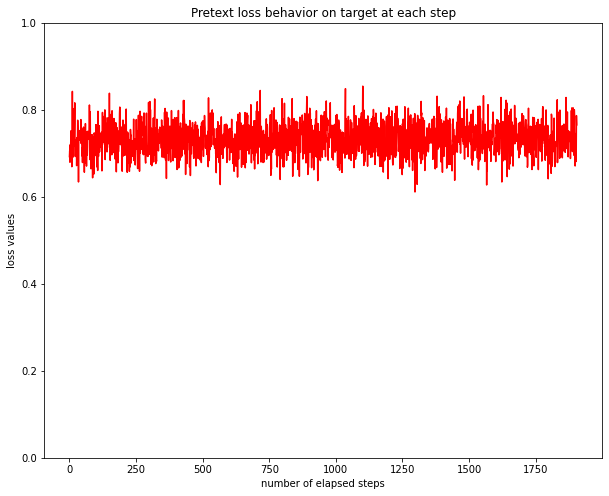

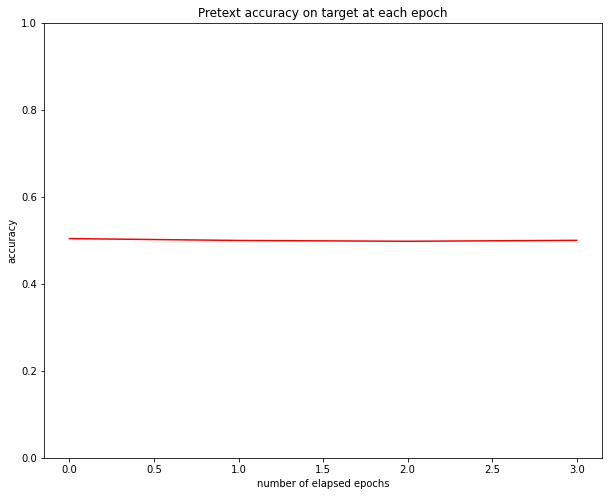

In [ ]:
#def simple_plot(x, y, title=None, x_label=None, y_label=None)
simple_plot([i for i in range(len(ptx_losses))], ptx_losses, title="Pretext loss behavior on target at each step", x_label="number of elapsed steps", y_label="loss values")

simple_plot([i for i in range(len(ptx_acc))], ptx_acc, title="Pretext accuracy on target at each epoch", x_label="number of elapsed epochs", y_label="accuracy")

In [ ]:
# Variation 1
_, _, _, _, _, _, _, _, _, _, v1_checkpoints = load_v_checkpoint(prefix="15")
checkpoint = v1_checkpoints[0]
v1_extractor = checkpoint['Extractor']
v1_classifier = checkpoint['mainTask']
# Extract source features
plottable_v1_source = visualizer.features_2d(src_rgb_samples, src_depth_samples, v1_extractor, v1_classifier)
# Extract target features
plottable_v1_target = visualizer.features_2d(tgt_rgb_samples, tgt_depth_samples, v1_extractor, v1_classifier)

# Variation 2
_, _, _, _, _, _, _, _, _, _, v2_checkpoints = load_v_checkpoint(prefix="15bis")
checkpoint = v2_checkpoints[0]
v2_extractor = checkpoint['Extractor']
v2_classifier = checkpoint['mainTask']
# Extract source features
plottable_v2_source = visualizer.features_2d(src_rgb_samples, src_depth_samples, v2_extractor, v2_classifier)
# Extract target features
plottable_v2_target = visualizer.features_2d(tgt_rgb_samples, tgt_depth_samples, v2_extractor, v2_classifier)

Restored checkpoint at epoch: 14
Restored checkpoint at epoch: 24


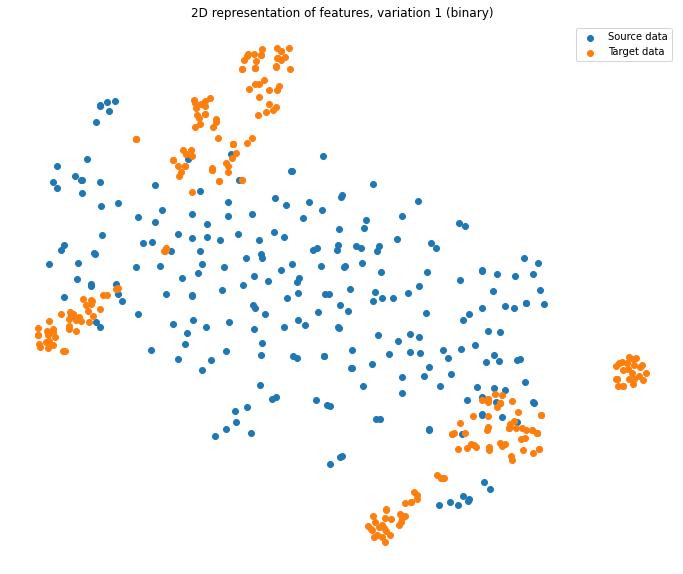

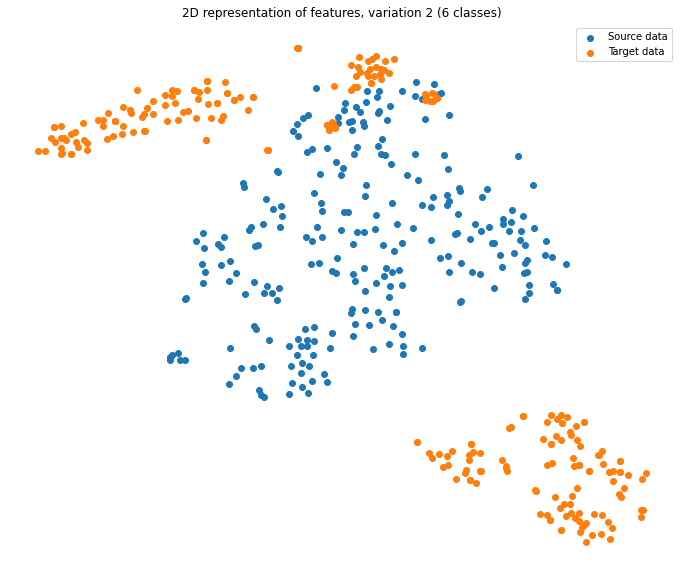

In [ ]:
# Plot the results

# V1
fig, ax = plt.subplots(figsize=(12,10))
plt.axis('off')
plt.title("2D representation of features, variation 1 (binary)")
ax.scatter(plottable_v1_source[:,0], plottable_v1_source[:,1], label="Source data")
ax.scatter(plottable_v1_target[:,0], plottable_v1_target[:,1], label="Target data")
ax.legend()
plt.show()

# V2
fig, ax = plt.subplots(figsize=(12,10))
plt.axis('off')
plt.title("2D representation of features, variation 2 (6 classes)")
ax.scatter(plottable_v2_source[:,0], plottable_v2_source[:,1], label="Source data")
ax.scatter(plottable_v2_target[:,0], plottable_v2_target[:,1], label="Target data")
ax.legend()
plt.show()